<img src="../images/camx.png" width="800">

<a href="https://colab.research.google.com/github/jaiswalsuraj487/Climax_project_autoencoder/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We have implemented MLP autoencoder, CNN autoencoder, and UNET autoencoder for image to image prediction on Camx dataset.

Go through the [link](https://github.com/jaiswalsuraj487/Climax_project_autoencoder/blob/main/Presentation.pdf) to see the presentation of the project to get the flow.
 
Git Repo: [link](https://github.com/jaiswalsuraj487/Climax_project_autoencoder)

In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import torch 
import os
import torch.utils.data as data
import torch.nn as nn
import glob 
# from torchsummary import summary
from torchinfo import summary
from tqdm import trange

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cuda:2")
print(device)
current_device = device #torch.cuda.current_device()
device_name = torch.cuda.get_device_name(current_device)
print(f"Current GPU assigned: {current_device}, Name: {device_name}")

cuda
Current GPU assigned: cuda, Name: Quadro RTX 5000


Consider it a prediction task, use any channel like pressure and/or wind speed inputs to start with, because they are the indicators of horizontal movement of air pollution. Multiple inputs can go as multiple channels of images similar to RGB. Output can be P25 or P10 in cam 120hr files.

In [ ]:
def get_latitudes():
    lat_start= 76.8499984741211
    lat_step=0.009999999776482582

    latitudes=[]

    for i in range(80):
        latitudes.append(lat_start+i*lat_step)
    
    latitudes.reverse()

    return latitudes

def get_longitudes():
    long_start= 28.200000762939453
    long_step=0.009999999776482582

    longitudes=[]

    for i in range(80):
        longitudes.append(long_start+i*long_step)
    
    # longitudes.reverse()

    return longitudes

latitudes=get_latitudes()
longitudes=get_longitudes()

def create_plot(data,hour,var_name):
    # print(data[var_name].shape) #shape (120, 1, 80, 80)
    p10_hour=data[var_name]['TSTEP'==hour] # shape (1, 80, 80)
    p10_hour=p10_hour[0,:,:] # shape (80, 80)
    plt.imshow(p10_hour)
    plt.title(f'{var_name} at hour '+str(hour))
    # plt.colorbar()

    # only show every latitude and longitude of end points
    # round to 2 decimal places
    top=latitudes[0]
    top=round(top,2) 
    bottom=latitudes[-1]
    bottom=round(bottom,2)
    left=longitudes[0]
    left=round(left,2)
    right=longitudes[-1]
    right=round(right,2)

    plt.xticks([0,79],[left,right])
    plt.xlabel('Longitude')
    plt.yticks([0,79],[top,bottom])
    plt.ylabel('Latitude')
    # plt.savefig(f'plots/120/{var_name}_{day}.png')
    # plt.close()

# Exploratory Data Analysis

## Visualizing 96 hr files

In [ ]:
data_96 = xr.open_dataset('data/camxmet2d.delhi.20230717.96hours.nc')
data_96_df = data_96.to_dataframe().reset_index()

In [ ]:
data_96

<xarray.Dataset>
Dimensions:     (TSTEP: 96, VAR: 14, DATE-TIME: 2, LAY: 1, ROW: 80, COL: 80)
Dimensions without coordinates: TSTEP, VAR, DATE-TIME, LAY, ROW, COL
Data variables: (12/15)
    TFLAG       (TSTEP, VAR, DATE-TIME) int32 2023198 0 ... 2023201 230000
    TSURF_K     (TSTEP, LAY, ROW, COL) float32 302.3 302.3 302.3 ... 300.6 301.2
    SNOWEW_M    (TSTEP, LAY, ROW, COL) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SNOWAGE_HR  (TSTEP, LAY, ROW, COL) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    PRATE_MMpH  (TSTEP, LAY, ROW, COL) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    CLOUD_OD    (TSTEP, LAY, ROW, COL) float32 62.24 61.67 61.1 ... 37.1 36.78
    ...          ...
    SWSFC_WpM2  (TSTEP, LAY, ROW, COL) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SOLM_M3pM3  (TSTEP, LAY, ROW, COL) float32 0.3131 0.3114 ... 0.3278 0.3292
    CLDTOP_KM   (TSTEP, LAY, ROW, COL) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    CAPE        (TSTEP, LAY, ROW, COL) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    PBL_WRF_M   (TSTEP, LAY, ROW, COL) float32 17.21 17.21 17.21 ... 94.4 120.0
    PBL_YSU_M   (TSTEP, LAY, ROW, COL) float32 17.21 17.21 17.21 ... 64.43 94.71
Attributes: (12/33)
    IOAPI_VERSION:  $Id: @(#) ioapi library version 3.0 $                    ...
    EXEC_ID:        ????????????????                                         ...
    FTYPE:          1
    CDATE:          2023198
    CTIME:          73941
    WDATE:          2023198
    ...             ...
    VGLVLS:         [0. 0.]
    GDNAM:          ????????????????
    UPNAM:          CAMx2IOAPI      
    VAR-LIST:       TSURF_K         SNOWEW_M        SNOWAGE_HR      PRATE_MMp...
    FILEDESC:       I/O API formatted CAMx AVRG output                       ...
    HISTORY:

In [ ]:
data_96_df

,TSTEP,VAR,DATE-TIME,LAY,ROW,COL,TFLAG,TSURF_K,SNOWEW_M,SNOWAGE_HR,...,CLOUD_OD,U10_MpS,V10_MpS,T2_K,SWSFC_WpM2,SOLM_M3pM3,CLDTOP_KM,CAPE,PBL_WRF_M,PBL_YSU_M
0,0,0,0,0,0,0,2023198,302.314636,0.0,0.0,...,62.239326,1.630373,0.148722,302.571838,0.0,0.313128,0.0,0.0,17.212452,17.212452
1,0,0,0,0,0,1,2023198,302.312042,0.0,0.0,...,61.671093,1.585281,0.158011,302.584351,0.0,0.311416,0.0,0.0,17.212652,17.212652
2,0,0,0,0,0,2,2023198,302.309479,0.0,0.0,...,61.102859,1.540188,0.167299,302.596832,0.0,0.309703,0.0,0.0,17.212852,17.212852
3,0,0,0,0,0,3,2023198,302.306885,0.0,0.0,...,60.534630,1.495095,0.176587,302.609344,0.0,0.307990,0.0,0.0,17.213055,17.213055
4,0,0,0,0,0,4,2023198,302.303558,0.0,0.0,...,59.912636,1.450304,0.184773,302.621948,0.0,0.306286,0.0,0.0,17.213356,17.213356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17203195,95,13,1,0,79,75,230000,298.979095,0.0,0.0,...,37.972748,0.600130,-1.341342,299.389465,0.0,0.324286,0.0,0.0,26.661556,17.082989
17203196,95,13,1,0,79,76,230000,299.372223,0.0,0.0,...,37.747482,0.658128,-1.301898,299.638062,0.0,0.324927,0.0,0.0,43.123440,17.094244
17203197,95,13,1,0,79,77,230000,299.967468,0.0,0.0,...,37.423786,0.732263,-1.252025,300.018402,0.0,0.326345,0.0,0.0,68.759804,17.112419
17203198,95,13,1,0,79,78,230000,300.562744,0.0,0.0,...,37.100090,0.806398,-1.202152,300.398743,0.0,0.327763,0.0,0.0,94.396065,64.426094


In [ ]:
data_96_df.columns

Index(['TSTEP', 'VAR', 'DATE-TIME', 'LAY', 'ROW', 'COL', 'TFLAG', 'TSURF_K',
       'SNOWEW_M', 'SNOWAGE_HR', 'PRATE_MMpH', 'CLOUD_OD', 'U10_MpS',
       'V10_MpS', 'T2_K', 'SWSFC_WpM2', 'SOLM_M3pM3', 'CLDTOP_KM', 'CAPE',
       'PBL_WRF_M', 'PBL_YSU_M'],
      dtype='object')

In [ ]:
data_96['U10_MpS'] #shape (96, 1, 80, 80)

<xarray.DataArray 'U10_MpS' (TSTEP: 96, LAY: 1, ROW: 80, COL: 80)>
array([[[[ 1.630373, ..., -0.434344],
         ...,
         [-0.544169, ..., -2.070899]]],


       ...,


       [[[ 0.569056, ...,  0.423629],
         ...,
         [ 0.774855, ...,  0.880477]]]], dtype=float32)
Dimensions without coordinates: TSTEP, LAY, ROW, COL
Attributes:
    long_name:  U10_MpS         
    units:      ppmV            
    var_desc:   VARIABLE U10_MpS                                             ...

In [ ]:
data_96['U10_MpS'].shape , data_96['U10_MpS']['TSTEP'==0].shape, data_96['U10_MpS']['TSTEP'==0][0].shape

((96, 1, 80, 80), (1, 80, 80), (80, 80))

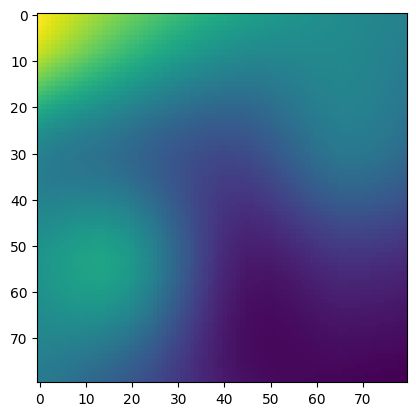

In [ ]:
plt.imshow(data_96['U10_MpS']['TSTEP'==0][0]) #shape (80, 80)

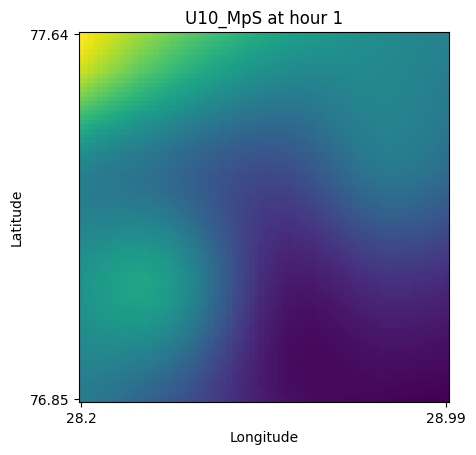

In [ ]:
create_plot(data = data_96, hour = 1, var_name = 'U10_MpS')

## Visualizing 120 hr files

In [ ]:
data_120 = xr.open_dataset('data/camx120hr_merged_20230717.nc')
data_120_df = data_120.to_dataframe().reset_index() 

In [ ]:
data_120 

<xarray.Dataset>
Dimensions:  (TSTEP: 120, LAY: 1, ROW: 80, COL: 80, VAR: 9, DATE-TIME: 2)
Dimensions without coordinates: TSTEP, LAY, ROW, COL, VAR, DATE-TIME
Data variables:
    P10      (TSTEP, LAY, ROW, COL) float32 23.86 23.86 24.07 ... 10.1 10.1
    P25      (TSTEP, LAY, ROW, COL) float32 19.24 19.24 19.62 ... 9.63 9.63
    TFLAG    (TSTEP, VAR, DATE-TIME) int32 2023197 0 2023197 ... 2023201 230000
Attributes: (12/34)
    IOAPI_VERSION:  $Id: @(#) ioapi library version 3.0 $                    ...
    EXEC_ID:        ????????????????                                         ...
    FTYPE:          1
    CDATE:          2023197
    CTIME:          83911
    WDATE:          2023197
    ...             ...
    GDNAM:          ????????????????
    UPNAM:          CAMXMETOU       
    VAR-LIST:       P10             P25             
    FILEDESC:       I/O API formatted CAMx AVRG output                       ...
    HISTORY:        Mon Jul 17 08:45:22 2023: ncrcat camxout.2023.07.16.nc ca...
    NCO:            netCDF Operators version 4.9.1 (Homepage = http://nco.sf....

In [ ]:
data_120_df

,TSTEP,LAY,ROW,COL,VAR,DATE-TIME,P10,P25,TFLAG
0,0,0,0,0,0,0,23.857107,19.240587,2023197
1,0,0,0,0,0,1,23.857107,19.240587,0
2,0,0,0,0,1,0,23.857107,19.240587,2023197
3,0,0,0,0,1,1,23.857107,19.240587,0
4,0,0,0,0,2,0,23.857107,19.240587,2023197
...,...,...,...,...,...,...,...,...,...
13823995,119,0,79,79,6,1,10.097546,9.629862,230000
13823996,119,0,79,79,7,0,10.097546,9.629862,2023201
13823997,119,0,79,79,7,1,10.097546,9.629862,230000
13823998,119,0,79,79,8,0,10.097546,9.629862,2023201


In [ ]:
data_120_df.describe()

,TSTEP,LAY,ROW,COL,VAR,DATE-TIME,P10,P25,TFLAG
count,1.382400e+07,13824000.0,1.382400e+07,1.382400e+07,1.382400e+07,13824000.0,1.382400e+07,1.382400e+07,1.382400e+07
mean,5.950000e+01,0.0,3.950000e+01,3.950000e+01,4.000000e+00,0.5,4.101470e+01,2.856279e+01,1.069100e+06
std,3.463981e+01,0.0,2.309221e+01,2.309221e+01,2.581989e+00,0.5,2.361775e+01,1.582030e+01,9.553543e+05
min,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1.111396e+00,8.114247e-01,0.000000e+00
25%,2.975000e+01,0.0,1.975000e+01,1.975000e+01,2.000000e+00,0.0,2.546643e+01,1.880392e+01,1.175000e+05
50%,5.950000e+01,0.0,3.950000e+01,3.950000e+01,4.000000e+00,0.5,3.590978e+01,2.589731e+01,1.126598e+06
75%,8.925000e+01,0.0,5.925000e+01,5.925000e+01,6.000000e+00,1.0,5.103806e+01,3.433007e+01,2.023199e+06
max,1.190000e+02,0.0,7.900000e+01,7.900000e+01,8.000000e+00,1.0,6.492913e+02,6.130998e+02,2.023201e+06


In [ ]:
data_120['COL']

<xarray.DataArray 'COL' (COL: 80)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76, 77, 78, 79])
Dimensions without coordinates: COL

In [ ]:
data_120['P10'] #shape (120, 1, 80, 80)

<xarray.DataArray 'P10' (TSTEP: 120, LAY: 1, ROW: 80, COL: 80)>
array([[[[23.857107, ..., 28.82367 ],
         ...,
         [34.902046, ..., 18.506985]]],


       ...,


       [[[38.434433, ..., 22.536842],
         ...,
         [20.921093, ..., 10.097546]]]], dtype=float32)
Dimensions without coordinates: TSTEP, LAY, ROW, COL
Attributes:
    long_name:  CPRM            
    units:      micrograms/m**3 
    var_desc:   VARIABLE CPRM                                                ...

In [ ]:
data_120['P10']['TSTEP'==1]# shape 1x80x80

<xarray.DataArray 'P10' (LAY: 1, ROW: 80, COL: 80)>
array([[[23.857107, 23.857107, ..., 28.82367 , 28.82367 ],
        [23.857107, 23.857107, ..., 28.82367 , 28.82367 ],
        ...,
        [34.902046, 34.902046, ..., 18.506985, 18.506985],
        [34.902046, 34.902046, ..., 18.506985, 18.506985]]], dtype=float32)
Dimensions without coordinates: LAY, ROW, COL
Attributes:
    long_name:  CPRM            
    units:      micrograms/m**3 
    var_desc:   VARIABLE CPRM                                                ...

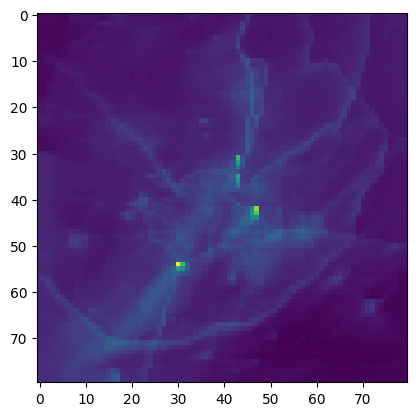

In [ ]:
data_120['P10']['TSTEP'==1][0] # shape 80x80
plt.imshow(data_120['P25']['TSTEP'==1][0])#, vmin=0, vmax=100)

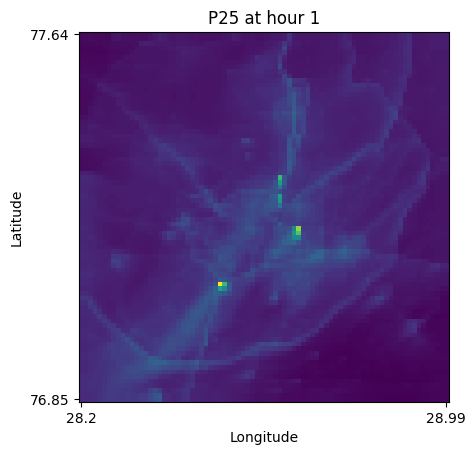

In [ ]:
create_plot(data_120,1,'P25') 

# Constructing data

In [ ]:
# Define the folder path where your files are located
folder_path = 'data/'

# Use glob to retrieve all netCDF files in the folder
file_pattern = 'camx120*.nc'
files_120 = glob.glob(folder_path + file_pattern)
# files_120

file_pattern = '*96hours.nc'
files_96 = glob.glob(folder_path + file_pattern)
# files_96

In [ ]:
print(len(files_120))
files_120.sort()
print(files_120[0], files_120[-1]) 

70
data/camx120hr_merged_20230717.nc data/camx120hr_merged_20230924.nc


In [ ]:
print(len(files_96))
files_96.sort()
print(files_96[0], files_96[-1]) 

69
data/camxmet2d.delhi.20230717.96hours.nc data/camxmet2d.delhi.20230924.96hours.nc


camx96hr has 20230808 day file missing. so removing it from camx120hr as well 'data/camx120hr_merged_20230808.nc'

In [ ]:
files_120.remove('data/camx120hr_merged_20230808.nc')
len(files_120) 

69

camx96hr file contains 96 hrs for days [0,1,2,3]

camx120hr file contains 120 hrs for days [-1,0,1,2,3]

We need current day data from each file to avoid redundancy. So we will take 0-23 hrs from camx96hr and 24-47hrs from camx120hr

In [ ]:
def get_data(target_var_96_list, target_var_120_list):
    X = []
    y = []
 
    for target_var_96 in target_var_96_list:
        column = []
        for i in files_96:
            data_96 = xr.open_dataset(i)
            for j in range(0,24):
                variable96 = data_96[target_var_96]['TSTEP'==j]
                column.append(variable96)
        column = np.array(column)
        # print(column.shape) # (69*24, 1, 80, 80)
        X.append(column)
    X = np.array(X)
    X = np.concatenate([X[i] for i in range(X.shape[0])], axis=1)
    print('X shape ',X.shape)
    for target_var_120 in target_var_120_list:
        column = []
        for i in files_120:
            data_120 = xr.open_dataset(i)
            for j in range(0,24):
                variable120 = data_120[target_var_120]['TSTEP'==24+j]
                column.append(variable120)
        column = np.array(column)
        # print(column.shape) # (69*24, 1, 80, 80)
        y.append(column)
    y = np.array(y)
    y = np.concatenate([y[i] for i in range(y.shape[0])], axis=1)
    print('y shape', y.shape)
    return X,y

In [ ]:
target_var_96_list =['TSURF_K',
       'SNOWEW_M', 'SNOWAGE_HR', 'PRATE_MMpH', 'CLOUD_OD', 'U10_MpS',
       'V10_MpS', 'T2_K', 'SWSFC_WpM2', 'SOLM_M3pM3', 'CLDTOP_KM', 'CAPE',
       'PBL_WRF_M', 'PBL_YSU_M']  # ['U10_MpS', 'T2_K', 'V10_MpS']
target_var_120_list = ['P25','P10'] 
X,y  = get_data(target_var_96_list, target_var_120_list)

X shape  (1656, 14, 80, 80)
y shape (1656, 2, 80, 80)


In [ ]:
class CustomDataset(data.Dataset):
    def __init__(self, input_data, output_data):
        self.input_data = input_data
        self.output_data = output_data

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, index):
        input_sample = torch.Tensor(self.input_data[index])
        output_sample = torch.Tensor(self.output_data[index])
        return input_sample, output_sample 

# Simple autoencoder

## Model defination

In [ ]:
class Autoencoder_MLP(nn.Module):
    def __init__(self):
        super(Autoencoder_MLP, self).__init__()
        
        # Define the layers
        self.flatten = nn.Flatten()  # Flatten the 2D input matrix
        self.fc1 = nn.Linear(80*80, 1024)  # Fully connected layer 1
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 1024)  # Fully connected layer 2
        self.fc4 = nn.Linear(1024, 80*80)  # Fully connected layer 2
        self.relu = nn.ReLU()  # Activation function

    def forward(self, x):
        # Flatten the input
        x = self.flatten(x)
        
        # Forward pass through the fully connected layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)

        # Reshape the output to match the 2D matrix size
        x = x.view(-1, 80, 80)
        
        return x

In [ ]:
summary(Autoencoder_MLP(), input_size=(1, 80, 80))

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder_MLP                          [1, 80, 80]               --
├─Flatten: 1-1                           [1, 6400]                 --
├─Linear: 1-2                            [1, 1024]                 6,554,624
├─ReLU: 1-3                              [1, 1024]                 --
├─Linear: 1-4                            [1, 512]                  524,800
├─ReLU: 1-5                              [1, 512]                  --
├─Linear: 1-6                            [1, 1024]                 525,312
├─ReLU: 1-7                              [1, 1024]                 --
├─Linear: 1-8                            [1, 6400]                 6,560,000
Total params: 14,164,736
Trainable params: 14,164,736
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 14.16
Input size (MB): 0.03
Forward/backward pass size (MB): 0.07
Params size (MB): 56.66
Estimated Total Size (MB): 56.76

## Training single channel input and output(P25)

In [ ]:
X.shape, y.shape

((1656, 14, 80, 80), (1656, 2, 80, 80))

In [ ]:
from sklearn.model_selection import train_test_split
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_all.shape, X_test_all.shape, y_train_all.shape, y_test_all.shape

((1324, 14, 80, 80), (332, 14, 80, 80), (1324, 2, 80, 80), (332, 2, 80, 80))

X Channel name :  TSURF_K
Shapes:  (1324, 80, 80) (332, 80, 80) (1324, 80, 80) (332, 80, 80)


Epoch [1/200] Loss: 405.4315
Epoch [21/200] Loss: 214.5978
Epoch [41/200] Loss: 215.0236
Epoch [61/200] Loss: 207.2482
Epoch [81/200] Loss: 206.7534
Epoch [101/200] Loss: 213.1840
Epoch [121/200] Loss: 207.5252
Epoch [141/200] Loss: 208.2888
Epoch [161/200] Loss: 209.6494
Epoch [181/200] Loss: 209.7600
Average Test Loss: 190.0971


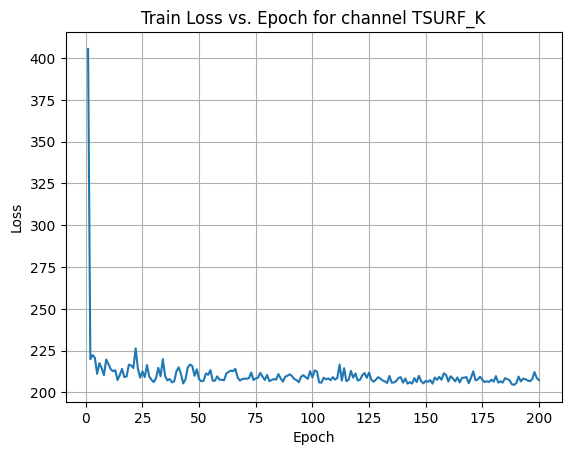

X Channel name :  SNOWEW_M
Shapes:  (1324, 80, 80) (332, 80, 80) (1324, 80, 80) (332, 80, 80)
Epoch [1/200] Loss: 464.9160
Epoch [21/200] Loss: 206.1055
Epoch [41/200] Loss: 210.0196
Epoch [61/200] Loss: 209.2211
Epoch [81/200] Loss: 211.8091
Epoch [101/200] Loss: 205.4592
Epoch [121/200] Loss: 203.9590
Epoch [141/200] Loss: 208.5030
Epoch [161/200] Loss: 207.1320
Epoch [181/200] Loss: 204.3017
Average Test Loss: 189.7174


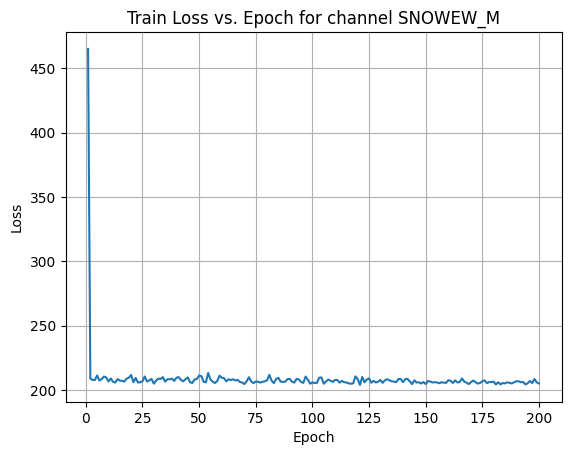

X Channel name :  SNOWAGE_HR
Shapes:  (1324, 80, 80) (332, 80, 80) (1324, 80, 80) (332, 80, 80)
Epoch [1/200] Loss: 460.0334
Epoch [21/200] Loss: 207.1043
Epoch [41/200] Loss: 206.5882
Epoch [61/200] Loss: 208.3192
Epoch [81/200] Loss: 205.4035
Epoch [101/200] Loss: 209.7349
Epoch [121/200] Loss: 205.5515
Epoch [141/200] Loss: 206.1994
Epoch [161/200] Loss: 205.4001
Epoch [181/200] Loss: 206.3801
Average Test Loss: 190.0263


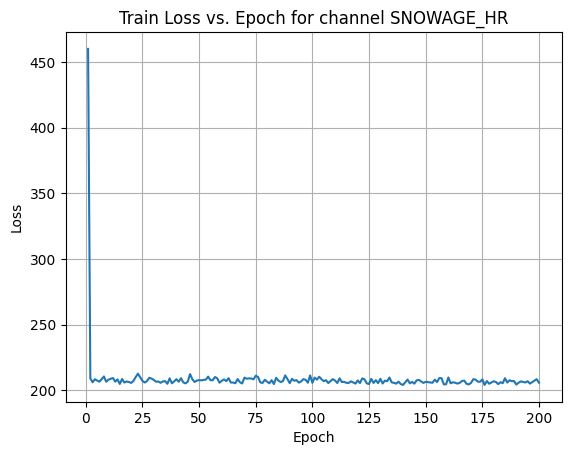

X Channel name :  PRATE_MMpH
Shapes:  (1324, 80, 80) (332, 80, 80) (1324, 80, 80) (332, 80, 80)
Epoch [1/200] Loss: 476.9623
Epoch [21/200] Loss: 207.3108
Epoch [41/200] Loss: 208.4855
Epoch [61/200] Loss: 206.4735
Epoch [81/200] Loss: 205.5895
Epoch [101/200] Loss: 205.6536
Epoch [121/200] Loss: 205.9680
Epoch [141/200] Loss: 205.7129
Epoch [161/200] Loss: 208.6799
Epoch [181/200] Loss: 205.6486
Average Test Loss: 189.6717


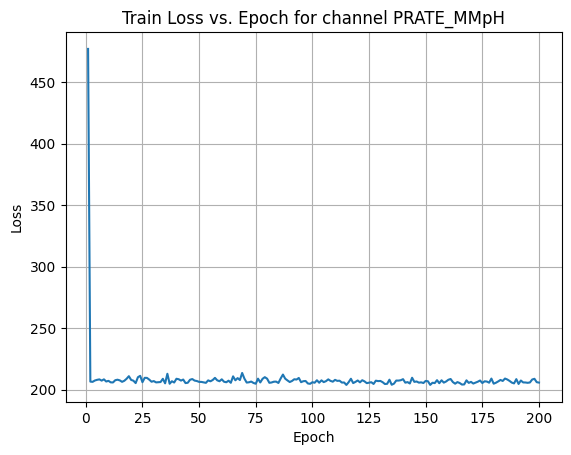

X Channel name :  CLOUD_OD
Shapes:  (1324, 80, 80) (332, 80, 80) (1324, 80, 80) (332, 80, 80)
Epoch [1/200] Loss: 599.1686
Epoch [21/200] Loss: 454.3787
Epoch [41/200] Loss: 149.9270
Epoch [61/200] Loss: 23.7072
Epoch [81/200] Loss: 7.4556
Epoch [101/200] Loss: 18.4050
Epoch [121/200] Loss: 3.0840
Epoch [141/200] Loss: 100.6344
Epoch [161/200] Loss: 25.9631
Epoch [181/200] Loss: 38.8335
Average Test Loss: 9.8902


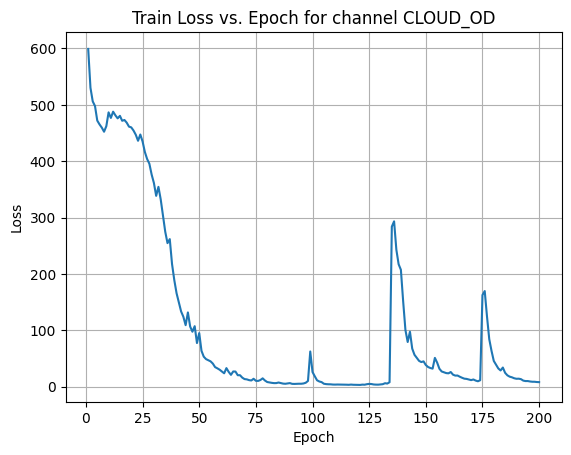

X Channel name :  U10_MpS
Shapes:  (1324, 80, 80) (332, 80, 80) (1324, 80, 80) (332, 80, 80)
Epoch [1/200] Loss: 373.7542
Epoch [21/200] Loss: 51.2008
Epoch [41/200] Loss: 37.7057
Epoch [61/200] Loss: 25.3702
Epoch [81/200] Loss: 0.2791
Epoch [101/200] Loss: 20.1649
Epoch [121/200] Loss: 0.2297
Epoch [141/200] Loss: 84.8078
Epoch [161/200] Loss: 2.4612
Epoch [181/200] Loss: 1.4404
Average Test Loss: 0.7598


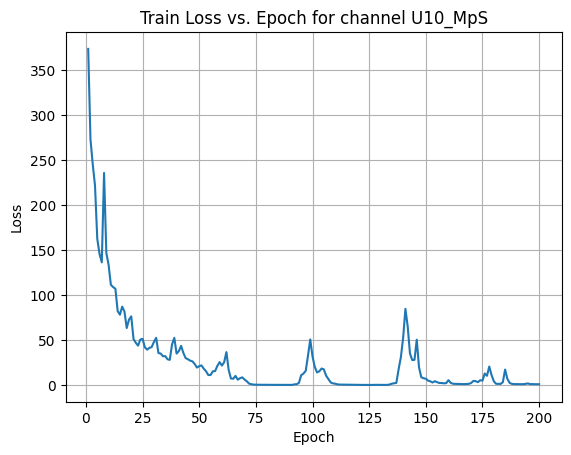

X Channel name :  V10_MpS
Shapes:  (1324, 80, 80) (332, 80, 80) (1324, 80, 80) (332, 80, 80)
Epoch [1/200] Loss: 399.2307
Epoch [21/200] Loss: 1.1263
Epoch [41/200] Loss: 0.0137
Epoch [61/200] Loss: 0.0820
Epoch [81/200] Loss: 2.3733
Epoch [101/200] Loss: 0.0002
Epoch [121/200] Loss: 0.0113
Epoch [141/200] Loss: 0.0393
Epoch [161/200] Loss: 11.0771
Epoch [181/200] Loss: 0.0003
Average Test Loss: 0.0507


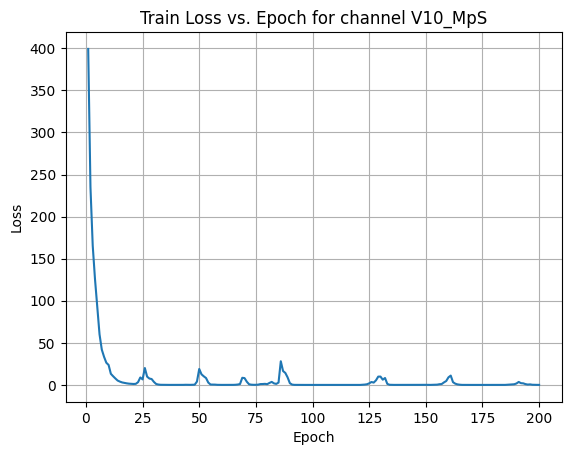

X Channel name :  T2_K
Shapes:  (1324, 80, 80) (332, 80, 80) (1324, 80, 80) (332, 80, 80)
Epoch [1/200] Loss: 412.2657
Epoch [21/200] Loss: 210.9129
Epoch [41/200] Loss: 209.2686
Epoch [61/200] Loss: 206.7048
Epoch [81/200] Loss: 206.0187
Epoch [101/200] Loss: 209.1361
Epoch [121/200] Loss: 212.1444
Epoch [141/200] Loss: 206.8286
Epoch [161/200] Loss: 205.8083
Epoch [181/200] Loss: 208.7421
Average Test Loss: 190.9819


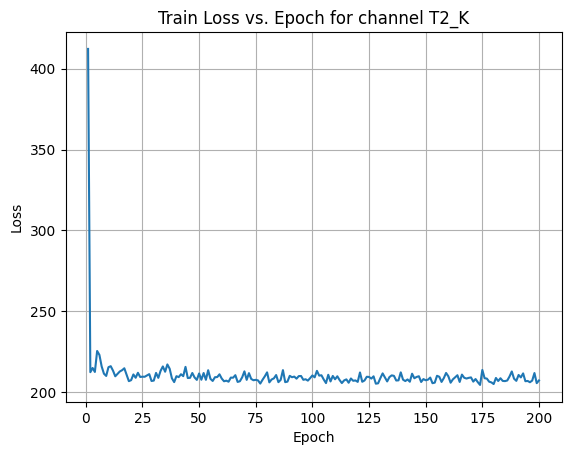

X Channel name :  SWSFC_WpM2
Shapes:  (1324, 80, 80) (332, 80, 80) (1324, 80, 80) (332, 80, 80)
Epoch [1/200] Loss: 485.4561
Epoch [21/200] Loss: 210.1752
Epoch [41/200] Loss: 207.2874
Epoch [61/200] Loss: 207.9026
Epoch [81/200] Loss: 206.2404
Epoch [101/200] Loss: 205.9271
Epoch [121/200] Loss: 205.6481
Epoch [141/200] Loss: 208.2400
Epoch [161/200] Loss: 205.4081
Epoch [181/200] Loss: 205.1859
Average Test Loss: 199.1508


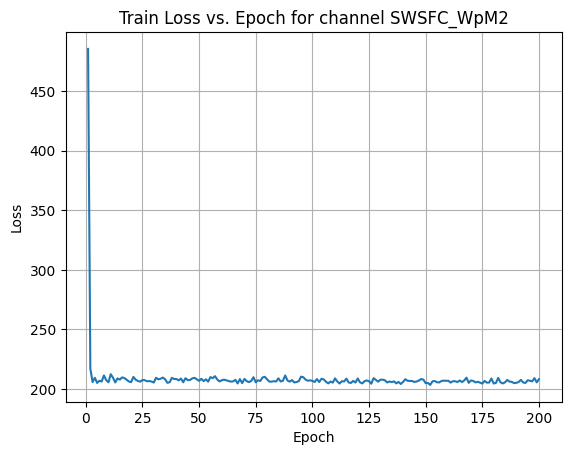

X Channel name :  SOLM_M3pM3
Shapes:  (1324, 80, 80) (332, 80, 80) (1324, 80, 80) (332, 80, 80)
Epoch [1/200] Loss: 305.6402
Epoch [21/200] Loss: 176.6024
Epoch [41/200] Loss: 161.6851
Epoch [61/200] Loss: 157.7673
Epoch [81/200] Loss: 138.7664
Epoch [101/200] Loss: 132.1217
Epoch [121/200] Loss: 109.4900
Epoch [141/200] Loss: 104.2382
Epoch [161/200] Loss: 69.5860
Epoch [181/200] Loss: 50.0248
Average Test Loss: 42.1182


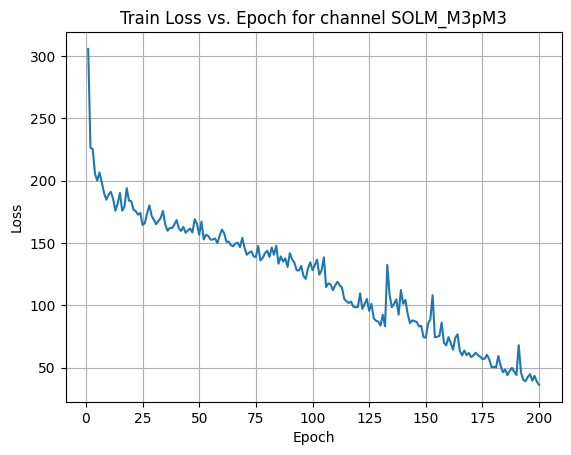

X Channel name :  CLDTOP_KM
Shapes:  (1324, 80, 80) (332, 80, 80) (1324, 80, 80) (332, 80, 80)
Epoch [1/200] Loss: 461.0668
Epoch [21/200] Loss: 205.2268
Epoch [41/200] Loss: 213.0740
Epoch [61/200] Loss: 206.9702
Epoch [81/200] Loss: 205.7769
Epoch [101/200] Loss: 210.3533
Epoch [121/200] Loss: 206.2578
Epoch [141/200] Loss: 207.2727
Epoch [161/200] Loss: 205.3765
Epoch [181/200] Loss: 206.2520
Average Test Loss: 192.2221


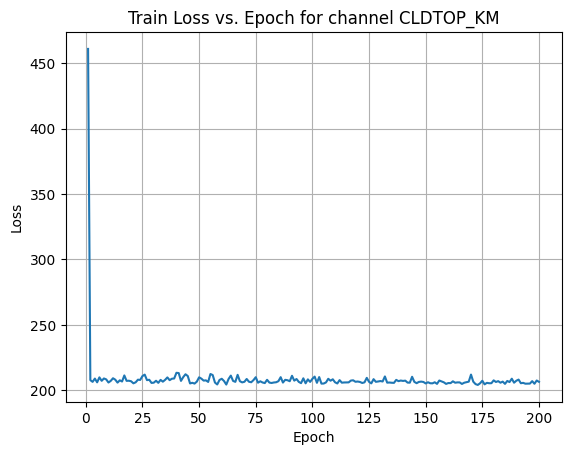

X Channel name :  CAPE
Shapes:  (1324, 80, 80) (332, 80, 80) (1324, 80, 80) (332, 80, 80)
Epoch [1/200] Loss: 468.8439
Epoch [21/200] Loss: 207.2851
Epoch [41/200] Loss: 211.7429
Epoch [61/200] Loss: 205.8536
Epoch [81/200] Loss: 205.3124
Epoch [101/200] Loss: 207.8155
Epoch [121/200] Loss: 208.3488
Epoch [141/200] Loss: 206.0120
Epoch [161/200] Loss: 205.9442
Epoch [181/200] Loss: 204.1215
Average Test Loss: 190.8858


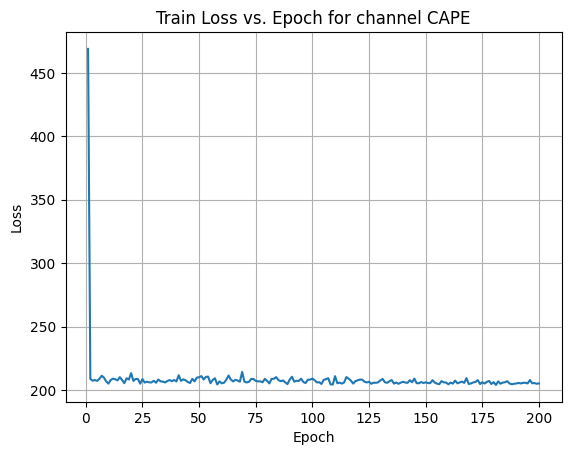

X Channel name :  PBL_WRF_M
Shapes:  (1324, 80, 80) (332, 80, 80) (1324, 80, 80) (332, 80, 80)
Epoch [1/200] Loss: 287.4021
Epoch [21/200] Loss: 209.5118
Epoch [41/200] Loss: 209.2537
Epoch [61/200] Loss: 206.0375
Epoch [81/200] Loss: 207.1711
Epoch [101/200] Loss: 205.2734
Epoch [121/200] Loss: 210.4286
Epoch [141/200] Loss: 207.5243
Epoch [161/200] Loss: 208.9856
Epoch [181/200] Loss: 204.6973
Average Test Loss: 191.9669


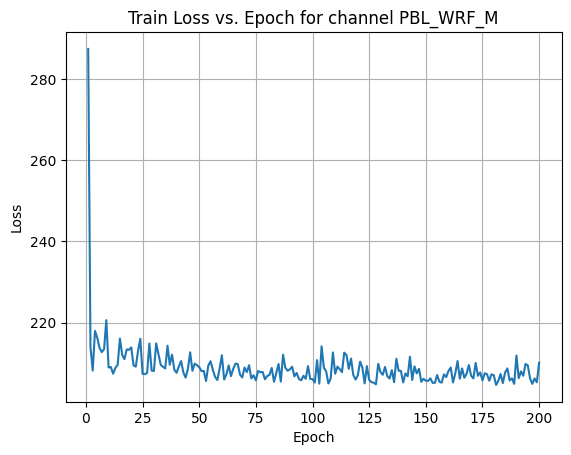

X Channel name :  PBL_YSU_M
Shapes:  (1324, 80, 80) (332, 80, 80) (1324, 80, 80) (332, 80, 80)
Epoch [1/200] Loss: 323.2034
Epoch [21/200] Loss: 207.3925
Epoch [41/200] Loss: 210.0555
Epoch [61/200] Loss: 206.0877
Epoch [81/200] Loss: 207.9315
Epoch [101/200] Loss: 207.4798
Epoch [121/200] Loss: 206.1072
Epoch [141/200] Loss: 207.4259
Epoch [161/200] Loss: 209.3318
Epoch [181/200] Loss: 207.3006
Average Test Loss: 194.3565


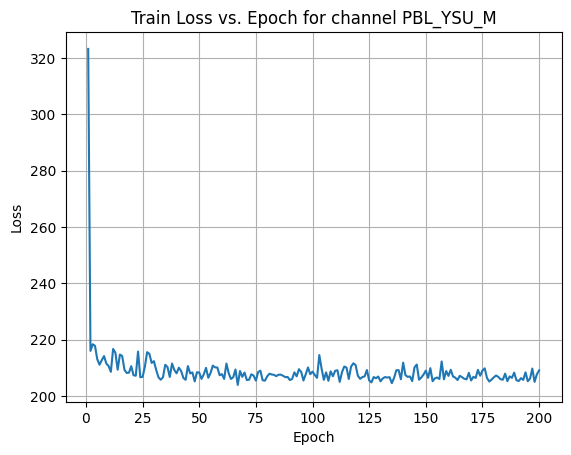

In [ ]:
test_loss_list_P_25 = []
y_channel = 0 
# x_channel = 0
for x_channel in range(X.shape[1]):
    ####################### Selecting the channel #######################
    print('X Channel name : ', target_var_96_list[x_channel])
    X_train = X_train_all[:, x_channel, :,:]
    X_test = X_test_all[:, x_channel, :,:]
    y_train = y_train_all[:, y_channel, :,:]
    y_test = y_test_all[:, y_channel, :,:]
    print('Shapes: ', X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    ####################### Creating the dataset loader #######################
    train_custom_dataset = CustomDataset(X_train, y_train)
    # print(len(train_custom_dataset))
    batch_size = 32
    train_loader = data.DataLoader(train_custom_dataset, batch_size=batch_size, shuffle=True)
    # print(len(train_loader))
    
    test_custom_dataset = CustomDataset(X_test, y_test)
    # print(len(test_custom_dataset))
    batch_size = 32
    test_loader = data.DataLoader(test_custom_dataset, batch_size=batch_size, shuffle=False)
    # print(len(test_loader))
    

    #################### Training the model ####################
    model = Autoencoder_MLP()
    model.to(device)
    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    losses = []
    # Training loop
    num_epochs = 200
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        total_loss = 0.0
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()  # Zero the gradients
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Forward pass
            outputs = model(inputs)
            
            # Calculate the loss
            loss = criterion(outputs, targets)
            
            # Backpropagation
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        # Print the average loss for this epoch
        average_loss = total_loss / len(train_loader)
        losses.append(average_loss)
        if epoch % 20 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {average_loss:.4f}")
    
    
    ############################# testing the model #############################
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Calculate the loss
            loss = criterion(outputs, targets)

            test_loss += loss.item()

    # Print the average test loss
    average_test_loss = test_loss / len(test_loader)
    test_loss_list_P_25.append(average_test_loss)
    print(f"Average Test Loss: {average_test_loss:.4f}")
    
    plt.plot(range(1, num_epochs + 1), losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train Loss vs. Epoch for channel '+target_var_96_list[x_channel])
    plt.grid(True) 
    plt.show() 

In [ ]:
test_loss_list_P_25

[190.09705144708806,
 189.7173545143821,
 190.02632834694603,
 189.67173489657316,
 9.890190774744207,
 0.7598354017192667,
 0.050707115029746834,
 190.98193498091265,
 199.15079567649147,
 42.118152445012875,
 192.22213883833453,
 190.88581431995738,
 191.9668634588068,
 194.3564910888672]

In [ ]:
name_loss_pairs = list(zip(target_var_96_list, test_loss_list_P_25))

# Sort based on loss values
sorted_name_loss_pairs = sorted(name_loss_pairs, key=lambda x: x[1])
for pair in sorted_name_loss_pairs:
    print(pair)
# print(sorted_name_loss_pairs)
# Select the lowest 3 names
lowest_3_names = [pair[0] for pair in sorted_name_loss_pairs[:3]]

print("Lowest 3 names:", lowest_3_names)

('V10_MpS', 0.050707115029746834)
('U10_MpS', 0.7598354017192667)
('CLOUD_OD', 9.890190774744207)
('SOLM_M3pM3', 42.118152445012875)
('PRATE_MMpH', 189.67173489657316)
('SNOWEW_M', 189.7173545143821)
('SNOWAGE_HR', 190.02632834694603)
('TSURF_K', 190.09705144708806)
('CAPE', 190.88581431995738)
('T2_K', 190.98193498091265)
('PBL_WRF_M', 191.9668634588068)
('CLDTOP_KM', 192.22213883833453)
('PBL_YSU_M', 194.3564910888672)
('SWSFC_WpM2', 199.15079567649147)
Lowest 3 names: ['V10_MpS', 'U10_MpS', 'CLOUD_OD']


## Training single channel input and output(P25)

X Channel name :  TSURF_K
Shapes:  (1324, 80, 80) (332, 80, 80) (1324, 80, 80) (332, 80, 80)
Epoch [1/200] Loss: 689.7490
Epoch [21/200] Loss: 418.6676
Epoch [41/200] Loss: 410.9685
Epoch [61/200] Loss: 404.8066
Epoch [81/200] Loss: 400.5351
Epoch [101/200] Loss: 401.0250
Epoch [121/200] Loss: 401.0659
Epoch [141/200] Loss: 403.6432
Epoch [161/200] Loss: 402.2360
Epoch [181/200] Loss: 407.2921
Average Test Loss: 401.8882


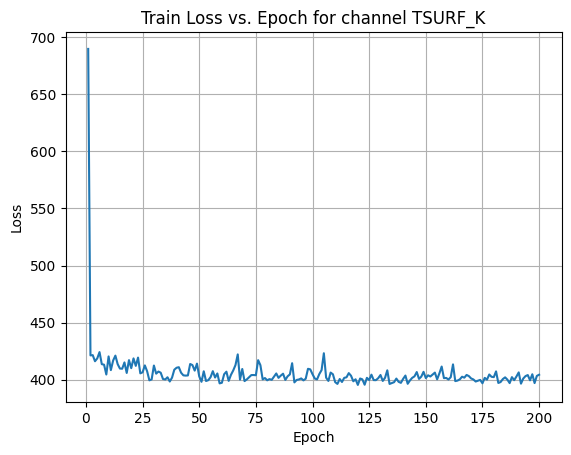

X Channel name :  SNOWEW_M
Shapes:  (1324, 80, 80) (332, 80, 80) (1324, 80, 80) (332, 80, 80)
Epoch [1/200] Loss: 1031.9999
Epoch [21/200] Loss: 405.7656
Epoch [41/200] Loss: 402.2811
Epoch [61/200] Loss: 403.8337
Epoch [81/200] Loss: 398.2591
Epoch [101/200] Loss: 409.4181
Epoch [121/200] Loss: 396.3737
Epoch [141/200] Loss: 395.1861
Epoch [161/200] Loss: 403.0066
Epoch [181/200] Loss: 397.6094
Average Test Loss: 361.2384


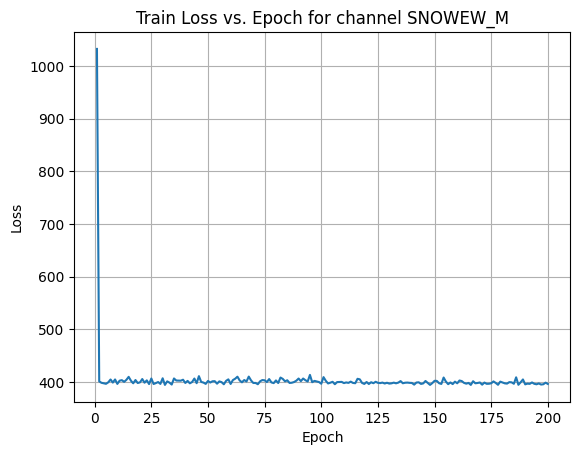

X Channel name :  SNOWAGE_HR
Shapes:  (1324, 80, 80) (332, 80, 80) (1324, 80, 80) (332, 80, 80)
Epoch [1/200] Loss: 1050.1397
Epoch [21/200] Loss: 397.1798
Epoch [41/200] Loss: 401.0453
Epoch [61/200] Loss: 401.7171
Epoch [81/200] Loss: 400.2689
Epoch [101/200] Loss: 396.7101
Epoch [121/200] Loss: 404.5816
Epoch [141/200] Loss: 397.7231
Epoch [161/200] Loss: 394.6489
Epoch [181/200] Loss: 399.8899
Average Test Loss: 362.0641


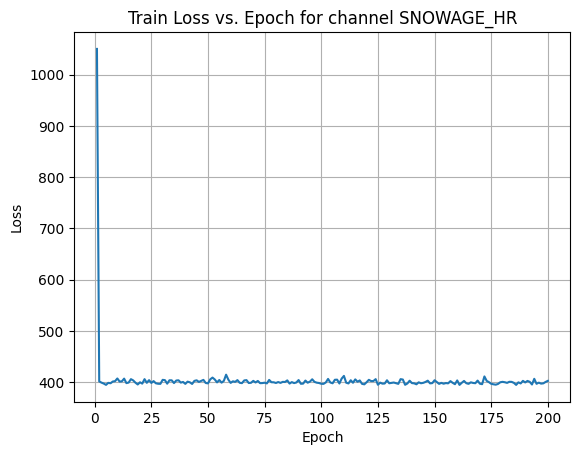

X Channel name :  PRATE_MMpH
Shapes:  (1324, 80, 80) (332, 80, 80) (1324, 80, 80) (332, 80, 80)
Epoch [1/200] Loss: 1034.3143
Epoch [21/200] Loss: 399.8861
Epoch [41/200] Loss: 399.7876
Epoch [61/200] Loss: 395.9112
Epoch [81/200] Loss: 400.4803
Epoch [101/200] Loss: 396.5552
Epoch [121/200] Loss: 401.0467
Epoch [141/200] Loss: 406.4987
Epoch [161/200] Loss: 401.3759
Epoch [181/200] Loss: 397.4671
Average Test Loss: 361.1263


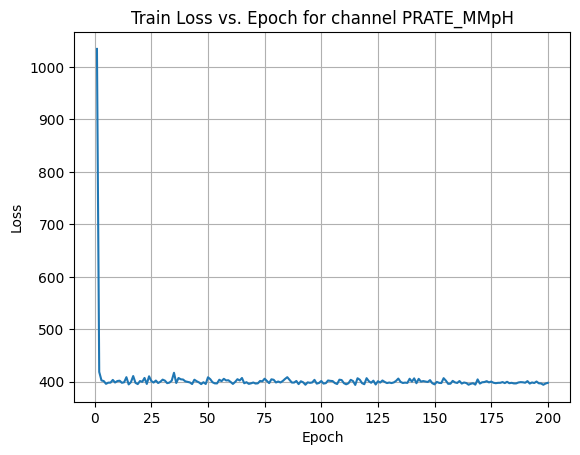

X Channel name :  CLOUD_OD
Shapes:  (1324, 80, 80) (332, 80, 80) (1324, 80, 80) (332, 80, 80)
Epoch [1/200] Loss: 1214.4916
Epoch [21/200] Loss: 725.7131
Epoch [41/200] Loss: 220.5272
Epoch [61/200] Loss: 23.5934
Epoch [81/200] Loss: 8.8063
Epoch [101/200] Loss: 274.7881
Epoch [121/200] Loss: 218.0335
Epoch [141/200] Loss: 232.4360
Epoch [161/200] Loss: 212.6520
Epoch [181/200] Loss: 195.4785
Average Test Loss: 180.2198


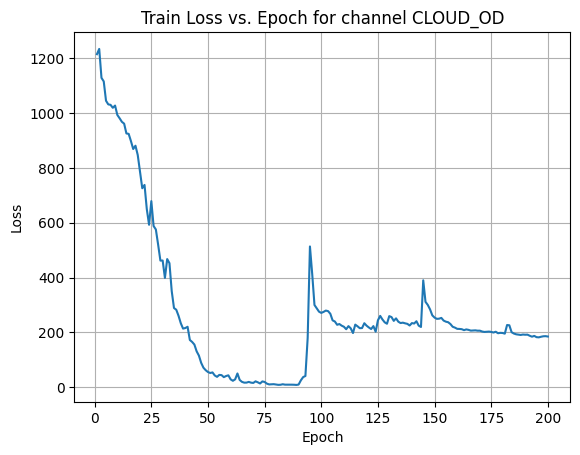

X Channel name :  U10_MpS
Shapes:  (1324, 80, 80) (332, 80, 80) (1324, 80, 80) (332, 80, 80)
Epoch [1/200] Loss: 822.4214
Epoch [21/200] Loss: 182.0370
Epoch [41/200] Loss: 50.0221
Epoch [61/200] Loss: 60.5883
Epoch [81/200] Loss: 37.8001
Epoch [101/200] Loss: 2.6386
Epoch [121/200] Loss: 0.0629
Epoch [141/200] Loss: 76.5106
Epoch [161/200] Loss: 41.2225
Epoch [181/200] Loss: 4.6194
Average Test Loss: 0.6711


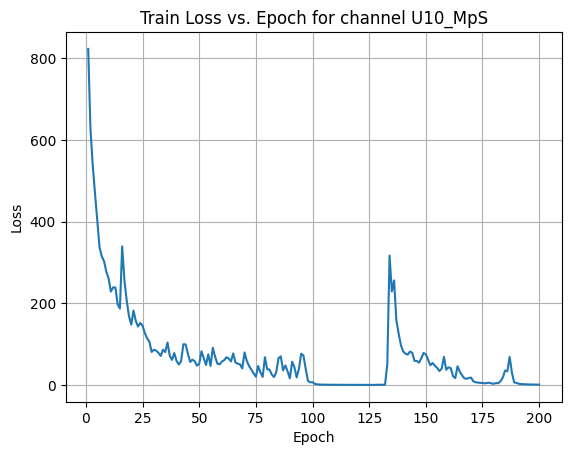

X Channel name :  V10_MpS
Shapes:  (1324, 80, 80) (332, 80, 80) (1324, 80, 80) (332, 80, 80)
Epoch [1/200] Loss: 1160.5402
Epoch [21/200] Loss: 8.7026
Epoch [41/200] Loss: 0.3045
Epoch [61/200] Loss: 0.1493
Epoch [81/200] Loss: 0.1235
Epoch [101/200] Loss: 5.4404
Epoch [121/200] Loss: 0.0000
Epoch [141/200] Loss: 10.2387
Epoch [161/200] Loss: 0.2644
Epoch [181/200] Loss: 0.0284
Average Test Loss: 0.6849


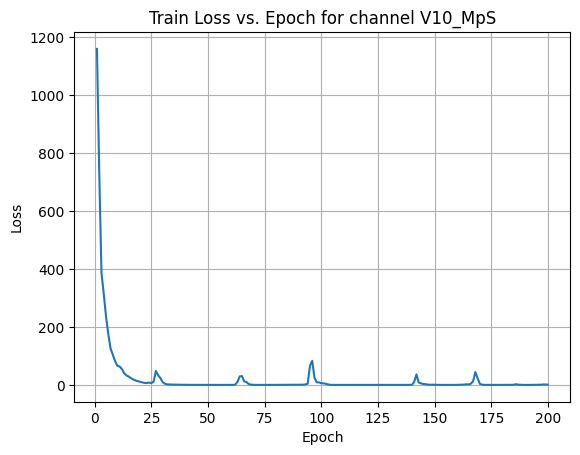

X Channel name :  T2_K
Shapes:  (1324, 80, 80) (332, 80, 80) (1324, 80, 80) (332, 80, 80)
Epoch [1/200] Loss: 646.6076
Epoch [21/200] Loss: 412.2161
Epoch [41/200] Loss: 407.6458
Epoch [61/200] Loss: 403.7684
Epoch [81/200] Loss: 399.9570
Epoch [101/200] Loss: 397.7386
Epoch [121/200] Loss: 402.0990
Epoch [141/200] Loss: 397.6674
Epoch [161/200] Loss: 398.1612
Epoch [181/200] Loss: 403.3343
Average Test Loss: 360.5232


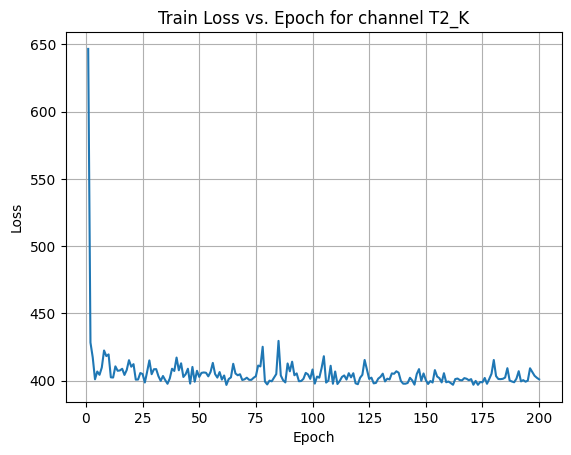

X Channel name :  SWSFC_WpM2
Shapes:  (1324, 80, 80) (332, 80, 80) (1324, 80, 80) (332, 80, 80)
Epoch [1/200] Loss: 1027.1539
Epoch [21/200] Loss: 403.9408
Epoch [41/200] Loss: 401.9444
Epoch [61/200] Loss: 399.7967
Epoch [81/200] Loss: 401.7070
Epoch [101/200] Loss: 404.1586
Epoch [121/200] Loss: 398.2909
Epoch [141/200] Loss: 396.0758
Epoch [161/200] Loss: 396.4020
Epoch [181/200] Loss: 402.5728
Average Test Loss: 362.6420


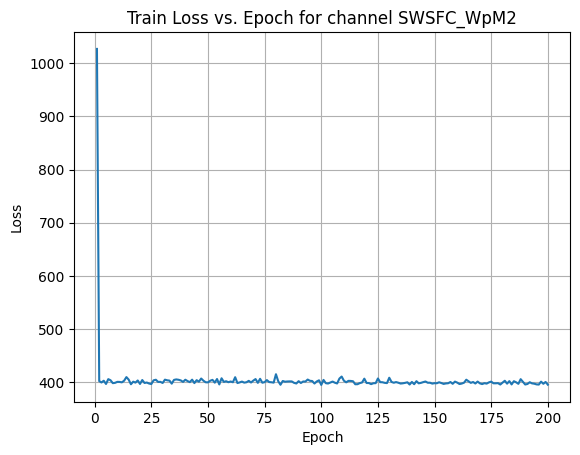

X Channel name :  SOLM_M3pM3
Shapes:  (1324, 80, 80) (332, 80, 80) (1324, 80, 80) (332, 80, 80)
Epoch [1/200] Loss: 696.3634
Epoch [21/200] Loss: 331.1351
Epoch [41/200] Loss: 296.5541
Epoch [61/200] Loss: 301.9112
Epoch [81/200] Loss: 272.0759
Epoch [101/200] Loss: 251.3878
Epoch [121/200] Loss: 232.4279
Epoch [141/200] Loss: 170.0628
Epoch [161/200] Loss: 138.8842
Epoch [181/200] Loss: 108.4864
Average Test Loss: 110.6638


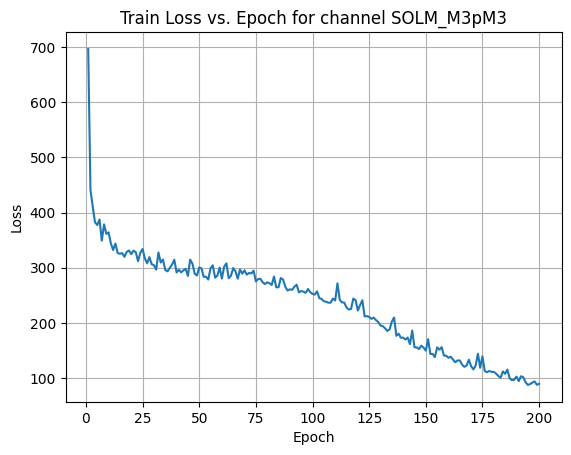

X Channel name :  CLDTOP_KM
Shapes:  (1324, 80, 80) (332, 80, 80) (1324, 80, 80) (332, 80, 80)
Epoch [1/200] Loss: 1017.6373
Epoch [21/200] Loss: 400.4651
Epoch [41/200] Loss: 405.2223
Epoch [61/200] Loss: 402.9269
Epoch [81/200] Loss: 400.7290
Epoch [101/200] Loss: 400.5154
Epoch [121/200] Loss: 404.1065
Epoch [141/200] Loss: 403.8573
Epoch [161/200] Loss: 397.0463
Epoch [181/200] Loss: 398.1819
Average Test Loss: 361.3055


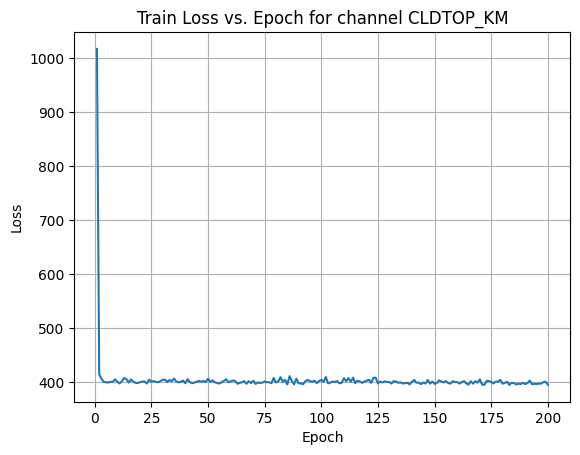

X Channel name :  CAPE
Shapes:  (1324, 80, 80) (332, 80, 80) (1324, 80, 80) (332, 80, 80)
Epoch [1/200] Loss: 1029.8392
Epoch [21/200] Loss: 401.8889
Epoch [41/200] Loss: 399.1993
Epoch [61/200] Loss: 400.2419
Epoch [81/200] Loss: 396.8849
Epoch [101/200] Loss: 395.3639
Epoch [121/200] Loss: 401.5739
Epoch [141/200] Loss: 403.1417
Epoch [161/200] Loss: 402.3704
Epoch [181/200] Loss: 400.0658
Average Test Loss: 361.0597


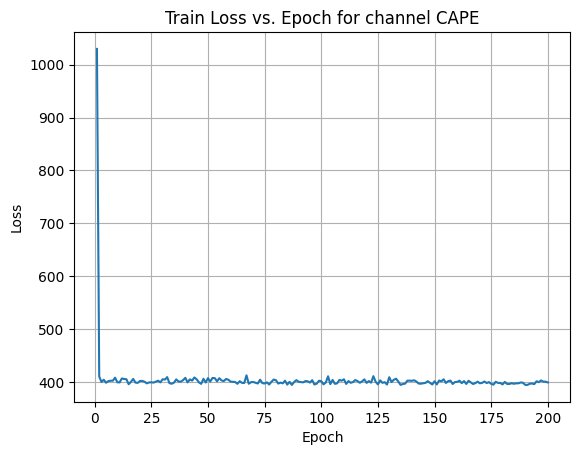

X Channel name :  PBL_WRF_M
Shapes:  (1324, 80, 80) (332, 80, 80) (1324, 80, 80) (332, 80, 80)
Epoch [1/200] Loss: 536.0374
Epoch [21/200] Loss: 401.9832
Epoch [41/200] Loss: 402.4697
Epoch [61/200] Loss: 404.1890
Epoch [81/200] Loss: 400.4949
Epoch [101/200] Loss: 399.0872
Epoch [121/200] Loss: 398.4192
Epoch [141/200] Loss: 400.4667
Epoch [161/200] Loss: 398.1382
Epoch [181/200] Loss: 408.3430
Average Test Loss: 360.3921


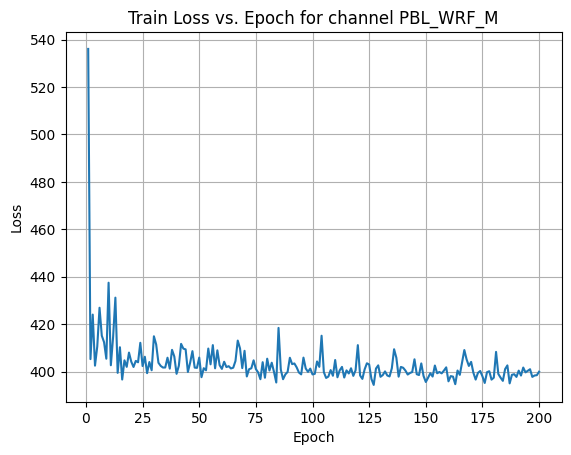

X Channel name :  PBL_YSU_M
Shapes:  (1324, 80, 80) (332, 80, 80) (1324, 80, 80) (332, 80, 80)
Epoch [1/200] Loss: 538.3320
Epoch [21/200] Loss: 405.8272
Epoch [41/200] Loss: 430.2409
Epoch [61/200] Loss: 398.9199
Epoch [81/200] Loss: 404.8572
Epoch [101/200] Loss: 397.2876
Epoch [121/200] Loss: 403.3052
Epoch [141/200] Loss: 401.7307
Epoch [161/200] Loss: 396.1157
Epoch [181/200] Loss: 399.0870
Average Test Loss: 361.4502


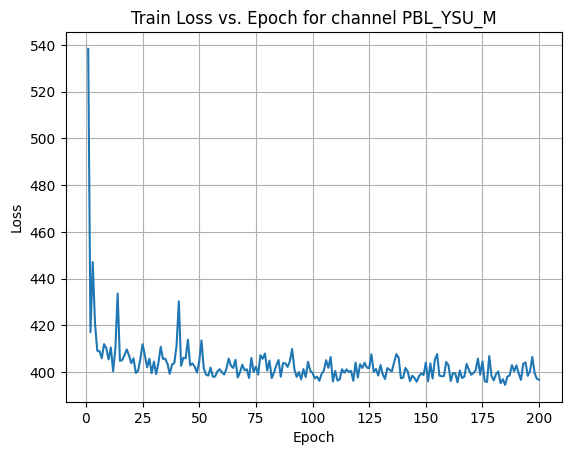

In [ ]:
test_loss_list_P_10 = []
y_channel = 1
# x_channel = 0
for x_channel in range(X.shape[1]):
    ####################### Selecting the channel #######################
    print('X Channel name : ', target_var_96_list[x_channel])
    X_train = X_train_all[:, x_channel, :,:]
    X_test = X_test_all[:, x_channel, :,:]
    y_train = y_train_all[:, y_channel, :,:]
    y_test = y_test_all[:, y_channel, :,:]
    print('Shapes: ', X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    ####################### Creating the dataset loader #######################
    train_custom_dataset = CustomDataset(X_train, y_train)
    # print(len(train_custom_dataset))
    batch_size = 32
    train_loader = data.DataLoader(train_custom_dataset, batch_size=batch_size, shuffle=True)
    # print(len(train_loader))
    
    test_custom_dataset = CustomDataset(X_test, y_test)
    # print(len(test_custom_dataset))
    batch_size = 32
    test_loader = data.DataLoader(test_custom_dataset, batch_size=batch_size, shuffle=False)
    # print(len(test_loader))
    

    #################### Training the model ####################
    model = Autoencoder_MLP()
    model.to(device)
    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    losses = []
    # Training loop
    num_epochs = 200
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        total_loss = 0.0
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()  # Zero the gradients
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Forward pass
            outputs = model(inputs)
            
            # Calculate the loss
            loss = criterion(outputs, targets)
            
            # Backpropagation
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        # Print the average loss for this epoch
        average_loss = total_loss / len(train_loader)
        losses.append(average_loss)
        if epoch % 20 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {average_loss:.4f}")
    
    
    ############################# testing the model #############################
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Calculate the loss
            loss = criterion(outputs, targets)

            test_loss += loss.item()

    # Print the average test loss
    average_test_loss = test_loss / len(test_loader)
    test_loss_list_P_10.append(average_test_loss)
    print(f"Average Test Loss: {average_test_loss:.4f}")
    
    plt.plot(range(1, num_epochs + 1), losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train Loss vs. Epoch for channel '+target_var_96_list[x_channel])
    plt.grid(True) 
    plt.show() 

In [ ]:
test_loss_list_P_10

[401.88824185458094,
 361.23838112571025,
 362.0641340775923,
 361.1262997713956,
 180.2197820490057,
 0.6710819737477736,
 0.6848962740464644,
 360.5232141668146,
 362.6420177112926,
 110.6638252951882,
 361.3054504394531,
 361.05967018821025,
 360.39211342551494,
 361.45016063343394]

In [ ]:
name_loss_pairs = list(zip(target_var_96_list, test_loss_list_P_10))

# Sort based on loss values
sorted_name_loss_pairs = sorted(name_loss_pairs, key=lambda x: x[1])
for pair in sorted_name_loss_pairs:
    print(pair)
# print(sorted_name_loss_pairs)
# Select the lowest 3 names
lowest_3_names = [pair[0] for pair in sorted_name_loss_pairs[:3]]

print("Lowest 3 names:", lowest_3_names)

('U10_MpS', 0.6710819737477736)
('V10_MpS', 0.6848962740464644)
('SOLM_M3pM3', 110.6638252951882)
('CLOUD_OD', 180.2197820490057)
('PBL_WRF_M', 360.39211342551494)
('T2_K', 360.5232141668146)
('CAPE', 361.05967018821025)
('PRATE_MMpH', 361.1262997713956)
('SNOWEW_M', 361.23838112571025)
('CLDTOP_KM', 361.3054504394531)
('PBL_YSU_M', 361.45016063343394)
('SNOWAGE_HR', 362.0641340775923)
('SWSFC_WpM2', 362.6420177112926)
('TSURF_K', 401.88824185458094)
Lowest 3 names: ['U10_MpS', 'V10_MpS', 'SOLM_M3pM3']


## Insights

In [ ]:
# Adding values at corresponding indices
result = [(x + y)/2 for x, y in zip(test_loss_list_P_10, test_loss_list_P_25)]

# Creating a DataFrame
data_frame = {'Input channel': target_var_96_list, 'P10': test_loss_list_P_10, 'P25': test_loss_list_P_25, 'P10+P25 avg': result}
df = pd.DataFrame(data_frame)

# Sorting the DataFrame based on "List1 + List2"
df_sorted = df.sort_values(by='P10+P25 avg')

# Displaying the sorted DataFrame

df_rounded = df_sorted.round(1)
df_rounded.to_csv('/home/rishabh.mondal/climax_alternative/Climax_2/results/test_loss_list_P_10_P25_MLP_auto.csv', index=False)
df_rounded

,Input channel,P10,P25,P10+P25 avg
6,V10_MpS,0.7,0.1,0.4
5,U10_MpS,0.7,0.8,0.7
9,SOLM_M3pM3,110.7,42.1,76.4
4,CLOUD_OD,180.2,9.9,95.1
3,PRATE_MMpH,361.1,189.7,275.4
1,SNOWEW_M,361.2,189.7,275.5
7,T2_K,360.5,191.0,275.8
11,CAPE,361.1,190.9,276.0
2,SNOWAGE_HR,362.1,190.0,276.0
12,PBL_WRF_M,360.4,192.0,276.2


# Autoencoder with convolutional layers

## Model defination

In [ ]:
class Encoder(nn.Module):
    def __init__(self, image_size, num_input_channels, num_output_channels = 1, c_hid = 16, latent_dim = 1024, activation= nn.GELU):
        super(Encoder, self).__init__() 
        self.image_size = image_size
        self.num_input_channels = num_input_channels
        self.num_output_channels = num_output_channels
        self.c_hid = c_hid 
        self.latent_dim = latent_dim
        self.activation = activation
        self.net = nn.Sequential( 
            nn.Conv2d(in_channels=self.num_input_channels, out_channels=self.c_hid, kernel_size=3, stride=2, padding=1),
            self.activation(),
            nn.Conv2d(in_channels=self.c_hid, out_channels=self.c_hid, kernel_size=3, padding=1),
            self.activation(),
            nn.Conv2d(in_channels=self.c_hid, out_channels=2 * self.c_hid, kernel_size=3, stride=2, padding=1),
            self.activation(),
            nn.Conv2d(in_channels=2 * self.c_hid, out_channels=2 * self.c_hid, kernel_size=3, padding=1),
            self.activation(),
            nn.Conv2d(in_channels=2 * self.c_hid, out_channels=4*self.c_hid, kernel_size=3, stride=2, padding=1),
            self.activation(),
            nn.Flatten(),
            nn.Linear((4 * self.c_hid) * self.image_size//8 * self.image_size//8, self.latent_dim)
        ) 
        
    def forward(self, x):
        return self.net(x)

class Decoder(nn.Module):
    def __init__(self, image_size, num_input_channels, num_output_channels = 1,c_hid = 16, latent_dim = 1024, activation= nn.GELU):
        super(Decoder, self).__init__()
        self.image_size = image_size
        self.num_input_channels = num_input_channels
        self.num_output_channels = num_output_channels
        self.c_hid = c_hid
        self.latent_dim = latent_dim
        self.activation = activation

        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, (4 * self.c_hid) * self.image_size//8 * self.image_size//8),
            nn.Unflatten(1, (4*self.c_hid, self.image_size//8, self.image_size//8)),
            nn.ConvTranspose2d(in_channels=4*self.c_hid, out_channels= 2*self.c_hid, kernel_size=3, stride=2, padding=1, output_padding=1),
            self.activation(),
            nn.Conv2d(in_channels = 2*self.c_hid, out_channels= 2*self.c_hid, kernel_size=3, padding=1),
            self.activation(),
            nn.ConvTranspose2d(in_channels = 2*self.c_hid, out_channels = self.c_hid, kernel_size=3, stride=2, padding=1, output_padding=1),
            self.activation(),
            nn.Conv2d(in_channels = self.c_hid,out_channels= self.c_hid, kernel_size=3, padding=1),
            self.activation(),
            nn.ConvTranspose2d(in_channels = self.c_hid, out_channels= self.num_output_channels, kernel_size=3, stride=2, padding=1, output_padding=1),

        )
    def forward(self, x):
        return self.decoder(x)

class Autoencoder_CNN(nn.Module):
    def __init__(self, image_size, num_input_channels, num_output_channels = 1,c_hid = 16, latent_dim = 1024, activation= nn.GELU, encoder = Encoder, decoder = Decoder):
        super(Autoencoder_CNN, self).__init__()
        self.image_size = image_size
        self.num_input_channels = num_input_channels
        self.num_output_channels = num_output_channels
        self.c_hid = c_hid
        self.latent_dim = latent_dim 
        self.activation = activation    
        self.encoder = encoder(self.image_size, self.num_input_channels, self.num_output_channels, self.c_hid, self.latent_dim, self.activation)
        self.decoder = decoder(self.image_size, self.num_input_channels, self.num_output_channels, self.c_hid, self.latent_dim, self.activation)
        
    
    def forward(self, x):
        x = self.encoder(x)
        # print(x.shape)
        x = self.decoder(x)
        return x


In [ ]:
model_auto = Autoencoder_CNN(image_size = 80, num_input_channels = 14, num_output_channels=2, c_hid = 16, latent_dim = 1024, activation= nn.GELU)
model_auto
dummy_input = torch.randn(11, 14, 80, 80)  # Assuming input size of (batch_size, num_num_input_channels, height, width)
out = model_auto(dummy_input)
print(out.shape)    
print(model_auto)

torch.Size([11, 2, 80, 80])
Autoencoder_CNN(
  (encoder): Encoder(
    (net): Sequential(
      (0): Conv2d(14, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): GELU(approximate='none')
      (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): GELU(approximate='none')
      (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): GELU(approximate='none')
      (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): GELU(approximate='none')
      (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (9): GELU(approximate='none')
      (10): Flatten(start_dim=1, end_dim=-1)
      (11): Linear(in_features=6400, out_features=1024, bias=True)
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=1024, out_features=6400, bias=True)
      (1): Unflatten(dim=1, unflattened_size=(64, 10, 10))
      (2): ConvTranspose2d(64, 32, kernel_size=(3

In [ ]:
from torchinfo import summary
summary(model_auto, input_size=(1656, 14, 80, 80))

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder_CNN                          [1656, 2, 80, 80]         --
├─Encoder: 1-1                           [1656, 1024]              --
│    └─Sequential: 2-1                   [1656, 1024]              --
│    │    └─Conv2d: 3-1                  [1656, 16, 40, 40]        2,032
│    │    └─GELU: 3-2                    [1656, 16, 40, 40]        --
│    │    └─Conv2d: 3-3                  [1656, 16, 40, 40]        2,320
│    │    └─GELU: 3-4                    [1656, 16, 40, 40]        --
│    │    └─Conv2d: 3-5                  [1656, 32, 20, 20]        4,640
│    │    └─GELU: 3-6                    [1656, 32, 20, 20]        --
│    │    └─Conv2d: 3-7                  [1656, 32, 20, 20]        9,248
│    │    └─GELU: 3-8                    [1656, 32, 20, 20]        --
│    │    └─Conv2d: 3-9                  [1656, 64, 10, 10]        18,496
│    │    └─GELU: 3-10                   [1656, 64, 10, 10]        --

In [ ]:
from torchsummary import summary
summary(model_auto, input_size=(14, 80, 80)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 40, 40]           2,032
              GELU-2           [-1, 16, 40, 40]               0
            Conv2d-3           [-1, 16, 40, 40]           2,320
              GELU-4           [-1, 16, 40, 40]               0
            Conv2d-5           [-1, 32, 20, 20]           4,640
              GELU-6           [-1, 32, 20, 20]               0
            Conv2d-7           [-1, 32, 20, 20]           9,248
              GELU-8           [-1, 32, 20, 20]               0
            Conv2d-9           [-1, 64, 10, 10]          18,496
             GELU-10           [-1, 64, 10, 10]               0
          Flatten-11                 [-1, 6400]               0
           Linear-12                 [-1, 1024]       6,554,624
          Encoder-13                 [-1, 1024]               0
           Linear-14                 [-

## training on all channel and predicting on all channel

In [ ]:
target_var_96_list =['TSURF_K',
       'SNOWEW_M', 'SNOWAGE_HR', 'PRATE_MMpH', 'CLOUD_OD', 'U10_MpS',
       'V10_MpS', 'T2_K', 'SWSFC_WpM2', 'SOLM_M3pM3', 'CLDTOP_KM', 'CAPE',
       'PBL_WRF_M', 'PBL_YSU_M']  # ['U10_MpS', 'T2_K', 'V10_MpS']
target_var_120_list = ['P25','P10'] 
X,y  = get_data(target_var_96_list, target_var_120_list)

from sklearn.model_selection import train_test_split
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_all.shape, X_test_all.shape, y_train_all.shape, y_test_all.shape

X shape  (1656, 14, 80, 80)
y shape (1656, 2, 80, 80)


((1324, 14, 80, 80), (332, 14, 80, 80), (1324, 2, 80, 80), (332, 2, 80, 80))

(1324, 14, 80, 80) (332, 14, 80, 80) (1324, 2, 80, 80) (332, 2, 80, 80)


Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder_CNN                          [1656, 2, 80, 80]         --
├─Encoder: 1-1                           [1656, 2048]              --
│    └─Sequential: 2-1                   [1656, 2048]              --
│    │    └─Conv2d: 3-1                  [1656, 64, 40, 40]        8,128
│    │    └─GELU: 3-2                    [1656, 64, 40, 40]        --
│    │    └─Conv2d: 3-3                  [1656, 64, 40, 40]        36,928
│    │    └─GELU: 3-4                    [1656, 64, 40, 40]        --
│    │    └─Conv2d: 3-5                  [1656, 128, 20, 20]       73,856
│    │    └─GELU: 3-6                    [1656, 128, 20, 20]       --
│    │    └─Conv2d: 3-7                  [1656, 128, 20, 20]       147,584
│    │    └─GELU: 3-8                    [1656, 128, 20, 20]       --
│    │    └─Conv2d: 3-9                  [1656, 256, 10, 10]       295,168
│    │    └─GELU: 3-10                   [1656, 256, 10, 10]    

  2%|▏         | 1/50 [00:04<04:03,  4.96s/it]

Epoch [1/50] Loss: 1620.3361
Average Test Loss: 377.9475


 22%|██▏       | 11/50 [00:58<03:15,  5.00s/it]

Epoch [11/50] Loss: 249.2443
Average Test Loss: 228.7919


 42%|████▏     | 21/50 [01:33<01:40,  3.45s/it]

Epoch [21/50] Loss: 168.6332
Average Test Loss: 172.4825


 62%|██████▏   | 31/50 [02:21<01:14,  3.90s/it]

Epoch [31/50] Loss: 102.0034
Average Test Loss: 111.1758


 80%|████████  | 40/50 [02:49<00:32,  3.22s/it]

Epoch [41/50] Loss: 65.1520


 82%|████████▏ | 41/50 [02:53<00:30,  3.39s/it]

Average Test Loss: 60.7862


100%|██████████| 50/50 [03:30<00:00,  4.22s/it]


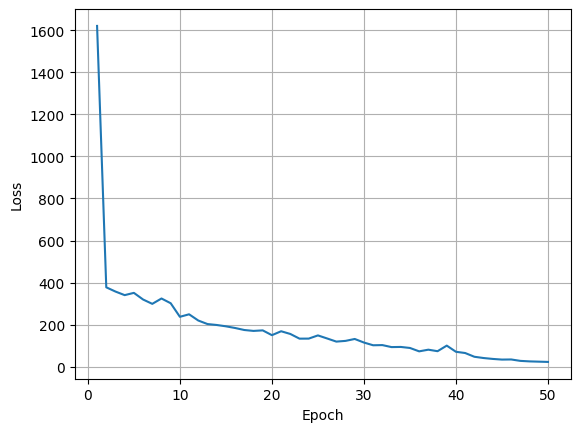

In [ ]:
print(X_train_all.shape, X_test_all.shape, y_train_all.shape, y_test_all.shape)
train_custom_dataset = CustomDataset(X_train_all, y_train_all)
# print(len(train_custom_dataset))
batch_size = 32
train_loader = data.DataLoader(train_custom_dataset, batch_size=batch_size, shuffle=True)
# print(len(train_loader))

test_custom_dataset = CustomDataset(X_test_all, y_test_all)
# print(len(test_custom_dataset))
batch_size = 32
test_loader = data.DataLoader(test_custom_dataset, batch_size=batch_size, shuffle=False)
# print(len(test_loader))


#################### Training the model ####################
model = Autoencoder_CNN(image_size = 80, num_input_channels = 14, num_output_channels=2, c_hid = 64, latent_dim = 2048, activation= nn.GELU)
model.to(device) 
from torchinfo import summary
print(summary(model, input_size=(1656, 14, 80, 80)))
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
losses = [] 
# Training loop
num_epochs = 50 #200
for epoch in trange(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0.0
    
    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        inputs = inputs.to(device)
        targets = targets.to(device)
        # Forward pass
        outputs = model(inputs)
        
        # Calculate the loss
        loss = criterion(outputs, targets)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    # Print the average loss for this epoch
    average_loss = total_loss / len(train_loader)
    losses.append(average_loss)
    if epoch % 10 == 0: 
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {average_loss:.4f}")

############################# testing the model #############################
        model.eval()  # Set the model to evaluation mode
        test_loss = 0.0

        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                # Forward pass
                outputs = model(inputs)

                # Calculate the loss
                loss = criterion(outputs, targets)

                test_loss += loss.item()

        # Print the average test loss
        average_test_loss = test_loss / len(test_loader)
        # test_loss_list_P_25.append(average_test_loss)
        print(f"Average Test Loss: {average_test_loss:.4f}")

plt.plot(range(1, num_epochs + 1), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.title('Train Loss vs. Epoch for channel '+target_var_96_list[x_channel])
plt.grid(True) 
plt.show() 

In [ ]:
model.eval()  # Set the model to evaluation mode
test_loss = 0.0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, targets)

        test_loss += loss.item()

# Print the average test loss
average_test_loss = test_loss / len(test_loader)
# test_loss_list_P_25.append(average_test_loss)
print(f"Average Test Loss: {average_test_loss:.4f}")


Average Test Loss: 20.4597


In [ ]:
torch.save(model.state_dict(), 'model/auto_conv_in14_out2.pt')
model = Autoencoder_CNN(image_size = 80, num_input_channels = 14, num_output_channels=2, c_hid = 64, latent_dim = 2048, activation= nn.GELU)
model.to(device) 
model.load_state_dict(torch.load('model/auto_conv_in14_out2.pt'))

<All keys matched successfully>

## Single channel input single channel output (P25)

In [ ]:
target_var_96_list =['TSURF_K',
       'SNOWEW_M', 'SNOWAGE_HR', 'PRATE_MMpH', 'CLOUD_OD', 'U10_MpS',
       'V10_MpS', 'T2_K', 'SWSFC_WpM2', 'SOLM_M3pM3', 'CLDTOP_KM', 'CAPE',
       'PBL_WRF_M', 'PBL_YSU_M']  # ['U10_MpS', 'T2_K', 'V10_MpS']
target_var_120_list = ['P25','P10'] 
X,y  = get_data(target_var_96_list, target_var_120_list)

from sklearn.model_selection import train_test_split
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_all.shape, X_test_all.shape, y_train_all.shape, y_test_all.shape

X shape  (1656, 14, 80, 80)
y shape (1656, 2, 80, 80)


((1324, 14, 80, 80), (332, 14, 80, 80), (1324, 2, 80, 80), (332, 2, 80, 80))

X Channel name :  TSURF_K
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<02:14,  1.48it/s]

Epoch [1/200] Loss: 462.4725


 10%|█         | 21/200 [00:06<00:52,  3.42it/s]

Epoch [21/200] Loss: 212.0043


 20%|██        | 41/200 [00:12<00:48,  3.29it/s]

Epoch [41/200] Loss: 213.3173


 30%|███       | 61/200 [00:18<00:40,  3.41it/s]

Epoch [61/200] Loss: 234.0997


 40%|████      | 81/200 [00:24<00:34,  3.43it/s]

Epoch [81/200] Loss: 211.7991


 50%|█████     | 101/200 [00:30<00:29,  3.39it/s]

Epoch [101/200] Loss: 216.9750


 60%|██████    | 121/200 [00:35<00:23,  3.42it/s]

Epoch [121/200] Loss: 211.1435


 70%|███████   | 141/200 [00:41<00:17,  3.46it/s]

Epoch [141/200] Loss: 214.2518


 80%|████████  | 161/200 [00:47<00:11,  3.45it/s]

Epoch [161/200] Loss: 209.3667


 90%|█████████ | 181/200 [00:53<00:05,  3.44it/s]

Epoch [181/200] Loss: 208.2786


100%|██████████| 200/200 [00:58<00:00,  3.39it/s]


Average Test Loss: 196.8076


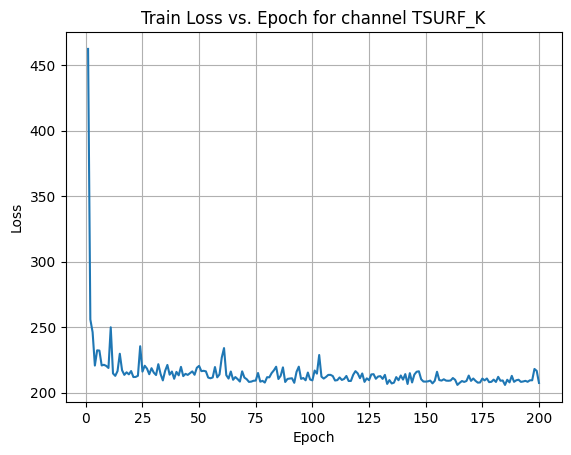

X Channel name :  SNOWEW_M
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<00:58,  3.37it/s]

Epoch [1/200] Loss: 540.4606


 10%|█         | 21/200 [00:06<00:52,  3.44it/s]

Epoch [21/200] Loss: 216.1673


 20%|██        | 41/200 [00:12<00:47,  3.35it/s]

Epoch [41/200] Loss: 211.7699


 30%|███       | 61/200 [00:17<00:40,  3.39it/s]

Epoch [61/200] Loss: 211.9133


 40%|████      | 81/200 [00:23<00:34,  3.40it/s]

Epoch [81/200] Loss: 214.4790


 50%|█████     | 101/200 [00:29<00:29,  3.39it/s]

Epoch [101/200] Loss: 212.5737


 60%|██████    | 121/200 [00:35<00:23,  3.38it/s]

Epoch [121/200] Loss: 212.8330


 70%|███████   | 141/200 [00:41<00:17,  3.44it/s]

Epoch [141/200] Loss: 209.0824


 80%|████████  | 161/200 [00:47<00:11,  3.41it/s]

Epoch [161/200] Loss: 207.7827


 90%|█████████ | 181/200 [00:53<00:05,  3.44it/s]

Epoch [181/200] Loss: 208.2993


100%|██████████| 200/200 [00:58<00:00,  3.42it/s]

Average Test Loss: 191.6095


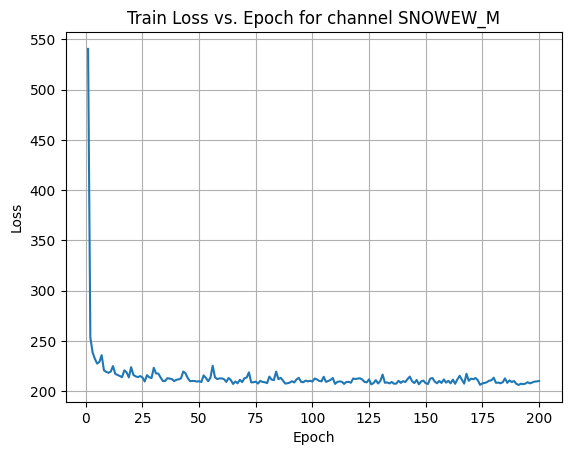

X Channel name :  SNOWAGE_HR
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<00:57,  3.49it/s]

Epoch [1/200] Loss: 590.1837


 10%|█         | 21/200 [00:06<00:52,  3.43it/s]

Epoch [21/200] Loss: 211.4096


 20%|██        | 41/200 [00:11<00:46,  3.42it/s]

Epoch [41/200] Loss: 213.1281


 30%|███       | 61/200 [00:17<00:40,  3.45it/s]

Epoch [61/200] Loss: 208.5330


 40%|████      | 81/200 [00:23<00:33,  3.58it/s]

Epoch [81/200] Loss: 209.0068


 50%|█████     | 101/200 [00:28<00:27,  3.61it/s]

Epoch [101/200] Loss: 211.9243


 60%|██████    | 121/200 [00:34<00:21,  3.60it/s]

Epoch [121/200] Loss: 212.2428


 70%|███████   | 141/200 [00:40<00:16,  3.48it/s]

Epoch [141/200] Loss: 210.3188


 80%|████████  | 161/200 [00:46<00:11,  3.40it/s]

Epoch [161/200] Loss: 211.6509


 90%|█████████ | 181/200 [00:51<00:05,  3.43it/s]

Epoch [181/200] Loss: 212.8352


100%|██████████| 200/200 [00:57<00:00,  3.47it/s]

Average Test Loss: 191.7548


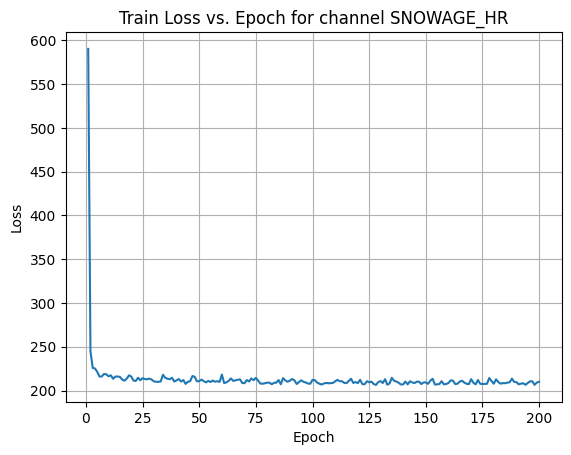

X Channel name :  PRATE_MMpH
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<00:56,  3.52it/s]

Epoch [1/200] Loss: 750.4891


 10%|█         | 21/200 [00:06<00:52,  3.44it/s]

Epoch [21/200] Loss: 213.9414


 20%|██        | 41/200 [00:12<00:46,  3.39it/s]

Epoch [41/200] Loss: 214.3703


 30%|███       | 61/200 [00:17<00:41,  3.38it/s]

Epoch [61/200] Loss: 209.9882


 40%|████      | 81/200 [00:23<00:34,  3.43it/s]

Epoch [81/200] Loss: 210.4570


 50%|█████     | 101/200 [00:29<00:29,  3.37it/s]

Epoch [101/200] Loss: 211.3801


 60%|██████    | 121/200 [00:35<00:21,  3.76it/s]

Epoch [121/200] Loss: 214.6792


 70%|███████   | 141/200 [00:41<00:17,  3.42it/s]

Epoch [141/200] Loss: 210.8055


 80%|████████  | 161/200 [00:47<00:11,  3.41it/s]

Epoch [161/200] Loss: 214.0414


 90%|█████████ | 181/200 [00:52<00:05,  3.61it/s]

Epoch [181/200] Loss: 206.5140


100%|██████████| 200/200 [00:58<00:00,  3.45it/s]

Average Test Loss: 194.9402


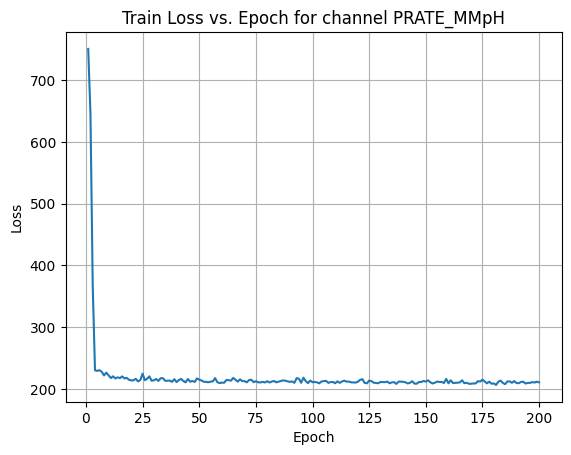

X Channel name :  CLOUD_OD
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<00:54,  3.63it/s]

Epoch [1/200] Loss: 563.3871


 10%|█         | 21/200 [00:05<00:46,  3.82it/s]

Epoch [21/200] Loss: 63.2729


 20%|██        | 41/200 [00:11<00:45,  3.51it/s]

Epoch [41/200] Loss: 23.8580


 30%|███       | 61/200 [00:17<00:40,  3.42it/s]

Epoch [61/200] Loss: 15.2393


 40%|████      | 81/200 [00:23<00:37,  3.14it/s]

Epoch [81/200] Loss: 11.0129


 50%|█████     | 101/200 [00:29<00:29,  3.32it/s]

Epoch [101/200] Loss: 9.3018


 60%|██████    | 121/200 [00:35<00:22,  3.45it/s]

Epoch [121/200] Loss: 8.1090


 70%|███████   | 141/200 [00:41<00:17,  3.40it/s]

Epoch [141/200] Loss: 7.4336


 80%|████████  | 161/200 [00:47<00:11,  3.38it/s]

Epoch [161/200] Loss: 8.8601


 90%|█████████ | 181/200 [00:53<00:05,  3.42it/s]

Epoch [181/200] Loss: 6.1420


100%|██████████| 200/200 [00:58<00:00,  3.40it/s]

Average Test Loss: 7.4988


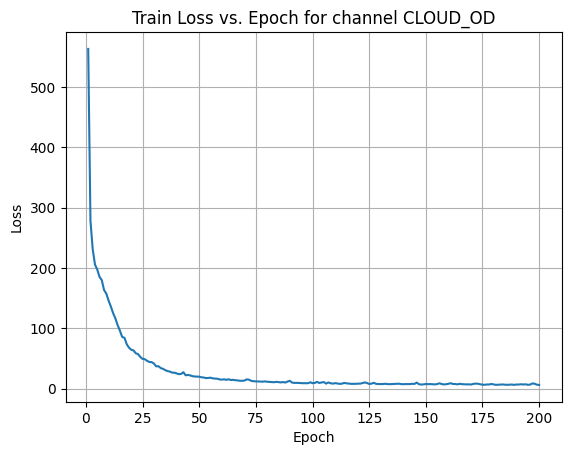

X Channel name :  U10_MpS
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<00:57,  3.48it/s]

Epoch [1/200] Loss: 684.8967


 10%|█         | 21/200 [00:06<00:52,  3.41it/s]

Epoch [21/200] Loss: 111.6166


 20%|██        | 41/200 [00:11<00:46,  3.41it/s]

Epoch [41/200] Loss: 22.6558


 30%|███       | 61/200 [00:17<00:40,  3.41it/s]

Epoch [61/200] Loss: 10.9635


 40%|████      | 81/200 [00:23<00:35,  3.40it/s]

Epoch [81/200] Loss: 12.9050


 50%|█████     | 101/200 [00:29<00:29,  3.38it/s]

Epoch [101/200] Loss: 6.2923


 60%|██████    | 121/200 [00:35<00:23,  3.40it/s]

Epoch [121/200] Loss: 9.0327


 70%|███████   | 141/200 [00:41<00:16,  3.49it/s]

Epoch [141/200] Loss: 4.1764


 80%|████████  | 161/200 [00:47<00:11,  3.52it/s]

Epoch [161/200] Loss: 3.8160


 90%|█████████ | 181/200 [00:52<00:05,  3.57it/s]

Epoch [181/200] Loss: 3.3957


100%|██████████| 200/200 [00:57<00:00,  3.46it/s]

Average Test Loss: 3.1739


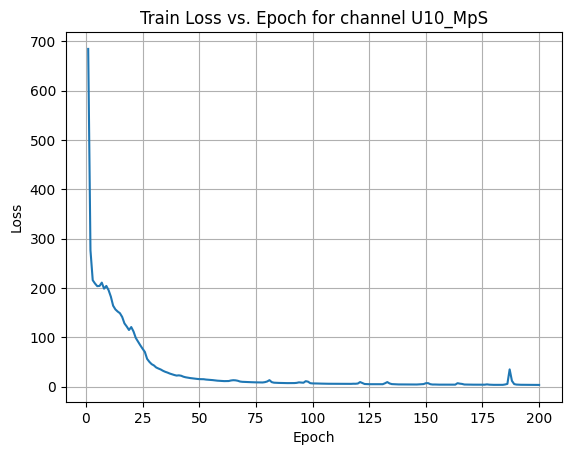

X Channel name :  V10_MpS
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<00:56,  3.51it/s]

Epoch [1/200] Loss: 609.8626


 10%|█         | 21/200 [00:06<00:53,  3.34it/s]

Epoch [21/200] Loss: 58.6357


 20%|██        | 41/200 [00:12<00:46,  3.40it/s]

Epoch [41/200] Loss: 14.3107


 30%|███       | 61/200 [00:18<00:41,  3.37it/s]

Epoch [61/200] Loss: 10.6218


 40%|████      | 81/200 [00:23<00:35,  3.39it/s]

Epoch [81/200] Loss: 6.9871


 50%|█████     | 101/200 [00:29<00:29,  3.39it/s]

Epoch [101/200] Loss: 5.3444


 60%|██████    | 121/200 [00:35<00:23,  3.39it/s]

Epoch [121/200] Loss: 4.6127


 70%|███████   | 141/200 [00:41<00:17,  3.43it/s]

Epoch [141/200] Loss: 4.0642


 80%|████████  | 161/200 [00:47<00:11,  3.43it/s]

Epoch [161/200] Loss: 3.5636


 90%|█████████ | 181/200 [00:53<00:05,  3.42it/s]

Epoch [181/200] Loss: 3.2190


100%|██████████| 200/200 [00:58<00:00,  3.40it/s]

Average Test Loss: 2.9050


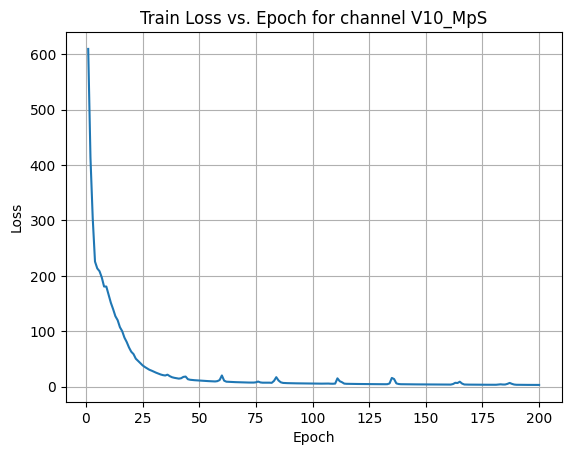

X Channel name :  T2_K
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<00:57,  3.45it/s]

Epoch [1/200] Loss: 458.4550


 10%|█         | 21/200 [00:06<00:52,  3.41it/s]

Epoch [21/200] Loss: 213.3441


 20%|██        | 41/200 [00:11<00:47,  3.38it/s]

Epoch [41/200] Loss: 211.7652


 30%|███       | 61/200 [00:17<00:41,  3.39it/s]

Epoch [61/200] Loss: 212.4970


 40%|████      | 81/200 [00:23<00:35,  3.38it/s]

Epoch [81/200] Loss: 210.7104


 50%|█████     | 101/200 [00:29<00:28,  3.52it/s]

Epoch [101/200] Loss: 208.7177


 60%|██████    | 121/200 [00:35<00:22,  3.44it/s]

Epoch [121/200] Loss: 212.2414


 70%|███████   | 141/200 [00:41<00:17,  3.47it/s]

Epoch [141/200] Loss: 207.2175


 80%|████████  | 161/200 [00:46<00:11,  3.43it/s]

Epoch [161/200] Loss: 211.3121


 90%|█████████ | 181/200 [00:52<00:05,  3.42it/s]

Epoch [181/200] Loss: 208.7926


100%|██████████| 200/200 [00:58<00:00,  3.42it/s]


Average Test Loss: 191.9081


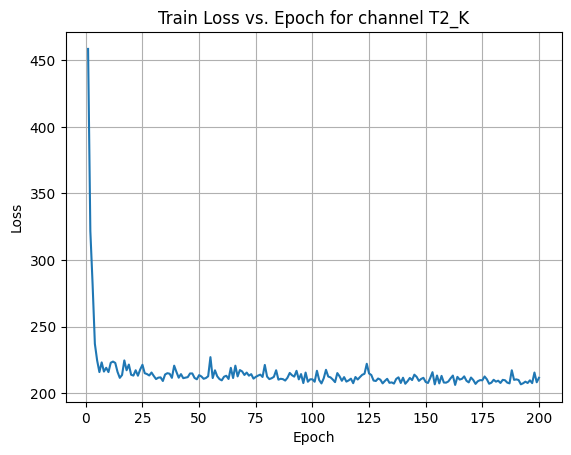

X Channel name :  SWSFC_WpM2
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<00:56,  3.52it/s]

Epoch [1/200] Loss: 760.0155


 10%|█         | 21/200 [00:06<00:53,  3.37it/s]

Epoch [21/200] Loss: 224.7744


 20%|██        | 41/200 [00:12<00:47,  3.38it/s]

Epoch [41/200] Loss: 215.4670


 30%|███       | 61/200 [00:18<00:41,  3.35it/s]

Epoch [61/200] Loss: 214.6593


 40%|████      | 81/200 [00:24<00:35,  3.37it/s]

Epoch [81/200] Loss: 211.3864


 50%|█████     | 101/200 [00:29<00:28,  3.43it/s]

Epoch [101/200] Loss: 214.5846


 60%|██████    | 121/200 [00:35<00:23,  3.38it/s]

Epoch [121/200] Loss: 215.2816


 70%|███████   | 141/200 [00:41<00:17,  3.32it/s]

Epoch [141/200] Loss: 210.3355


 80%|████████  | 161/200 [00:47<00:11,  3.49it/s]

Epoch [161/200] Loss: 213.1056


 90%|█████████ | 181/200 [00:53<00:05,  3.41it/s]

Epoch [181/200] Loss: 209.3009


100%|██████████| 200/200 [00:59<00:00,  3.38it/s]


Average Test Loss: 193.2200


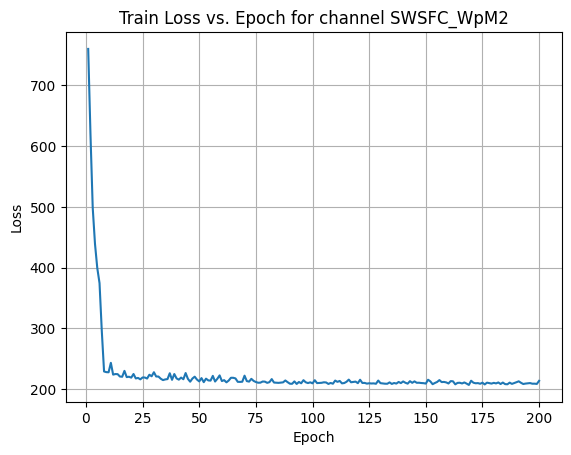

X Channel name :  SOLM_M3pM3
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<00:58,  3.42it/s]

Epoch [1/200] Loss: 518.8583


 10%|█         | 21/200 [00:06<00:51,  3.46it/s]

Epoch [21/200] Loss: 183.2842


 20%|██        | 41/200 [00:12<00:51,  3.10it/s]

Epoch [41/200] Loss: 106.5493


 30%|███       | 61/200 [00:18<00:41,  3.35it/s]

Epoch [61/200] Loss: 47.8360


 40%|████      | 81/200 [00:24<00:35,  3.39it/s]

Epoch [81/200] Loss: 17.4837


 50%|█████     | 101/200 [00:30<00:30,  3.28it/s]

Epoch [101/200] Loss: 12.6859


 60%|██████    | 121/200 [00:36<00:23,  3.31it/s]

Epoch [121/200] Loss: 9.7521


 70%|███████   | 141/200 [00:42<00:17,  3.30it/s]

Epoch [141/200] Loss: 8.4768


 80%|████████  | 161/200 [00:47<00:11,  3.46it/s]

Epoch [161/200] Loss: 7.1218


 90%|█████████ | 181/200 [00:53<00:05,  3.44it/s]

Epoch [181/200] Loss: 7.4880


100%|██████████| 200/200 [00:58<00:00,  3.40it/s]

Average Test Loss: 5.5514


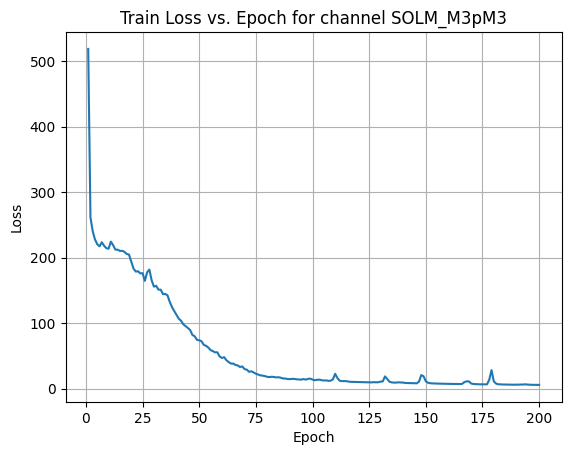

X Channel name :  CLDTOP_KM
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<00:57,  3.43it/s]

Epoch [1/200] Loss: 603.6223


 10%|█         | 21/200 [00:06<00:52,  3.41it/s]

Epoch [21/200] Loss: 216.0129


 20%|██        | 41/200 [00:12<00:50,  3.18it/s]

Epoch [41/200] Loss: 212.5011


 30%|███       | 61/200 [00:18<00:41,  3.35it/s]

Epoch [61/200] Loss: 215.2624


 40%|████      | 81/200 [00:24<00:35,  3.38it/s]

Epoch [81/200] Loss: 210.4688


 50%|█████     | 101/200 [00:30<00:29,  3.40it/s]

Epoch [101/200] Loss: 211.2793


 60%|██████    | 121/200 [00:35<00:23,  3.35it/s]

Epoch [121/200] Loss: 208.5935


 70%|███████   | 141/200 [00:41<00:17,  3.38it/s]

Epoch [141/200] Loss: 209.1620


 80%|████████  | 161/200 [00:47<00:11,  3.42it/s]

Epoch [161/200] Loss: 208.9249


 90%|█████████ | 181/200 [00:53<00:05,  3.41it/s]

Epoch [181/200] Loss: 207.8753


100%|██████████| 200/200 [00:59<00:00,  3.38it/s]

Average Test Loss: 205.4745


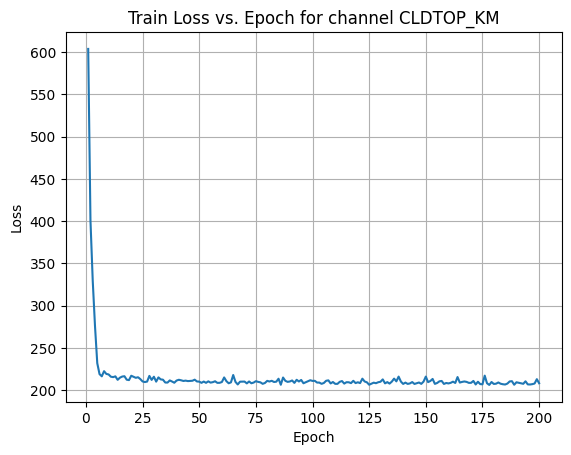

X Channel name :  CAPE
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<00:58,  3.39it/s]

Epoch [1/200] Loss: 480.7086


 10%|█         | 21/200 [00:06<00:52,  3.39it/s]

Epoch [21/200] Loss: 215.4105


 20%|██        | 41/200 [00:12<00:46,  3.41it/s]

Epoch [41/200] Loss: 211.5271


 30%|███       | 61/200 [00:17<00:40,  3.39it/s]

Epoch [61/200] Loss: 211.8129


 40%|████      | 81/200 [00:23<00:35,  3.40it/s]

Epoch [81/200] Loss: 208.5153


 50%|█████     | 101/200 [00:29<00:28,  3.44it/s]

Epoch [101/200] Loss: 208.6479


 60%|██████    | 121/200 [00:35<00:23,  3.39it/s]

Epoch [121/200] Loss: 215.5420


 70%|███████   | 141/200 [00:41<00:17,  3.44it/s]

Epoch [141/200] Loss: 207.9001


 80%|████████  | 161/200 [00:47<00:11,  3.45it/s]

Epoch [161/200] Loss: 206.7139


 90%|█████████ | 181/200 [00:53<00:05,  3.41it/s]

Epoch [181/200] Loss: 208.8671


100%|██████████| 200/200 [00:58<00:00,  3.41it/s]

Average Test Loss: 191.5815


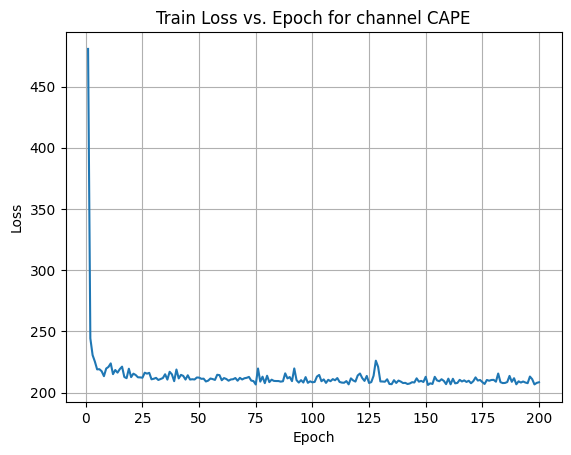

X Channel name :  PBL_WRF_M
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<00:57,  3.44it/s]

Epoch [1/200] Loss: 487.6684


 10%|█         | 21/200 [00:06<00:53,  3.33it/s]

Epoch [21/200] Loss: 210.6665


 20%|██        | 41/200 [00:12<00:46,  3.40it/s]

Epoch [41/200] Loss: 211.8588


 30%|███       | 61/200 [00:18<00:41,  3.38it/s]

Epoch [61/200] Loss: 209.3883


 40%|████      | 81/200 [00:24<00:35,  3.36it/s]

Epoch [81/200] Loss: 210.8873


 50%|█████     | 101/200 [00:29<00:29,  3.39it/s]

Epoch [101/200] Loss: 209.3165


 60%|██████    | 121/200 [00:35<00:23,  3.36it/s]

Epoch [121/200] Loss: 208.2383


 70%|███████   | 141/200 [00:41<00:17,  3.40it/s]

Epoch [141/200] Loss: 208.4831


 80%|████████  | 161/200 [00:47<00:11,  3.37it/s]

Epoch [161/200] Loss: 209.2067


 90%|█████████ | 181/200 [00:53<00:05,  3.35it/s]

Epoch [181/200] Loss: 207.0104


100%|██████████| 200/200 [00:59<00:00,  3.37it/s]

Average Test Loss: 190.8408


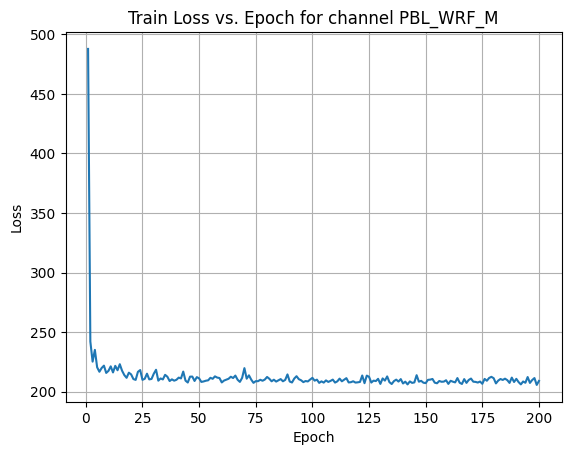

X Channel name :  PBL_YSU_M
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<00:58,  3.43it/s]

Epoch [1/200] Loss: 538.0652


 10%|█         | 21/200 [00:06<00:53,  3.38it/s]

Epoch [21/200] Loss: 213.2395


 20%|██        | 41/200 [00:12<00:46,  3.40it/s]

Epoch [41/200] Loss: 209.5626


 30%|███       | 61/200 [00:18<00:40,  3.41it/s]

Epoch [61/200] Loss: 218.8836


 40%|████      | 81/200 [00:23<00:34,  3.44it/s]

Epoch [81/200] Loss: 213.1157


 50%|█████     | 101/200 [00:29<00:28,  3.42it/s]

Epoch [101/200] Loss: 211.7407


 60%|██████    | 121/200 [00:35<00:23,  3.39it/s]

Epoch [121/200] Loss: 214.4044


 70%|███████   | 141/200 [00:41<00:17,  3.40it/s]

Epoch [141/200] Loss: 209.6131


 80%|████████  | 161/200 [00:47<00:11,  3.39it/s]

Epoch [161/200] Loss: 209.1906


 90%|█████████ | 181/200 [00:53<00:05,  3.39it/s]

Epoch [181/200] Loss: 207.2547


100%|██████████| 200/200 [00:58<00:00,  3.39it/s]

Average Test Loss: 196.5285


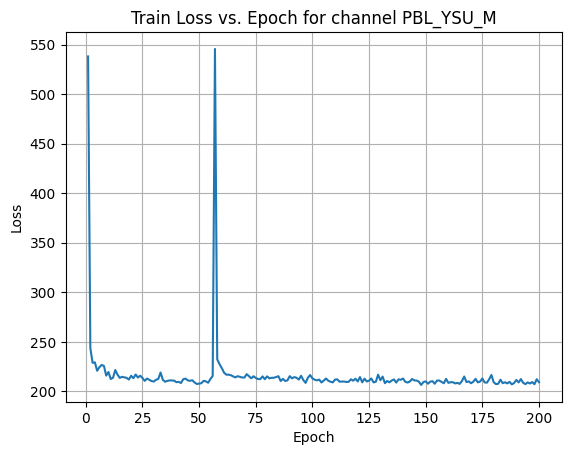

In [ ]:
test_loss_list_P_25_conv_auto = []
y_channel = 0 # selecting P25 as output
# x_channel = 0
for x_channel in range(X.shape[1]):
    ####################### Selecting the channel #######################
    print('X Channel name : ', target_var_96_list[x_channel])
    X_train = X_train_all[:, x_channel:x_channel+1, :,:]
    X_test = X_test_all[:, x_channel:x_channel+1, :,:]
    y_train = y_train_all[:, y_channel:y_channel+1, :,:]
    y_test = y_test_all[:, y_channel:y_channel+1, :,:]
    print('Shapes: ', X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    ####################### Creating the dataset loader #######################
    train_custom_dataset = CustomDataset(X_train, y_train)
    # print(len(train_custom_dataset))
    batch_size = 32
    train_loader = data.DataLoader(train_custom_dataset, batch_size=batch_size, shuffle=True)
    # print(len(train_loader))
    
    test_custom_dataset = CustomDataset(X_test, y_test)
    # print(len(test_custom_dataset))
    batch_size = 32
    test_loader = data.DataLoader(test_custom_dataset, batch_size=batch_size, shuffle=False)
    # print(len(test_loader))
    

    #################### Training the model ####################
    model = Autoencoder_CNN(image_size = 80, num_input_channels = 1, num_output_channels=1, c_hid = 8, latent_dim = 512, activation= nn.GELU)
    model.to(device)
    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    losses = []
    # Training loop
    num_epochs = 200
    for epoch in trange(num_epochs):
        model.train()  # Set the model to training mode
        total_loss = 0.0
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()  # Zero the gradients
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Forward pass
            outputs = model(inputs)
            
            # Calculate the loss
            loss = criterion(outputs, targets)
            
            # Backpropagation
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        # Print the average loss for this epoch
        average_loss = total_loss / len(train_loader)
        losses.append(average_loss)
        if epoch % 20 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {average_loss:.4f}")
    
    ############################# testing the model #############################
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Forward pass
            outputs = model(inputs)
            # Calculate the loss
            loss = criterion(outputs, targets)
            test_loss += loss.item()

    # Print the average test loss
    average_test_loss = test_loss / len(test_loader)
    test_loss_list_P_25_conv_auto.append(average_test_loss)
    print(f"Average Test Loss: {average_test_loss:.4f}")
    plt.plot(range(1, num_epochs + 1), losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train Loss vs. Epoch for channel '+target_var_96_list[x_channel])
    plt.grid(True) 
    plt.show() 

In [ ]:
test_loss_list_P_25_conv_auto

[196.80755892666903,
 191.6094970703125,
 191.75477183948863,
 194.94017861106178,
 7.4987756772474805,
 3.1738592061129483,
 2.9050224044106225,
 191.90811157226562,
 193.21996238014916,
 5.551396109841087,
 205.47452198375356,
 191.58150828968394,
 190.84084944291547,
 196.5285311612216]

In [ ]:
name_loss_pairs = list(zip(target_var_96_list, test_loss_list_P_25_conv_auto))

# Sort based on loss values
sorted_name_loss_pairs = sorted(name_loss_pairs, key=lambda x: x[1])
for pair in sorted_name_loss_pairs:
    print(pair)
# print(sorted_name_loss_pairs)
# Select the lowest 3 names
lowest_3_names = [pair[0] for pair in sorted_name_loss_pairs[:3]]

print("Lowest 3 names:", lowest_3_names)

('V10_MpS', 2.9050224044106225)
('U10_MpS', 3.1738592061129483)
('SOLM_M3pM3', 5.551396109841087)
('CLOUD_OD', 7.4987756772474805)
('PBL_WRF_M', 190.84084944291547)
('CAPE', 191.58150828968394)
('SNOWEW_M', 191.6094970703125)
('SNOWAGE_HR', 191.75477183948863)
('T2_K', 191.90811157226562)
('SWSFC_WpM2', 193.21996238014916)
('PRATE_MMpH', 194.94017861106178)
('PBL_YSU_M', 196.5285311612216)
('TSURF_K', 196.80755892666903)
('CLDTOP_KM', 205.47452198375356)
Lowest 3 names: ['V10_MpS', 'U10_MpS', 'SOLM_M3pM3']


In [ ]:
summary(model, input_size=(1000, 1, 80, 80))

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder_CNN                          [1000, 1, 80, 80]         --
├─Encoder: 1-1                           [1000, 512]               --
│    └─Sequential: 2-1                   [1000, 512]               --
│    │    └─Conv2d: 3-1                  [1000, 8, 40, 40]         80
│    │    └─GELU: 3-2                    [1000, 8, 40, 40]         --
│    │    └─Conv2d: 3-3                  [1000, 8, 40, 40]         584
│    │    └─GELU: 3-4                    [1000, 8, 40, 40]         --
│    │    └─Conv2d: 3-5                  [1000, 16, 20, 20]        1,168
│    │    └─GELU: 3-6                    [1000, 16, 20, 20]        --
│    │    └─Conv2d: 3-7                  [1000, 16, 20, 20]        2,320
│    │    └─GELU: 3-8                    [1000, 16, 20, 20]        --
│    │    └─Conv2d: 3-9                  [1000, 32, 10, 10]        4,640
│    │    └─GELU: 3-10                   [1000, 32, 10, 10]        --
│    

## Single channel input multiple channel output (P10)

X Channel name :  TSURF_K
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<01:02,  3.18it/s]

Epoch [1/200] Loss: 831.9463


 10%|█         | 21/200 [00:06<00:52,  3.39it/s]

Epoch [21/200] Loss: 413.6695


 20%|██        | 41/200 [00:12<00:46,  3.39it/s]

Epoch [41/200] Loss: 416.1795


 30%|███       | 61/200 [00:17<00:40,  3.40it/s]

Epoch [61/200] Loss: 414.0692


 40%|████      | 81/200 [00:23<00:35,  3.40it/s]

Epoch [81/200] Loss: 408.8671


 50%|█████     | 101/200 [00:29<00:28,  3.45it/s]

Epoch [101/200] Loss: 408.6212


 60%|██████    | 121/200 [00:35<00:22,  3.44it/s]

Epoch [121/200] Loss: 408.1124


 70%|███████   | 141/200 [00:41<00:17,  3.39it/s]

Epoch [141/200] Loss: 407.2696


 80%|████████  | 161/200 [00:47<00:11,  3.40it/s]

Epoch [161/200] Loss: 419.0648


 90%|█████████ | 181/200 [00:53<00:05,  3.42it/s]

Epoch [181/200] Loss: 411.9767


100%|██████████| 200/200 [00:58<00:00,  3.41it/s]

Average Test Loss: 367.9784


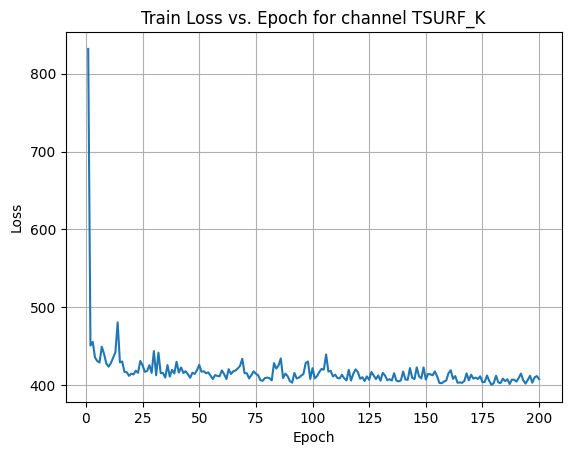

X Channel name :  SNOWEW_M
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<00:58,  3.38it/s]

Epoch [1/200] Loss: 1193.0016


 10%|█         | 21/200 [00:06<00:52,  3.38it/s]

Epoch [21/200] Loss: 413.8656


 20%|██        | 41/200 [00:12<00:46,  3.40it/s]

Epoch [41/200] Loss: 416.9739


 30%|███       | 61/200 [00:17<00:41,  3.38it/s]

Epoch [61/200] Loss: 405.7197


 40%|████      | 81/200 [00:23<00:35,  3.40it/s]

Epoch [81/200] Loss: 414.4462


 50%|█████     | 101/200 [00:29<00:28,  3.44it/s]

Epoch [101/200] Loss: 403.9555


 60%|██████    | 121/200 [00:35<00:23,  3.35it/s]

Epoch [121/200] Loss: 406.6566


 70%|███████   | 141/200 [00:41<00:17,  3.38it/s]

Epoch [141/200] Loss: 404.8177


 80%|████████  | 161/200 [00:47<00:11,  3.36it/s]

Epoch [161/200] Loss: 414.5372


 90%|█████████ | 181/200 [00:53<00:05,  3.19it/s]

Epoch [181/200] Loss: 418.9334


100%|██████████| 200/200 [00:59<00:00,  3.36it/s]

Average Test Loss: 373.6601


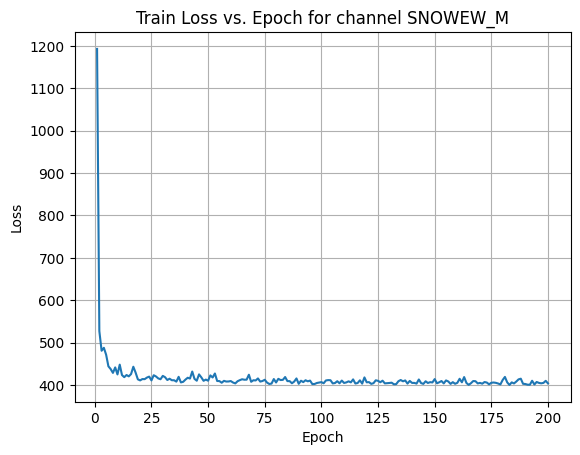

X Channel name :  SNOWAGE_HR
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<00:57,  3.48it/s]

Epoch [1/200] Loss: 1176.4868


 10%|█         | 21/200 [00:06<00:52,  3.43it/s]

Epoch [21/200] Loss: 410.2950


 20%|██        | 41/200 [00:12<00:47,  3.37it/s]

Epoch [41/200] Loss: 414.8993


 30%|███       | 61/200 [00:17<00:40,  3.41it/s]

Epoch [61/200] Loss: 405.8627


 40%|████      | 81/200 [00:23<00:34,  3.43it/s]

Epoch [81/200] Loss: 416.4907


 50%|█████     | 101/200 [00:29<00:28,  3.42it/s]

Epoch [101/200] Loss: 413.8539


 60%|██████    | 121/200 [00:35<00:23,  3.39it/s]

Epoch [121/200] Loss: 406.4541


 70%|███████   | 141/200 [00:41<00:17,  3.36it/s]

Epoch [141/200] Loss: 404.2276


 80%|████████  | 161/200 [00:47<00:11,  3.38it/s]

Epoch [161/200] Loss: 407.0577


 90%|█████████ | 181/200 [00:53<00:05,  3.37it/s]

Epoch [181/200] Loss: 402.6227


100%|██████████| 200/200 [00:58<00:00,  3.40it/s]

Average Test Loss: 393.0328


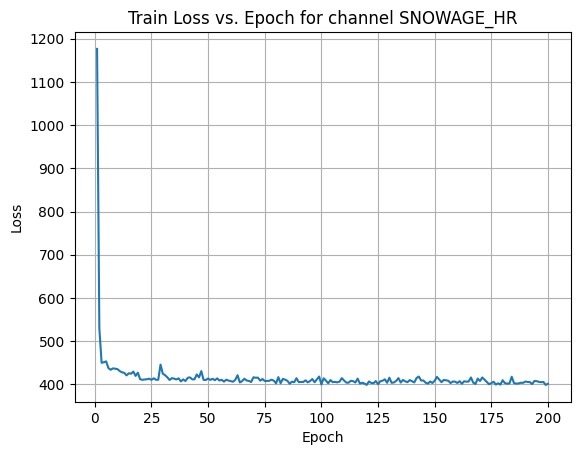

X Channel name :  PRATE_MMpH
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<00:56,  3.54it/s]

Epoch [1/200] Loss: 1028.3382


 10%|█         | 21/200 [00:06<00:53,  3.38it/s]

Epoch [21/200] Loss: 434.1988


 20%|██        | 41/200 [00:12<00:46,  3.42it/s]

Epoch [41/200] Loss: 412.9816


 30%|███       | 61/200 [00:17<00:40,  3.44it/s]

Epoch [61/200] Loss: 405.9959


 40%|████      | 81/200 [00:23<00:34,  3.42it/s]

Epoch [81/200] Loss: 404.1220


 50%|█████     | 101/200 [00:29<00:28,  3.43it/s]

Epoch [101/200] Loss: 415.6019


 60%|██████    | 121/200 [00:35<00:23,  3.41it/s]

Epoch [121/200] Loss: 403.8031


 70%|███████   | 141/200 [00:41<00:17,  3.46it/s]

Epoch [141/200] Loss: 407.2635


 80%|████████  | 161/200 [00:47<00:11,  3.43it/s]

Epoch [161/200] Loss: 404.3506


 90%|█████████ | 181/200 [00:53<00:05,  3.37it/s]

Epoch [181/200] Loss: 409.8351


100%|██████████| 200/200 [00:58<00:00,  3.41it/s]

Average Test Loss: 367.3246


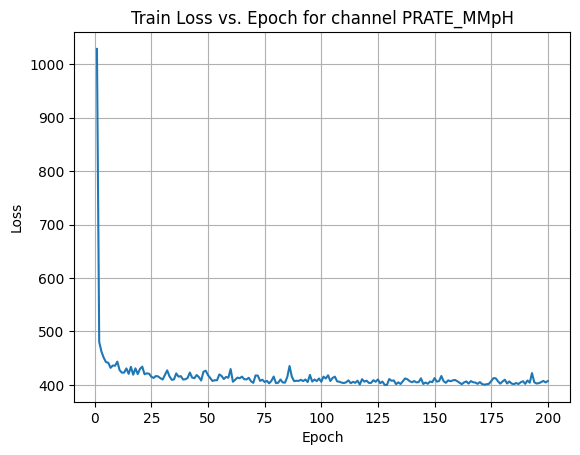

X Channel name :  CLOUD_OD
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<00:57,  3.49it/s]

Epoch [1/200] Loss: 1599.0141


 10%|█         | 21/200 [00:06<00:53,  3.37it/s]

Epoch [21/200] Loss: 192.7198


 20%|██        | 41/200 [00:12<00:47,  3.38it/s]

Epoch [41/200] Loss: 68.0225


 30%|███       | 61/200 [00:18<00:41,  3.36it/s]

Epoch [61/200] Loss: 44.4028


 40%|████      | 81/200 [00:24<00:35,  3.32it/s]

Epoch [81/200] Loss: 32.4964


 50%|█████     | 101/200 [00:30<00:29,  3.38it/s]

Epoch [101/200] Loss: 25.7723


 60%|██████    | 121/200 [00:35<00:23,  3.39it/s]

Epoch [121/200] Loss: 23.6108


 70%|███████   | 141/200 [00:41<00:17,  3.37it/s]

Epoch [141/200] Loss: 19.3957


 80%|████████  | 161/200 [00:47<00:11,  3.41it/s]

Epoch [161/200] Loss: 19.0788


 90%|█████████ | 181/200 [00:53<00:05,  3.39it/s]

Epoch [181/200] Loss: 21.9598


100%|██████████| 200/200 [00:58<00:00,  3.40it/s]


Average Test Loss: 18.7717


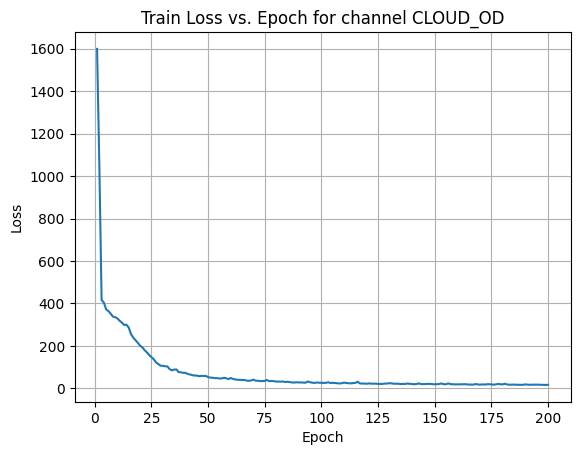

X Channel name :  U10_MpS
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<00:53,  3.73it/s]

Epoch [1/200] Loss: 1023.2784


 10%|█         | 21/200 [00:05<00:52,  3.43it/s]

Epoch [21/200] Loss: 280.1561


 20%|██        | 41/200 [00:11<00:46,  3.44it/s]

Epoch [41/200] Loss: 60.3793


 30%|███       | 61/200 [00:17<00:40,  3.43it/s]

Epoch [61/200] Loss: 29.8831


 40%|████      | 81/200 [00:23<00:35,  3.35it/s]

Epoch [81/200] Loss: 19.7393


 50%|█████     | 101/200 [00:29<00:29,  3.35it/s]

Epoch [101/200] Loss: 16.8795


 60%|██████    | 121/200 [00:35<00:23,  3.37it/s]

Epoch [121/200] Loss: 12.9342


 70%|███████   | 141/200 [00:41<00:17,  3.39it/s]

Epoch [141/200] Loss: 11.2801


 80%|████████  | 161/200 [00:47<00:10,  3.56it/s]

Epoch [161/200] Loss: 10.1249


 90%|█████████ | 181/200 [00:52<00:05,  3.44it/s]

Epoch [181/200] Loss: 11.3411


100%|██████████| 200/200 [00:58<00:00,  3.42it/s]

Average Test Loss: 8.8163


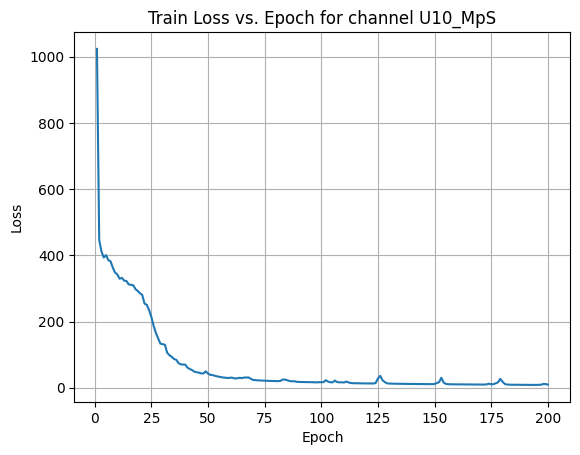

X Channel name :  V10_MpS
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<00:56,  3.53it/s]

Epoch [1/200] Loss: 1439.9822


 10%|█         | 21/200 [00:06<00:51,  3.50it/s]

Epoch [21/200] Loss: 142.6731


 20%|██        | 41/200 [00:11<00:46,  3.45it/s]

Epoch [41/200] Loss: 39.2041


 30%|███       | 61/200 [00:17<00:38,  3.66it/s]

Epoch [61/200] Loss: 20.6722


 40%|████      | 81/200 [00:23<00:33,  3.51it/s]

Epoch [81/200] Loss: 16.5665


 50%|█████     | 101/200 [00:28<00:28,  3.42it/s]

Epoch [101/200] Loss: 12.4099


 60%|██████    | 121/200 [00:34<00:23,  3.42it/s]

Epoch [121/200] Loss: 10.8300


 70%|███████   | 141/200 [00:40<00:17,  3.47it/s]

Epoch [141/200] Loss: 9.6913


 80%|████████  | 161/200 [00:46<00:11,  3.41it/s]

Epoch [161/200] Loss: 8.9197


 90%|█████████ | 181/200 [00:52<00:05,  3.41it/s]

Epoch [181/200] Loss: 10.7642


100%|██████████| 200/200 [00:57<00:00,  3.45it/s]

Average Test Loss: 23.4499


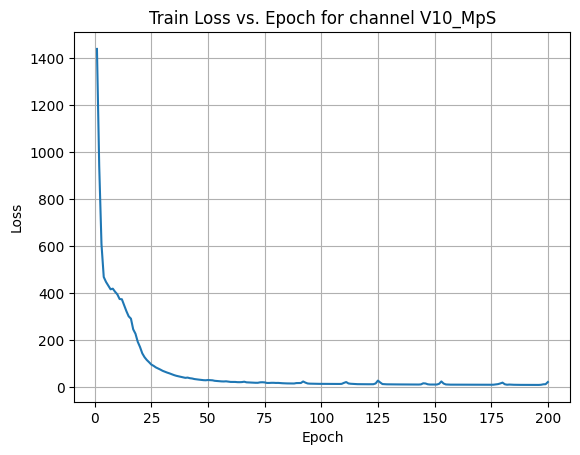

X Channel name :  T2_K
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<00:56,  3.54it/s]

Epoch [1/200] Loss: 1037.4250


 10%|█         | 21/200 [00:06<00:53,  3.35it/s]

Epoch [21/200] Loss: 413.2349


 20%|██        | 41/200 [00:12<00:47,  3.37it/s]

Epoch [41/200] Loss: 411.9822


 30%|███       | 61/200 [00:17<00:41,  3.39it/s]

Epoch [61/200] Loss: 406.0331


 40%|████      | 81/200 [00:23<00:34,  3.43it/s]

Epoch [81/200] Loss: 408.5417


 50%|█████     | 101/200 [00:29<00:28,  3.41it/s]

Epoch [101/200] Loss: 403.6246


 60%|██████    | 121/200 [00:35<00:23,  3.42it/s]

Epoch [121/200] Loss: 409.9414


 70%|███████   | 141/200 [00:41<00:17,  3.41it/s]

Epoch [141/200] Loss: 402.6003


 80%|████████  | 161/200 [00:47<00:11,  3.43it/s]

Epoch [161/200] Loss: 401.2209


 90%|█████████ | 181/200 [00:53<00:05,  3.42it/s]

Epoch [181/200] Loss: 403.0725


100%|██████████| 200/200 [00:58<00:00,  3.41it/s]


Average Test Loss: 366.0120


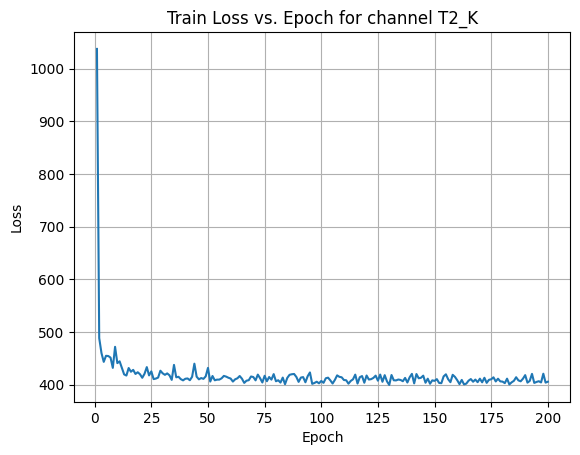

X Channel name :  SWSFC_WpM2
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<00:52,  3.82it/s]

Epoch [1/200] Loss: 1358.9732


 10%|█         | 21/200 [00:06<00:52,  3.43it/s]

Epoch [21/200] Loss: 419.2162


 20%|██        | 41/200 [00:11<00:46,  3.42it/s]

Epoch [41/200] Loss: 413.3607


 30%|███       | 61/200 [00:17<00:40,  3.45it/s]

Epoch [61/200] Loss: 409.3754


 40%|████      | 81/200 [00:23<00:34,  3.45it/s]

Epoch [81/200] Loss: 411.0923


 50%|█████     | 101/200 [00:29<00:28,  3.45it/s]

Epoch [101/200] Loss: 404.1099


 60%|██████    | 121/200 [00:35<00:22,  3.46it/s]

Epoch [121/200] Loss: 409.2167


 70%|███████   | 141/200 [00:40<00:17,  3.43it/s]

Epoch [141/200] Loss: 408.5509


 80%|████████  | 161/200 [00:46<00:11,  3.35it/s]

Epoch [161/200] Loss: 410.1073


 90%|█████████ | 181/200 [00:52<00:05,  3.36it/s]

Epoch [181/200] Loss: 407.5864


100%|██████████| 200/200 [00:58<00:00,  3.42it/s]

Average Test Loss: 364.5863


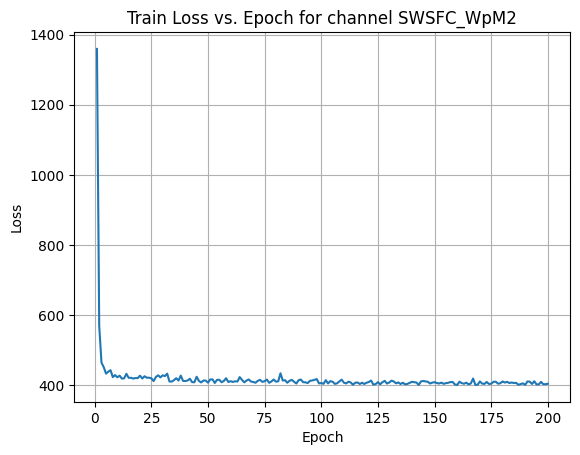

X Channel name :  SOLM_M3pM3
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<00:56,  3.51it/s]

Epoch [1/200] Loss: 1237.3417


 10%|█         | 21/200 [00:06<00:52,  3.38it/s]

Epoch [21/200] Loss: 337.7638


 20%|██        | 41/200 [00:12<00:46,  3.38it/s]

Epoch [41/200] Loss: 223.9836


 30%|███       | 61/200 [00:17<00:40,  3.45it/s]

Epoch [61/200] Loss: 98.1059


 40%|████      | 81/200 [00:23<00:34,  3.42it/s]

Epoch [81/200] Loss: 46.6351


 50%|█████     | 101/200 [00:29<00:29,  3.34it/s]

Epoch [101/200] Loss: 31.9773


 60%|██████    | 121/200 [00:35<00:23,  3.38it/s]

Epoch [121/200] Loss: 26.2758


 70%|███████   | 141/200 [00:41<00:17,  3.40it/s]

Epoch [141/200] Loss: 19.9056


 80%|████████  | 161/200 [00:47<00:11,  3.35it/s]

Epoch [161/200] Loss: 17.7226


 90%|█████████ | 181/200 [00:53<00:05,  3.39it/s]

Epoch [181/200] Loss: 15.4444


100%|██████████| 200/200 [00:58<00:00,  3.39it/s]

Average Test Loss: 14.0181


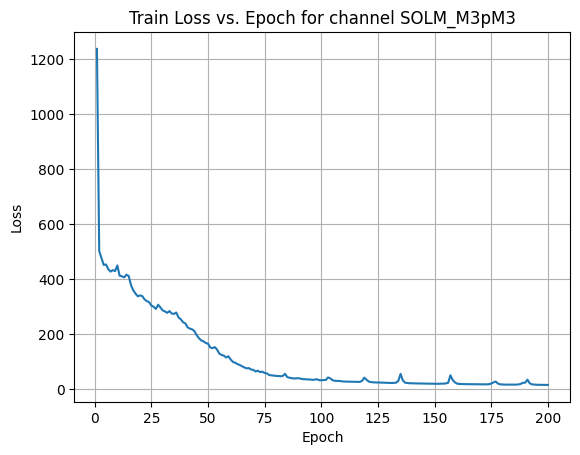

X Channel name :  CLDTOP_KM
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<00:58,  3.40it/s]

Epoch [1/200] Loss: 1227.4362


 10%|█         | 21/200 [00:06<00:53,  3.37it/s]

Epoch [21/200] Loss: 430.1239


 20%|██        | 41/200 [00:12<00:46,  3.42it/s]

Epoch [41/200] Loss: 414.0475


 30%|███       | 61/200 [00:17<00:40,  3.40it/s]

Epoch [61/200] Loss: 414.5093


 40%|████      | 81/200 [00:24<00:35,  3.34it/s]

Epoch [81/200] Loss: 412.3910


 50%|█████     | 101/200 [00:29<00:28,  3.42it/s]

Epoch [101/200] Loss: 413.5266


 60%|██████    | 121/200 [00:35<00:23,  3.36it/s]

Epoch [121/200] Loss: 408.5565


 70%|███████   | 141/200 [00:41<00:17,  3.36it/s]

Epoch [141/200] Loss: 404.2547


 80%|████████  | 161/200 [00:47<00:11,  3.32it/s]

Epoch [161/200] Loss: 417.1860


 90%|█████████ | 181/200 [00:53<00:05,  3.46it/s]

Epoch [181/200] Loss: 408.9205


100%|██████████| 200/200 [00:59<00:00,  3.38it/s]


Average Test Loss: 367.3491


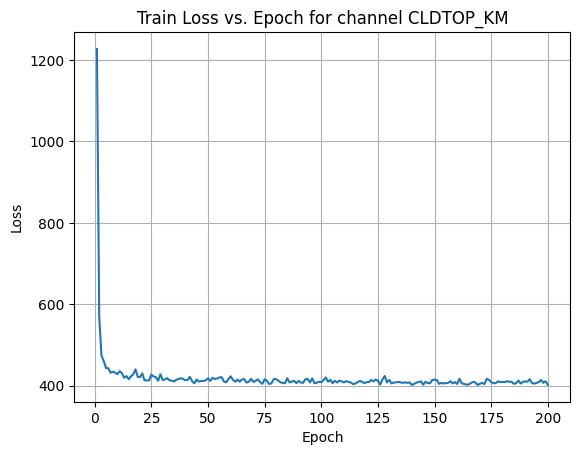

X Channel name :  CAPE
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<00:59,  3.37it/s]

Epoch [1/200] Loss: 1362.6006


 10%|█         | 21/200 [00:06<00:54,  3.30it/s]

Epoch [21/200] Loss: 417.5348


 20%|██        | 41/200 [00:11<00:46,  3.45it/s]

Epoch [41/200] Loss: 409.7356


 30%|███       | 61/200 [00:17<00:40,  3.41it/s]

Epoch [61/200] Loss: 411.1969


 40%|████      | 81/200 [00:23<00:35,  3.37it/s]

Epoch [81/200] Loss: 413.3693


 50%|█████     | 101/200 [00:29<00:30,  3.29it/s]

Epoch [101/200] Loss: 414.5004


 60%|██████    | 121/200 [00:35<00:23,  3.36it/s]

Epoch [121/200] Loss: 405.8445


 70%|███████   | 141/200 [00:41<00:17,  3.44it/s]

Epoch [141/200] Loss: 404.8460


 80%|████████  | 161/200 [00:47<00:11,  3.45it/s]

Epoch [161/200] Loss: 415.0352


 90%|█████████ | 181/200 [00:53<00:05,  3.41it/s]

Epoch [181/200] Loss: 414.2297


100%|██████████| 200/200 [00:59<00:00,  3.39it/s]


Average Test Loss: 366.4497


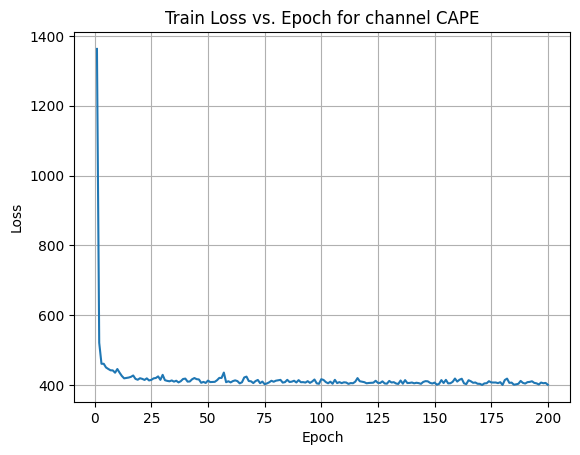

X Channel name :  PBL_WRF_M
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<00:57,  3.47it/s]

Epoch [1/200] Loss: 1069.1285


 10%|█         | 21/200 [00:05<00:52,  3.42it/s]

Epoch [21/200] Loss: 408.2721


 20%|██        | 41/200 [00:11<00:45,  3.51it/s]

Epoch [41/200] Loss: 408.3345


 30%|███       | 61/200 [00:17<00:39,  3.50it/s]

Epoch [61/200] Loss: 411.1250


 40%|████      | 81/200 [00:23<00:34,  3.43it/s]

Epoch [81/200] Loss: 406.6349


 50%|█████     | 101/200 [00:29<00:29,  3.40it/s]

Epoch [101/200] Loss: 409.1261


 60%|██████    | 121/200 [00:35<00:23,  3.43it/s]

Epoch [121/200] Loss: 403.4630


 70%|███████   | 141/200 [00:41<00:17,  3.43it/s]

Epoch [141/200] Loss: 405.4774


 80%|████████  | 161/200 [00:46<00:11,  3.39it/s]

Epoch [161/200] Loss: 403.7881


 90%|█████████ | 181/200 [00:52<00:05,  3.37it/s]

Epoch [181/200] Loss: 408.1804


100%|██████████| 200/200 [00:58<00:00,  3.42it/s]

Average Test Loss: 367.3865


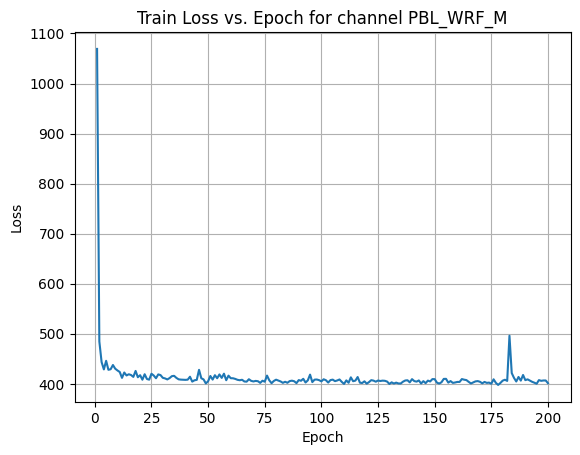

X Channel name :  PBL_YSU_M
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<00:58,  3.40it/s]

Epoch [1/200] Loss: 1065.3006


 10%|█         | 21/200 [00:06<00:50,  3.55it/s]

Epoch [21/200] Loss: 443.1136


 20%|██        | 41/200 [00:11<00:45,  3.52it/s]

Epoch [41/200] Loss: 407.0351


 30%|███       | 61/200 [00:17<00:40,  3.46it/s]

Epoch [61/200] Loss: 409.3611


 40%|████      | 81/200 [00:23<00:33,  3.50it/s]

Epoch [81/200] Loss: 403.8964


 50%|█████     | 101/200 [00:29<00:28,  3.44it/s]

Epoch [101/200] Loss: 402.2005


 60%|██████    | 121/200 [00:35<00:22,  3.45it/s]

Epoch [121/200] Loss: 402.1708


 70%|███████   | 141/200 [00:40<00:17,  3.40it/s]

Epoch [141/200] Loss: 403.3740


 80%|████████  | 161/200 [00:46<00:11,  3.37it/s]

Epoch [161/200] Loss: 398.9786


 90%|█████████ | 181/200 [00:52<00:05,  3.45it/s]

Epoch [181/200] Loss: 408.3548


100%|██████████| 200/200 [00:58<00:00,  3.44it/s]

Average Test Loss: 380.6446


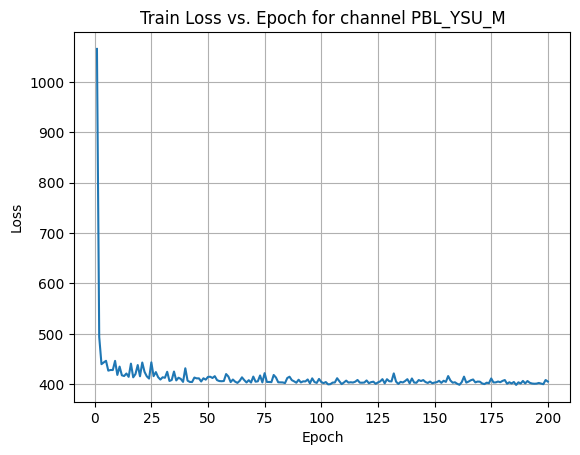

In [ ]:
test_loss_list_P_10_conv_auto = []
y_channel = 1 # selecting P10 as output
# x_channel = 0
for x_channel in range(X.shape[1]):
    ####################### Selecting the channel #######################
    print('X Channel name : ', target_var_96_list[x_channel])
    X_train = X_train_all[:, x_channel:x_channel+1, :,:]
    X_test = X_test_all[:, x_channel:x_channel+1, :,:]
    y_train = y_train_all[:, y_channel:y_channel+1, :,:]
    y_test = y_test_all[:, y_channel:y_channel+1, :,:]
    print('Shapes: ', X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    ####################### Creating the dataset loader #######################
    train_custom_dataset = CustomDataset(X_train, y_train)
    # print(len(train_custom_dataset))
    batch_size = 32
    train_loader = data.DataLoader(train_custom_dataset, batch_size=batch_size, shuffle=True)
    # print(len(train_loader))
    
    test_custom_dataset = CustomDataset(X_test, y_test)
    # print(len(test_custom_dataset))
    batch_size = 32
    test_loader = data.DataLoader(test_custom_dataset, batch_size=batch_size, shuffle=False)
    # print(len(test_loader))
    

    #################### Training the model ####################
    model = Autoencoder_CNN(image_size = 80, num_input_channels = 1, num_output_channels=1, c_hid = 8, latent_dim = 512, activation= nn.GELU)
    model.to(device)
    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    losses = []
    # Training loop
    num_epochs = 200
    for epoch in trange(num_epochs):
        model.train()  # Set the model to training mode
        total_loss = 0.0
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()  # Zero the gradients
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Forward pass
            outputs = model(inputs)
            
            # Calculate the loss
            loss = criterion(outputs, targets)
            
            # Backpropagation
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        # Print the average loss for this epoch
        average_loss = total_loss / len(train_loader)
        losses.append(average_loss)
        if epoch % 20 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {average_loss:.4f}")
    
    ############################# testing the model #############################
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Forward pass
            outputs = model(inputs)
            # Calculate the loss
            loss = criterion(outputs, targets)
            test_loss += loss.item()

    # Print the average test loss
    average_test_loss = test_loss / len(test_loader)
    test_loss_list_P_10_conv_auto.append(average_test_loss)
    print(f"Average Test Loss: {average_test_loss:.4f}")
    plt.plot(range(1, num_epochs + 1), losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train Loss vs. Epoch for channel '+target_var_96_list[x_channel])
    plt.grid(True) 
    plt.show() 

In [ ]:
test_loss_list_P_10_conv_auto

[367.97836858575994,
 373.660117409446,
 393.0328174937855,
 367.32460992986506,
 18.771740219809793,
 8.816288991407914,
 23.44990175420588,
 366.0119906338778,
 364.58628151633525,
 14.018102992664684,
 367.34911554509944,
 366.4497375488281,
 367.38653841885656,
 380.64462835138494]

In [ ]:
name_loss_pairs = list(zip(target_var_96_list, test_loss_list_P_10_conv_auto))

# Sort based on loss values
sorted_name_loss_pairs = sorted(name_loss_pairs, key=lambda x: x[1])
for pair in sorted_name_loss_pairs:
    print(pair)
# print(sorted_name_loss_pairs)
# Select the lowest 3 names
lowest_3_names = [pair[0] for pair in sorted_name_loss_pairs[:3]]

print("Lowest 3 names:", lowest_3_names)

('U10_MpS', 8.816288991407914)
('SOLM_M3pM3', 14.018102992664684)
('CLOUD_OD', 18.771740219809793)
('V10_MpS', 23.44990175420588)
('SWSFC_WpM2', 364.58628151633525)
('T2_K', 366.0119906338778)
('CAPE', 366.4497375488281)
('PRATE_MMpH', 367.32460992986506)
('CLDTOP_KM', 367.34911554509944)
('PBL_WRF_M', 367.38653841885656)
('TSURF_K', 367.97836858575994)
('SNOWEW_M', 373.660117409446)
('PBL_YSU_M', 380.64462835138494)
('SNOWAGE_HR', 393.0328174937855)
Lowest 3 names: ['U10_MpS', 'SOLM_M3pM3', 'CLOUD_OD']


## Insights

In [ ]:
# Adding values at corresponding indices
result = [(x + y)/2 for x, y in zip(test_loss_list_P_10_conv_auto, test_loss_list_P_25_conv_auto)]

# Creating a DataFrame
data_frame = {'Input channel': target_var_96_list, 'P10': test_loss_list_P_10_conv_auto, 'P25': test_loss_list_P_25_conv_auto, 'P10+P25 avg': result}
df = pd.DataFrame(data_frame)

# Sorting the DataFrame based on "List1 + List2"
df_sorted = df.sort_values(by='P10+P25 avg')

# Displaying the sorted DataFrame

df_rounded = df_sorted.round(1)
df_rounded.to_csv('/home/rishabh.mondal/climax_alternative/Climax_2/results/test_loss_list_P_10_P25_conv_auto.csv', index=False)
df_rounded

,Input channel,P10,P25,P10+P25 avg
5,U10_MpS,8.8,3.2,6.0
9,SOLM_M3pM3,14.0,5.6,9.8
4,CLOUD_OD,18.8,7.5,13.1
6,V10_MpS,23.4,2.9,13.2
8,SWSFC_WpM2,364.6,193.2,278.9
7,T2_K,366.0,191.9,279.0
11,CAPE,366.4,191.6,279.0
12,PBL_WRF_M,367.4,190.8,279.1
3,PRATE_MMpH,367.3,194.9,281.1
0,TSURF_K,368.0,196.8,282.4


## Training on top 4 channel and predicting on all channel CONV

In [ ]:
# target_var_96_list =['TSURF_K',
#        'SNOWEW_M', 'SNOWAGE_HR', 'PRATE_MMpH', 'CLOUD_OD', 'U10_MpS',
#        'V10_MpS', 'T2_K', 'SWSFC_WpM2', 'SOLM_M3pM3', 'CLDTOP_KM', 'CAPE',
#        'PBL_WRF_M', 'PBL_YSU_M']  # ['U10_MpS', 'T2_K', 'V10_MpS']
target_var_96_list= ['V10_MpS','U10_MpS','SOLM_M3pM3', 'CLOUD_OD']
target_var_120_list = ['P25','P10'] 
X,y  = get_data(target_var_96_list, target_var_120_list)

from sklearn.model_selection import train_test_split
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_all.shape, X_test_all.shape, y_train_all.shape, y_test_all.shape

X shape  (1656, 4, 80, 80)
y shape (1656, 2, 80, 80)


((1324, 4, 80, 80), (332, 4, 80, 80), (1324, 2, 80, 80), (332, 2, 80, 80))

(1324, 4, 80, 80) (332, 4, 80, 80) (1324, 2, 80, 80) (332, 2, 80, 80)
Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder_CNN                          [1656, 2, 80, 80]         --
├─Encoder: 1-1                           [1656, 2048]              --
│    └─Sequential: 2-1                   [1656, 2048]              --
│    │    └─Conv2d: 3-1                  [1656, 64, 40, 40]        2,368
│    │    └─GELU: 3-2                    [1656, 64, 40, 40]        --
│    │    └─Conv2d: 3-3                  [1656, 64, 40, 40]        36,928
│    │    └─GELU: 3-4                    [1656, 64, 40, 40]        --
│    │    └─Conv2d: 3-5                  [1656, 128, 20, 20]       73,856
│    │    └─GELU: 3-6                    [1656, 128, 20, 20]       --
│    │    └─Conv2d: 3-7                  [1656, 128, 20, 20]       147,584
│    │    └─GELU: 3-8                    [1656, 128, 20, 20]       --
│    │    └─Conv2d: 3-9                  [1656, 256, 10, 10]       29

  1%|▏         | 1/80 [00:02<02:40,  2.03s/it]

Epoch [1/80] Loss: 1343.9761
Average Test Loss: 313.2759


 26%|██▋       | 21/80 [00:35<01:40,  1.71s/it]

Epoch [21/80] Loss: 51.4848
Average Test Loss: 41.3688


 51%|█████▏    | 41/80 [01:09<01:07,  1.72s/it]

Epoch [41/80] Loss: 19.3960
Average Test Loss: 15.7720


 76%|███████▋  | 61/80 [01:43<00:32,  1.71s/it]

Epoch [61/80] Loss: 10.1627
Average Test Loss: 6.6679


100%|██████████| 80/80 [02:15<00:00,  1.70s/it]


Average Test Loss: 3.3631


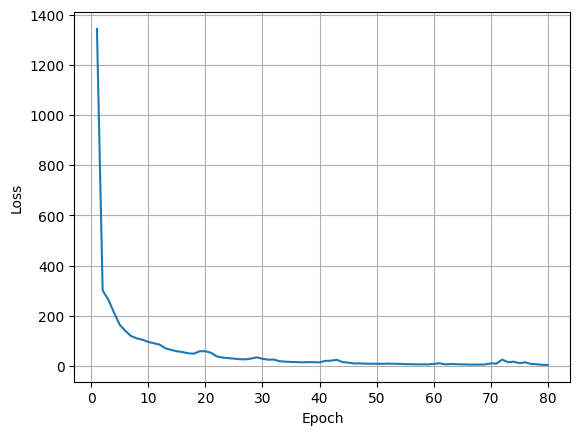

In [ ]:
print(X_train_all.shape, X_test_all.shape, y_train_all.shape, y_test_all.shape)
train_custom_dataset = CustomDataset(X_train_all, y_train_all)
# print(len(train_custom_dataset))
batch_size = 32
train_loader = data.DataLoader(train_custom_dataset, batch_size=batch_size, shuffle=True)
# print(len(train_loader))

test_custom_dataset = CustomDataset(X_test_all, y_test_all)
# print(len(test_custom_dataset))
batch_size = 32
test_loader = data.DataLoader(test_custom_dataset, batch_size=batch_size, shuffle=False)
# print(len(test_loader))


#################### Training the model ####################
model = Autoencoder_CNN(image_size = 80, num_input_channels = 4, num_output_channels=2, c_hid = 64, latent_dim = 2048, activation= nn.GELU)
model.to(device) 
from torchinfo import summary
print(summary(model, input_size=(1656, 4, 80, 80)))
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
losses = [] 
# Training loop
num_epochs = 80
for epoch in trange(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0.0
    
    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        inputs = inputs.to(device)
        targets = targets.to(device)
        # Forward pass
        outputs = model(inputs)
        
        # Calculate the loss
        loss = criterion(outputs, targets)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    # Print the average loss for this epoch
    average_loss = total_loss / len(train_loader)
    losses.append(average_loss)
    if epoch % 20 == 0: 
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {average_loss:.4f}")

############################# testing the model #############################
        model.eval()  # Set the model to evaluation mode
        test_loss = 0.0

        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                # Forward pass
                outputs = model(inputs)

                # Calculate the loss
                loss = criterion(outputs, targets)

                test_loss += loss.item()

        # Print the average test loss
        average_test_loss = test_loss / len(test_loader)
        # test_loss_list_P_25.append(average_test_loss)
        print(f"Average Test Loss: {average_test_loss:.4f}")
model.eval()  # Set the model to evaluation mode
test_loss = 0.0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, targets)

        test_loss += loss.item()

# Print the average test loss
average_test_loss = test_loss / len(test_loader)
# test_loss_list_P_25.append(average_test_loss)
print(f"Average Test Loss: {average_test_loss:.4f}")

plt.plot(range(1, num_epochs + 1), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.title('Train Loss vs. Epoch for channel '+target_var_96_list[x_channel])
plt.grid(True) 
plt.show() 

In [ ]:
torch.save(model.state_dict(), 'model/auto_conv_in4_out2.pt')
model = Autoencoder_CNN(image_size = 80, num_input_channels = 4, num_output_channels=2, c_hid = 64, latent_dim = 2048, activation= nn.GELU)
model.to(device) 
model.load_state_dict(torch.load('model/auto_conv_in4_out2.pt'))

<All keys matched successfully>

# UNET Autoencoder with convolutional layers 

## Model defination

In [ ]:
class Encoder(nn.Module):
    def __init__(self, image_size, num_input_channels, num_output_channels = 1, c_hid = 16, latent_dim = 1024, activation= nn.GELU):
        super(Encoder, self).__init__()
        self.image_size = image_size
        self.num_input_channels = num_input_channels
        self.num_output_channels = num_output_channels
        self.c_hid = c_hid
        self.latent_dim = latent_dim
        self.activation = activation
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=self.num_input_channels, out_channels=self.c_hid, kernel_size=3, stride=2, padding=1),
            self.activation(),
            nn.Conv2d(in_channels=self.c_hid, out_channels=self.c_hid, kernel_size=3, padding=1),
            self.activation(),
            nn.Conv2d(in_channels=self.c_hid, out_channels=2 * self.c_hid, kernel_size=3, stride=2, padding=1),
            self.activation(),
            nn.Conv2d(in_channels=2 * self.c_hid, out_channels=2 * self.c_hid, kernel_size=3, padding=1),
            self.activation(),
            nn.Conv2d(in_channels=2 * self.c_hid, out_channels=4*self.c_hid, kernel_size=3, stride=2, padding=1),
            self.activation(),
            nn.Flatten(),
            nn.Linear((4 * self.c_hid) * self.image_size//8 * self.image_size//8, self.latent_dim)
        )
    def forward(self, x):
        return self.net(x)
    
class Decoder(nn.Module):
    def __init__(self, image_size, num_input_channels, num_output_channels = 1,c_hid = 16, latent_dim = 1024, activation= nn.GELU):
        super(Decoder, self).__init__()
        self.image_size = image_size
        self.num_input_channels = num_input_channels
        self.num_output_channels = num_output_channels
        self.c_hid = c_hid
        self.latent_dim = latent_dim
        self.activation = activation
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, (4 * self.c_hid) * self.image_size//8 * self.image_size//8),
            nn.Unflatten(1, (4*self.c_hid, self.image_size//8, self.image_size//8)),
            nn.ConvTranspose2d(in_channels=4*self.c_hid, out_channels= 2*self.c_hid, kernel_size=3, stride=2, padding=1, output_padding=1),
            self.activation(),
            nn.Conv2d(in_channels = 2*self.c_hid, out_channels= 2*self.c_hid, kernel_size=3, padding=1),
            self.activation(),
            nn.ConvTranspose2d(in_channels = 2*self.c_hid, out_channels = self.c_hid, kernel_size=3, stride=2, padding=1, output_padding=1),
            self.activation(),
            nn.Conv2d(in_channels = self.c_hid,out_channels= self.c_hid, kernel_size=3, padding=1),
            self.activation(),
            nn.ConvTranspose2d(in_channels = self.c_hid, out_channels= self.num_output_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
        )
    def forward(self, x):
        return self.decoder(x)
    
class Autoencoder_UNET(nn.Module):
    def __init__(self, image_size, num_input_channels, num_output_channels = 1,c_hid = 16, latent_dim = 1024, activation= nn.GELU, encoder = Encoder, decoder = Decoder):
        super(Autoencoder_UNET, self).__init__()
        self.image_size = image_size
        self.num_input_channels = num_input_channels
        self.num_output_channels = num_output_channels
        self.c_hid = c_hid
        self.latent_dim = latent_dim
        self.activation = activation
        self.encoder = encoder(self.image_size, self.num_input_channels, self.num_output_channels, self.c_hid, self.latent_dim, self.activation)
        self.decoder = decoder(self.image_size, self.num_input_channels, self.num_output_channels, self.c_hid, self.latent_dim, self.activation)
    # def forward(self, x):
    #     x = self.encoder(x)
    #     # print(x.shape)
    #     x = self.decoder(x)
    #     return x
    def forward(self, x):
        conv1 = self.encoder.net[0]
        activation1 = self.encoder.net[1]
        conv2 = self.encoder.net[2]
        activation2 = self.encoder.net[3]
        conv3 = self.encoder.net[4]
        activation3 = self.encoder.net[5]
        conv4 = self.encoder.net[6]
        activation4 = self.encoder.net[7]
        conv5 = self.encoder.net[8]
        activation5 = self.encoder.net[9]
        flatten = self.encoder.net[10]
        linear = self.encoder.net[11]
        lineart = self.decoder.decoder[0]
        unflattent = self.decoder.decoder[1]
        convt2 = self.decoder.decoder[2]
        activation7 = self.decoder.decoder[3]
        convt3 = self.decoder.decoder[4]
        activation8 = self.decoder.decoder[5]
        convt4 = self.decoder.decoder[6]
        activation9 = self.decoder.decoder[7]
        convt5 = self.decoder.decoder[8]
        activation10 = self.decoder.decoder[9]
        convt6 = self.decoder.decoder[10]
        x1 = activation1(conv1(x))
        x2 = activation2(conv2(x1))
        x3 = activation3(conv3(x2))
        x4 = activation4(conv4(x3))
        x5 = activation5(conv5(x4))
        x6 = flatten(x5)
        x7 = linear(x6)
        x8 = lineart(x7)
        x9 = unflattent(x8)
        x10 = activation7(convt2(x9+x5))
        x11 = activation8(convt3(x10+x4))
        x12 = activation9(convt4(x11+x3))
        x13 = activation10(convt5(x12+x2))
        x13 = convt6(x13+x1)
        return x13

In [ ]:
model_auto = Autoencoder_UNET(image_size = 80, num_input_channels = 14, num_output_channels=2, c_hid = 16, latent_dim = 1024, activation= nn.GELU)
model_auto
dummy_input = torch.randn(11, 14, 80, 80)  # Assuming input size of (batch_size, num_num_input_channels, height, width)
out = model_auto(dummy_input)
print(out.shape)    
print(model_auto)

torch.Size([11, 2, 80, 80])
Autoencoder_UNET(
  (encoder): Encoder(
    (net): Sequential(
      (0): Conv2d(14, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): GELU(approximate='none')
      (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): GELU(approximate='none')
      (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): GELU(approximate='none')
      (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): GELU(approximate='none')
      (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (9): GELU(approximate='none')
      (10): Flatten(start_dim=1, end_dim=-1)
      (11): Linear(in_features=6400, out_features=1024, bias=True)
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=1024, out_features=6400, bias=True)
      (1): Unflatten(dim=1, unflattened_size=(64, 10, 10))
      (2): ConvTranspose2d(64, 32, kernel_size=(

In [ ]:
from torchinfo import summary
summary(model_auto, input_size=(1656, 14, 80, 80))

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder_UNET                         [1656, 2, 80, 80]         --
├─Encoder: 1-1                           --                        --
│    └─Sequential: 2-1                   --                        --
│    │    └─Conv2d: 3-1                  [1656, 16, 40, 40]        2,032
│    │    └─GELU: 3-2                    [1656, 16, 40, 40]        --
│    │    └─Conv2d: 3-3                  [1656, 16, 40, 40]        2,320
│    │    └─GELU: 3-4                    [1656, 16, 40, 40]        --
│    │    └─Conv2d: 3-5                  [1656, 32, 20, 20]        4,640
│    │    └─GELU: 3-6                    [1656, 32, 20, 20]        --
│    │    └─Conv2d: 3-7                  [1656, 32, 20, 20]        9,248
│    │    └─GELU: 3-8                    [1656, 32, 20, 20]        --
│    │    └─Conv2d: 3-9                  [1656, 64, 10, 10]        18,496
│    │    └─GELU: 3-10                   [1656, 64, 10, 10]        --

In [ ]:
from torchsummary import summary
summary(model_auto, input_size=(14, 80, 80)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 40, 40]           2,032
              GELU-2           [-1, 16, 40, 40]               0
            Conv2d-3           [-1, 16, 40, 40]           2,320
              GELU-4           [-1, 16, 40, 40]               0
            Conv2d-5           [-1, 32, 20, 20]           4,640
              GELU-6           [-1, 32, 20, 20]               0
            Conv2d-7           [-1, 32, 20, 20]           9,248
              GELU-8           [-1, 32, 20, 20]               0
            Conv2d-9           [-1, 64, 10, 10]          18,496
             GELU-10           [-1, 64, 10, 10]               0
          Flatten-11                 [-1, 6400]               0
           Linear-12                 [-1, 1024]       6,554,624
           Linear-13                 [-1, 6400]       6,560,000
        Unflatten-14           [-1, 64,

## Training on all channel and predicting on all channel UNET

In [ ]:
target_var_96_list =['TSURF_K',
       'SNOWEW_M', 'SNOWAGE_HR', 'PRATE_MMpH', 'CLOUD_OD', 'U10_MpS',
       'V10_MpS', 'T2_K', 'SWSFC_WpM2', 'SOLM_M3pM3', 'CLDTOP_KM', 'CAPE',
       'PBL_WRF_M', 'PBL_YSU_M']  # ['U10_MpS', 'T2_K', 'V10_MpS']
target_var_120_list = ['P25','P10'] 
X,y  = get_data(target_var_96_list, target_var_120_list)

from sklearn.model_selection import train_test_split
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_all.shape, X_test_all.shape, y_train_all.shape, y_test_all.shape

X shape  (1656, 14, 80, 80)
y shape (1656, 2, 80, 80)


((1324, 14, 80, 80), (332, 14, 80, 80), (1324, 2, 80, 80), (332, 2, 80, 80))

(1324, 14, 80, 80) (332, 14, 80, 80) (1324, 2, 80, 80) (332, 2, 80, 80)


Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder_UNET                         [1656, 2, 80, 80]         --
├─Encoder: 1-1                           --                        --
│    └─Sequential: 2-1                   --                        --
│    │    └─Conv2d: 3-1                  [1656, 64, 40, 40]        8,128
│    │    └─GELU: 3-2                    [1656, 64, 40, 40]        --
│    │    └─Conv2d: 3-3                  [1656, 64, 40, 40]        36,928
│    │    └─GELU: 3-4                    [1656, 64, 40, 40]        --
│    │    └─Conv2d: 3-5                  [1656, 128, 20, 20]       73,856
│    │    └─GELU: 3-6                    [1656, 128, 20, 20]       --
│    │    └─Conv2d: 3-7                  [1656, 128, 20, 20]       147,584
│    │    └─GELU: 3-8                    [1656, 128, 20, 20]       --
│    │    └─Conv2d: 3-9                  [1656, 256, 10, 10]       295,168
│    │    └─GELU: 3-10                   [1656, 256, 10, 10]    

  0%|          | 1/200 [00:03<11:37,  3.50s/it]

Epoch [1/200] Loss: 3185.9086


 10%|█         | 21/200 [01:08<10:15,  3.44s/it]

Epoch [21/200] Loss: 238.7220


 20%|██        | 41/200 [02:19<09:16,  3.50s/it]

Epoch [41/200] Loss: 90.1479


 30%|███       | 61/200 [03:44<09:57,  4.30s/it]

Epoch [61/200] Loss: 19.3867


 40%|████      | 81/200 [05:06<08:00,  4.04s/it]

Epoch [81/200] Loss: 7.6679


 50%|█████     | 101/200 [06:30<07:00,  4.24s/it]

Epoch [101/200] Loss: 5.9376


 60%|██████    | 121/200 [07:57<05:25,  4.12s/it]

Epoch [121/200] Loss: 7.9944


 70%|███████   | 141/200 [09:21<03:59,  4.06s/it]

Epoch [141/200] Loss: 5.3282


 80%|████████  | 161/200 [10:38<02:34,  3.97s/it]

Epoch [161/200] Loss: 4.2981


 90%|█████████ | 181/200 [11:58<01:13,  3.87s/it]

Epoch [181/200] Loss: 4.3096


100%|██████████| 200/200 [13:15<00:00,  3.98s/it]


Average Test Loss: 3.9575


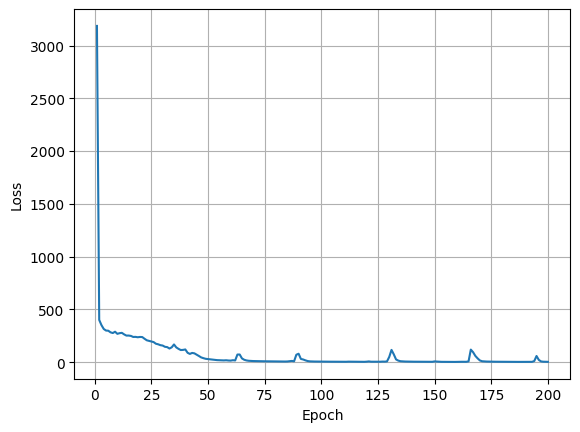

In [ ]:
print(X_train_all.shape, X_test_all.shape, y_train_all.shape, y_test_all.shape)
train_custom_dataset = CustomDataset(X_train_all, y_train_all)
# print(len(train_custom_dataset))
batch_size = 32
train_loader = data.DataLoader(train_custom_dataset, batch_size=batch_size, shuffle=True)
# print(len(train_loader))

test_custom_dataset = CustomDataset(X_test_all, y_test_all)
# print(len(test_custom_dataset))
batch_size = 32
test_loader = data.DataLoader(test_custom_dataset, batch_size=batch_size, shuffle=False)
# print(len(test_loader))


#################### Training the model ####################
model = Autoencoder_UNET(image_size = 80, num_input_channels = 14, num_output_channels=2, c_hid = 64, latent_dim = 2048, activation= nn.GELU)
model.to(device) 
from torchinfo import summary
print(summary(model, input_size=(1656, 14, 80, 80)))
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
losses = [] 
# Training loop
num_epochs = 200
for epoch in trange(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0.0
    
    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        inputs = inputs.to(device)
        targets = targets.to(device)
        # Forward pass
        outputs = model(inputs)
        
        # Calculate the loss
        loss = criterion(outputs, targets)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    # Print the average loss for this epoch
    average_loss = total_loss / len(train_loader)
    losses.append(average_loss)
    if epoch % 20 == 0: 
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {average_loss:.4f}")

############################# testing the model #############################
model.eval()  # Set the model to evaluation mode
test_loss = 0.0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, targets)

        test_loss += loss.item()

# Print the average test loss
average_test_loss = test_loss / len(test_loader)
# test_loss_list_P_25.append(average_test_loss)
print(f"Average Test Loss: {average_test_loss:.4f}")

plt.plot(range(1, num_epochs + 1), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.title('Train Loss vs. Epoch for channel '+target_var_96_list[x_channel])
plt.grid(True) 
plt.show() 

In [ ]:
torch.save(model.state_dict(), 'model/auto_conv_unet_in14_out2.pt')
model = Autoencoder_UNET(image_size = 80, num_input_channels = 14, num_output_channels=2, c_hid = 64, latent_dim = 2048, activation= nn.GELU)
model.to(device) 
model.load_state_dict(torch.load('model/auto_conv_unet_in14_out2.pt'))

<All keys matched successfully>

## Single channel input single channel output(P25) UNET

In [ ]:
target_var_96_list =['TSURF_K',
       'SNOWEW_M', 'SNOWAGE_HR', 'PRATE_MMpH', 'CLOUD_OD', 'U10_MpS',
       'V10_MpS', 'T2_K', 'SWSFC_WpM2', 'SOLM_M3pM3', 'CLDTOP_KM', 'CAPE',
       'PBL_WRF_M', 'PBL_YSU_M']  # ['U10_MpS', 'T2_K', 'V10_MpS']
target_var_120_list = ['P25','P10'] 
X,y  = get_data(target_var_96_list, target_var_120_list)

from sklearn.model_selection import train_test_split
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_all.shape, X_test_all.shape, y_train_all.shape, y_test_all.shape

X shape  (1656, 14, 80, 80)
y shape (1656, 2, 80, 80)


((1324, 14, 80, 80), (332, 14, 80, 80), (1324, 2, 80, 80), (332, 2, 80, 80))

X Channel name :  TSURF_K
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 1/200 [00:00<01:04,  3.09it/s]

Epoch [1/200] Loss: 2015.0104


 10%|█         | 21/200 [00:06<00:57,  3.11it/s]

Epoch [21/200] Loss: 224.4622


 20%|██        | 41/200 [00:13<00:49,  3.20it/s]

Epoch [41/200] Loss: 217.3994


 30%|███       | 61/200 [00:19<00:43,  3.20it/s]

Epoch [61/200] Loss: 213.6307


 40%|████      | 81/200 [00:25<00:37,  3.16it/s]

Epoch [81/200] Loss: 211.9555


 50%|█████     | 101/200 [00:31<00:30,  3.20it/s]

Epoch [101/200] Loss: 212.0086


 60%|██████    | 121/200 [00:38<00:24,  3.17it/s]

Epoch [121/200] Loss: 210.0710


 70%|███████   | 141/200 [00:44<00:18,  3.18it/s]

Epoch [141/200] Loss: 216.9347


 80%|████████  | 161/200 [00:50<00:12,  3.21it/s]

Epoch [161/200] Loss: 214.3995


 90%|█████████ | 181/200 [00:56<00:05,  3.19it/s]

Epoch [181/200] Loss: 209.9813


100%|██████████| 200/200 [01:02<00:00,  3.18it/s]


Average Test Loss: 192.8667


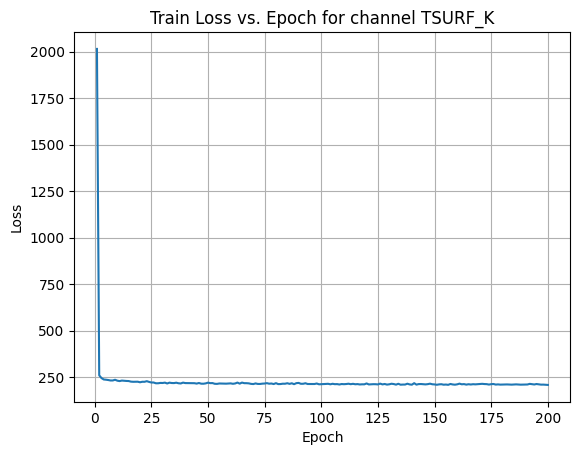

X Channel name :  SNOWEW_M
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<01:01,  3.26it/s]

Epoch [1/200] Loss: 720.3883


 10%|█         | 21/200 [00:06<00:56,  3.15it/s]

Epoch [21/200] Loss: 215.2669


 20%|██        | 41/200 [00:12<00:50,  3.15it/s]

Epoch [41/200] Loss: 212.9412


 30%|███       | 61/200 [00:19<00:43,  3.19it/s]

Epoch [61/200] Loss: 210.6425


 40%|████      | 81/200 [00:25<00:37,  3.19it/s]

Epoch [81/200] Loss: 209.0133


 50%|█████     | 101/200 [00:31<00:30,  3.22it/s]

Epoch [101/200] Loss: 216.0626


 60%|██████    | 121/200 [00:38<00:24,  3.21it/s]

Epoch [121/200] Loss: 209.8225


 70%|███████   | 141/200 [00:44<00:18,  3.26it/s]

Epoch [141/200] Loss: 209.2404


 80%|████████  | 161/200 [00:50<00:12,  3.16it/s]

Epoch [161/200] Loss: 212.0243


 90%|█████████ | 181/200 [00:56<00:05,  3.18it/s]

Epoch [181/200] Loss: 208.9202


100%|██████████| 200/200 [01:02<00:00,  3.19it/s]

Average Test Loss: 191.8743


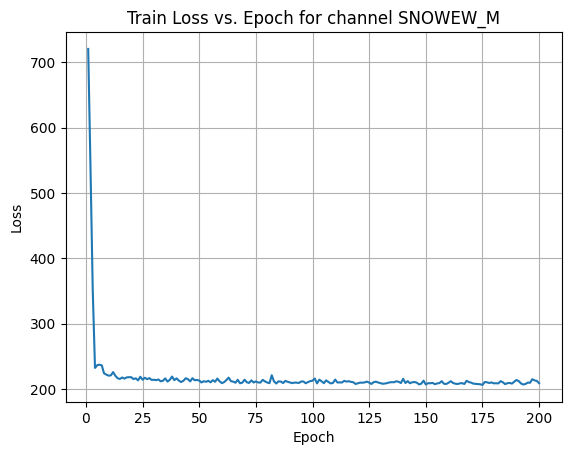

X Channel name :  SNOWAGE_HR
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<01:01,  3.22it/s]

Epoch [1/200] Loss: 656.6864


 10%|█         | 21/200 [00:06<00:56,  3.17it/s]

Epoch [21/200] Loss: 215.9682


 20%|██        | 41/200 [00:12<00:50,  3.17it/s]

Epoch [41/200] Loss: 211.3083


 30%|███       | 61/200 [00:19<00:43,  3.19it/s]

Epoch [61/200] Loss: 213.7716


 40%|████      | 81/200 [00:25<00:36,  3.23it/s]

Epoch [81/200] Loss: 210.4161


 50%|█████     | 101/200 [00:31<00:31,  3.16it/s]

Epoch [101/200] Loss: 208.3461


 60%|██████    | 121/200 [00:38<00:24,  3.22it/s]

Epoch [121/200] Loss: 210.5009


 70%|███████   | 141/200 [00:44<00:18,  3.19it/s]

Epoch [141/200] Loss: 210.7708


 80%|████████  | 161/200 [00:50<00:11,  3.26it/s]

Epoch [161/200] Loss: 208.3222


 90%|█████████ | 181/200 [00:56<00:06,  3.16it/s]

Epoch [181/200] Loss: 208.7196


100%|██████████| 200/200 [01:02<00:00,  3.18it/s]

Average Test Loss: 198.2665


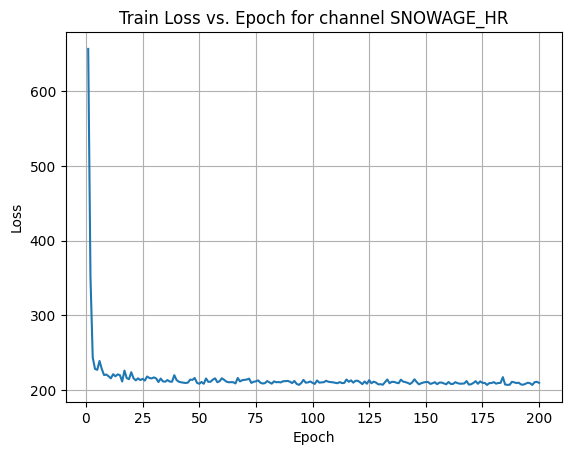

X Channel name :  PRATE_MMpH
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<01:02,  3.17it/s]

Epoch [1/200] Loss: 598.2960


 10%|█         | 21/200 [00:06<00:56,  3.17it/s]

Epoch [21/200] Loss: 227.3699


 20%|██        | 41/200 [00:12<00:49,  3.18it/s]

Epoch [41/200] Loss: 219.5535


 30%|███       | 61/200 [00:19<00:43,  3.19it/s]

Epoch [61/200] Loss: 210.1886


 40%|████      | 81/200 [00:25<00:37,  3.16it/s]

Epoch [81/200] Loss: 210.2708


 50%|█████     | 101/200 [00:31<00:31,  3.14it/s]

Epoch [101/200] Loss: 209.0613


 60%|██████    | 121/200 [00:38<00:24,  3.17it/s]

Epoch [121/200] Loss: 208.2215


 70%|███████   | 141/200 [00:44<00:18,  3.14it/s]

Epoch [141/200] Loss: 207.7972


 80%|████████  | 161/200 [00:50<00:12,  3.18it/s]

Epoch [161/200] Loss: 213.5013


 90%|█████████ | 181/200 [00:56<00:05,  3.25it/s]

Epoch [181/200] Loss: 208.5548


100%|██████████| 200/200 [01:02<00:00,  3.18it/s]

Average Test Loss: 199.3592


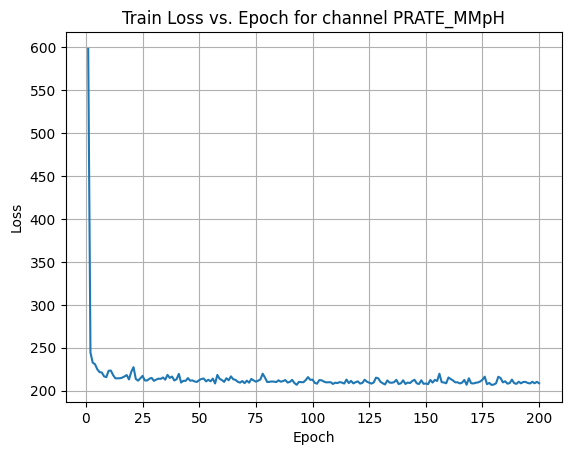

X Channel name :  CLOUD_OD
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<01:01,  3.23it/s]

Epoch [1/200] Loss: 586.9568


 10%|█         | 21/200 [00:06<00:55,  3.20it/s]

Epoch [21/200] Loss: 62.2030


 20%|██        | 41/200 [00:12<00:49,  3.21it/s]

Epoch [41/200] Loss: 21.8947


 30%|███       | 61/200 [00:18<00:41,  3.35it/s]

Epoch [61/200] Loss: 13.4883


 40%|████      | 81/200 [00:25<00:37,  3.16it/s]

Epoch [81/200] Loss: 13.7934


 50%|█████     | 101/200 [00:31<00:31,  3.16it/s]

Epoch [101/200] Loss: 8.8402


 60%|██████    | 121/200 [00:37<00:24,  3.16it/s]

Epoch [121/200] Loss: 8.3218


 70%|███████   | 141/200 [00:44<00:18,  3.17it/s]

Epoch [141/200] Loss: 8.3719


 80%|████████  | 161/200 [00:50<00:12,  3.25it/s]

Epoch [161/200] Loss: 7.2083


 90%|█████████ | 181/200 [00:56<00:05,  3.29it/s]

Epoch [181/200] Loss: 6.5652


100%|██████████| 200/200 [01:02<00:00,  3.20it/s]

Average Test Loss: 7.9540


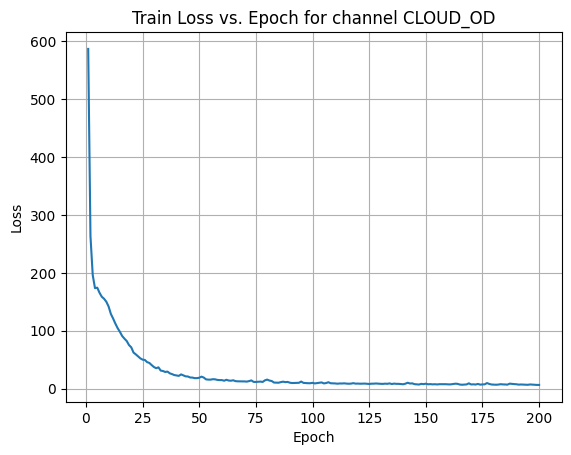

X Channel name :  U10_MpS
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<00:59,  3.33it/s]

Epoch [1/200] Loss: 473.9317


 10%|█         | 21/200 [00:06<00:55,  3.21it/s]

Epoch [21/200] Loss: 69.0522


 20%|██        | 41/200 [00:12<00:48,  3.30it/s]

Epoch [41/200] Loss: 18.4941


 30%|███       | 61/200 [00:18<00:43,  3.19it/s]

Epoch [61/200] Loss: 10.7839


 40%|████      | 81/200 [00:25<00:37,  3.21it/s]

Epoch [81/200] Loss: 7.7059


 50%|█████     | 101/200 [00:31<00:31,  3.19it/s]

Epoch [101/200] Loss: 6.4899


 60%|██████    | 121/200 [00:37<00:24,  3.20it/s]

Epoch [121/200] Loss: 5.4837


 70%|███████   | 141/200 [00:43<00:18,  3.25it/s]

Epoch [141/200] Loss: 7.5561


 80%|████████  | 161/200 [00:50<00:12,  3.21it/s]

Epoch [161/200] Loss: 3.8554


 90%|█████████ | 181/200 [00:56<00:05,  3.27it/s]

Epoch [181/200] Loss: 4.0530


100%|██████████| 200/200 [01:02<00:00,  3.21it/s]

Average Test Loss: 3.1830


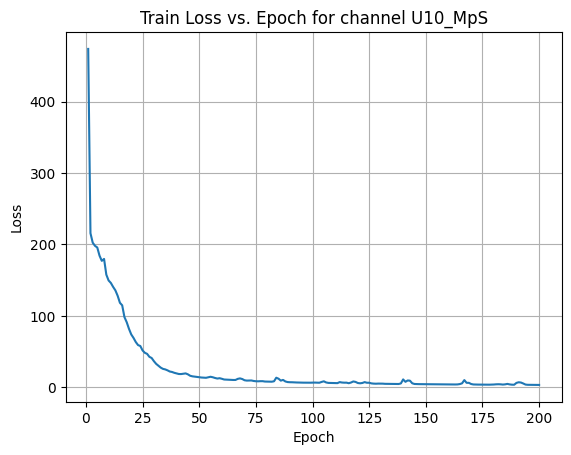

X Channel name :  V10_MpS
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<01:00,  3.29it/s]

Epoch [1/200] Loss: 561.4590


 10%|█         | 21/200 [00:06<00:55,  3.23it/s]

Epoch [21/200] Loss: 71.1724


 20%|██        | 41/200 [00:12<00:49,  3.21it/s]

Epoch [41/200] Loss: 19.3733


 30%|███       | 61/200 [00:19<00:43,  3.21it/s]

Epoch [61/200] Loss: 9.0035


 40%|████      | 81/200 [00:25<00:37,  3.16it/s]

Epoch [81/200] Loss: 7.7880


 50%|█████     | 101/200 [00:31<00:31,  3.18it/s]

Epoch [101/200] Loss: 5.6728


 60%|██████    | 121/200 [00:37<00:24,  3.23it/s]

Epoch [121/200] Loss: 8.2339


 70%|███████   | 141/200 [00:44<00:18,  3.22it/s]

Epoch [141/200] Loss: 3.8740


 80%|████████  | 161/200 [00:50<00:12,  3.24it/s]

Epoch [161/200] Loss: 4.9030


 90%|█████████ | 181/200 [00:56<00:05,  3.22it/s]

Epoch [181/200] Loss: 4.0399


100%|██████████| 200/200 [01:02<00:00,  3.21it/s]

Average Test Loss: 3.4703


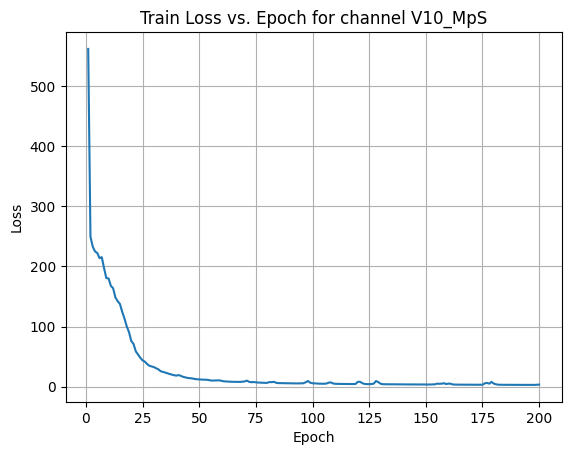

X Channel name :  T2_K
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<00:58,  3.37it/s]

Epoch [1/200] Loss: 4816.9447


 10%|█         | 21/200 [00:06<00:57,  3.13it/s]

Epoch [21/200] Loss: 234.2117


 20%|██        | 41/200 [00:12<00:49,  3.21it/s]

Epoch [41/200] Loss: 222.6848


 30%|███       | 61/200 [00:19<00:43,  3.19it/s]

Epoch [61/200] Loss: 215.6618


 40%|████      | 81/200 [00:25<00:37,  3.18it/s]

Epoch [81/200] Loss: 213.7606


 50%|█████     | 101/200 [00:31<00:30,  3.22it/s]

Epoch [101/200] Loss: 213.5892


 60%|██████    | 121/200 [00:37<00:25,  3.15it/s]

Epoch [121/200] Loss: 211.2940


 70%|███████   | 141/200 [00:44<00:18,  3.23it/s]

Epoch [141/200] Loss: 213.9061


 80%|████████  | 161/200 [00:50<00:12,  3.23it/s]

Epoch [161/200] Loss: 214.1695


 90%|█████████ | 181/200 [00:56<00:05,  3.26it/s]

Epoch [181/200] Loss: 208.9214


100%|██████████| 200/200 [01:02<00:00,  3.21it/s]


Average Test Loss: 192.4815


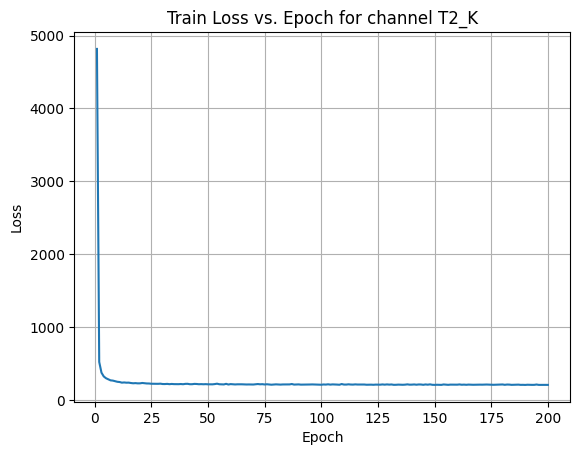

X Channel name :  SWSFC_WpM2
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<00:59,  3.34it/s]

Epoch [1/200] Loss: 512.7773


 10%|█         | 21/200 [00:06<00:54,  3.28it/s]

Epoch [21/200] Loss: 214.1751


 20%|██        | 41/200 [00:12<00:49,  3.23it/s]

Epoch [41/200] Loss: 212.7058


 30%|███       | 61/200 [00:18<00:43,  3.17it/s]

Epoch [61/200] Loss: 214.4303


 40%|████      | 81/200 [00:25<00:36,  3.22it/s]

Epoch [81/200] Loss: 212.5624


 50%|█████     | 101/200 [00:31<00:31,  3.18it/s]

Epoch [101/200] Loss: 208.8632


 60%|██████    | 121/200 [00:37<00:24,  3.19it/s]

Epoch [121/200] Loss: 210.4221


 70%|███████   | 141/200 [00:43<00:18,  3.19it/s]

Epoch [141/200] Loss: 209.8110


 80%|████████  | 161/200 [00:50<00:12,  3.24it/s]

Epoch [161/200] Loss: 207.3880


 90%|█████████ | 181/200 [00:56<00:05,  3.24it/s]

Epoch [181/200] Loss: 207.7816


100%|██████████| 200/200 [01:02<00:00,  3.22it/s]

Average Test Loss: 191.0656


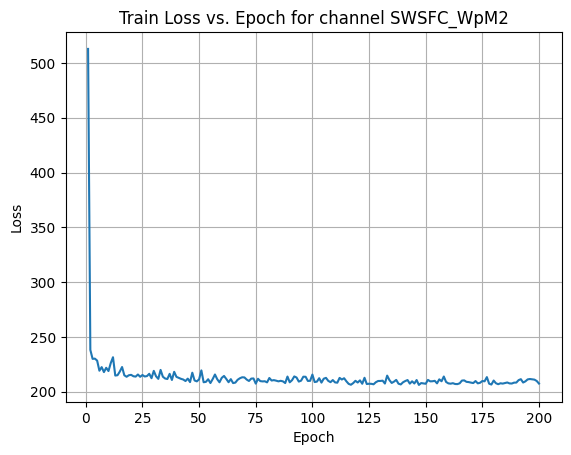

X Channel name :  SOLM_M3pM3
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<00:58,  3.40it/s]

Epoch [1/200] Loss: 574.8718


 10%|█         | 21/200 [00:06<00:54,  3.26it/s]

Epoch [21/200] Loss: 181.5824


 20%|██        | 41/200 [00:12<00:49,  3.23it/s]

Epoch [41/200] Loss: 115.5675


 30%|███       | 61/200 [00:18<00:42,  3.25it/s]

Epoch [61/200] Loss: 39.5182


 40%|████      | 81/200 [00:24<00:36,  3.22it/s]

Epoch [81/200] Loss: 16.1863


 50%|█████     | 101/200 [00:31<00:30,  3.26it/s]

Epoch [101/200] Loss: 11.7081


 60%|██████    | 121/200 [00:37<00:24,  3.21it/s]

Epoch [121/200] Loss: 8.9398


 70%|███████   | 141/200 [00:43<00:18,  3.25it/s]

Epoch [141/200] Loss: 8.2249


 80%|████████  | 161/200 [00:49<00:12,  3.22it/s]

Epoch [161/200] Loss: 6.6518


 90%|█████████ | 181/200 [00:55<00:05,  3.21it/s]

Epoch [181/200] Loss: 5.9480


100%|██████████| 200/200 [01:01<00:00,  3.24it/s]

Average Test Loss: 5.3015


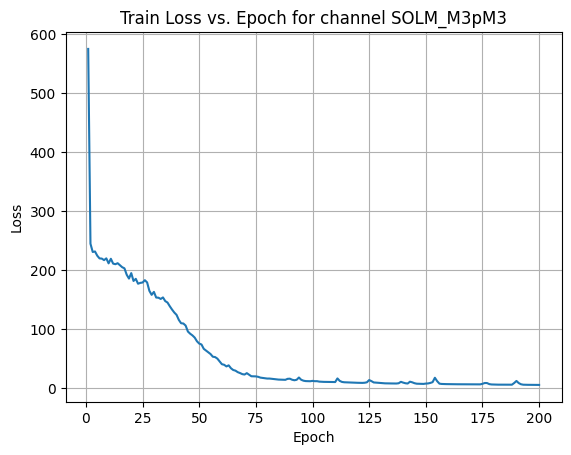

X Channel name :  CLDTOP_KM
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<00:58,  3.39it/s]

Epoch [1/200] Loss: 647.1522


 10%|█         | 21/200 [00:06<00:55,  3.21it/s]

Epoch [21/200] Loss: 215.3608


 20%|██        | 41/200 [00:12<00:49,  3.19it/s]

Epoch [41/200] Loss: 211.6647


 30%|███       | 61/200 [00:19<00:44,  3.10it/s]

Epoch [61/200] Loss: 209.6907


 40%|████      | 81/200 [00:25<00:37,  3.18it/s]

Epoch [81/200] Loss: 211.7445


 50%|█████     | 101/200 [00:31<00:31,  3.17it/s]

Epoch [101/200] Loss: 207.4063


 60%|██████    | 121/200 [00:38<00:24,  3.20it/s]

Epoch [121/200] Loss: 207.9890


 70%|███████   | 141/200 [00:44<00:18,  3.25it/s]

Epoch [141/200] Loss: 207.9899


 80%|████████  | 161/200 [00:50<00:12,  3.21it/s]

Epoch [161/200] Loss: 209.2992


 90%|█████████ | 181/200 [00:56<00:05,  3.20it/s]

Epoch [181/200] Loss: 213.8687


100%|██████████| 200/200 [01:02<00:00,  3.20it/s]

Average Test Loss: 191.1090


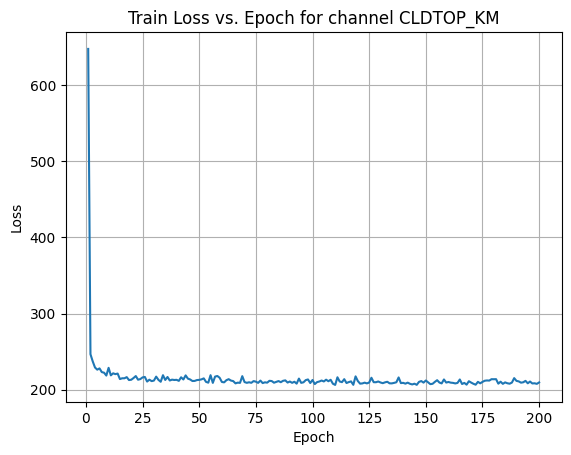

X Channel name :  CAPE
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<01:00,  3.30it/s]

Epoch [1/200] Loss: 589.8784


 10%|█         | 21/200 [00:06<00:56,  3.15it/s]

Epoch [21/200] Loss: 213.6897


 20%|██        | 41/200 [00:12<00:50,  3.14it/s]

Epoch [41/200] Loss: 215.2983


 30%|███       | 61/200 [00:19<00:43,  3.17it/s]

Epoch [61/200] Loss: 216.7662


 40%|████      | 81/200 [00:25<00:35,  3.31it/s]

Epoch [81/200] Loss: 213.0695


 50%|█████     | 101/200 [00:31<00:29,  3.30it/s]

Epoch [101/200] Loss: 214.7085


 60%|██████    | 121/200 [00:37<00:24,  3.22it/s]

Epoch [121/200] Loss: 213.2036


 70%|███████   | 141/200 [00:43<00:18,  3.24it/s]

Epoch [141/200] Loss: 212.2645


 80%|████████  | 161/200 [00:49<00:11,  3.34it/s]

Epoch [161/200] Loss: 207.4999


 90%|█████████ | 181/200 [00:56<00:05,  3.21it/s]

Epoch [181/200] Loss: 213.0907


100%|██████████| 200/200 [01:01<00:00,  3.23it/s]

Average Test Loss: 191.7055


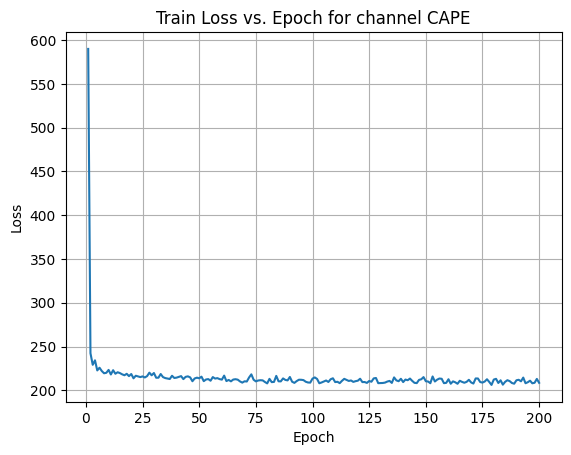

X Channel name :  PBL_WRF_M
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<01:00,  3.27it/s]

Epoch [1/200] Loss: 613.1753


 10%|█         | 21/200 [00:06<00:55,  3.24it/s]

Epoch [21/200] Loss: 215.8198


 20%|██        | 41/200 [00:12<00:49,  3.21it/s]

Epoch [41/200] Loss: 211.0306


 30%|███       | 61/200 [00:19<00:42,  3.27it/s]

Epoch [61/200] Loss: 210.1862


 40%|████      | 81/200 [00:25<00:38,  3.11it/s]

Epoch [81/200] Loss: 208.5808


 50%|█████     | 101/200 [00:31<00:30,  3.24it/s]

Epoch [101/200] Loss: 208.4701


 60%|██████    | 121/200 [00:37<00:24,  3.18it/s]

Epoch [121/200] Loss: 209.8240


 70%|███████   | 141/200 [00:44<00:18,  3.19it/s]

Epoch [141/200] Loss: 208.0958


 80%|████████  | 161/200 [00:50<00:12,  3.19it/s]

Epoch [161/200] Loss: 209.3367


 90%|█████████ | 181/200 [00:56<00:05,  3.24it/s]

Epoch [181/200] Loss: 207.0369


100%|██████████| 200/200 [01:02<00:00,  3.19it/s]

Average Test Loss: 192.7273


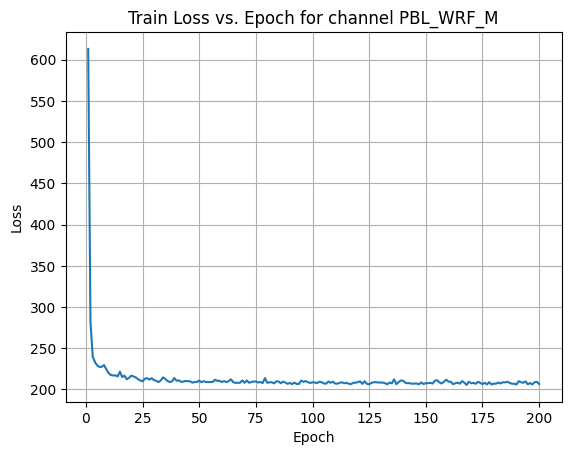

X Channel name :  PBL_YSU_M
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<01:00,  3.28it/s]

Epoch [1/200] Loss: 419.9077


 10%|█         | 21/200 [00:06<00:55,  3.20it/s]

Epoch [21/200] Loss: 210.7698


 20%|██        | 41/200 [00:12<00:48,  3.25it/s]

Epoch [41/200] Loss: 208.6584


 30%|███       | 61/200 [00:18<00:43,  3.20it/s]

Epoch [61/200] Loss: 210.8284


 40%|████      | 81/200 [00:25<00:37,  3.19it/s]

Epoch [81/200] Loss: 208.8175


 50%|█████     | 101/200 [00:31<00:31,  3.18it/s]

Epoch [101/200] Loss: 206.5321


 60%|██████    | 121/200 [00:37<00:24,  3.21it/s]

Epoch [121/200] Loss: 207.8562


 70%|███████   | 141/200 [00:44<00:18,  3.20it/s]

Epoch [141/200] Loss: 207.3433


 80%|████████  | 161/200 [00:50<00:12,  3.16it/s]

Epoch [161/200] Loss: 206.2741


 90%|█████████ | 181/200 [00:57<00:06,  3.01it/s]

Epoch [181/200] Loss: 207.5728


100%|██████████| 200/200 [01:02<00:00,  3.18it/s]

Average Test Loss: 194.3204


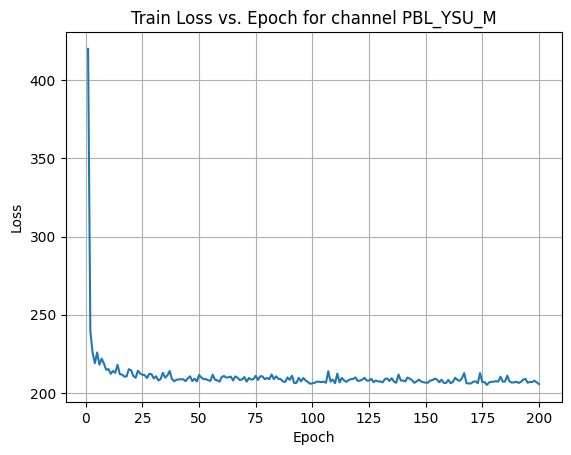

In [ ]:
test_loss_list_P_25_conv_auto_unet = [] 
y_channel = 0 # selecting P25 as output
# x_channel = 0
for x_channel in range(X.shape[1]):
    ####################### Selecting the channel #######################
    print('X Channel name : ', target_var_96_list[x_channel])
    X_train = X_train_all[:, x_channel:x_channel+1, :,:]
    X_test = X_test_all[:, x_channel:x_channel+1, :,:]
    y_train = y_train_all[:, y_channel:y_channel+1, :,:]
    y_test = y_test_all[:, y_channel:y_channel+1, :,:]
    print('Shapes: ', X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    ####################### Creating the dataset loader #######################
    train_custom_dataset = CustomDataset(X_train, y_train)
    # print(len(train_custom_dataset))
    batch_size = 32
    train_loader = data.DataLoader(train_custom_dataset, batch_size=batch_size, shuffle=True)
    # print(len(train_loader))
    
    test_custom_dataset = CustomDataset(X_test, y_test)
    # print(len(test_custom_dataset))
    batch_size = 32
    test_loader = data.DataLoader(test_custom_dataset, batch_size=batch_size, shuffle=False)
    # print(len(test_loader))
    

    #################### Training the model ####################
    model = Autoencoder_UNET(image_size = 80, num_input_channels = 1, num_output_channels=1, c_hid = 8, latent_dim = 512, activation= nn.GELU)

    model.to(device)
    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    losses = []
    # Training loop
    num_epochs = 200
    for epoch in trange(num_epochs):
        model.train()  # Set the model to training mode
        total_loss = 0.0
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()  # Zero the gradients
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Forward pass
            outputs = model(inputs)
            
            # Calculate the loss
            loss = criterion(outputs, targets)
            
            # Backpropagation
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        # Print the average loss for this epoch
        average_loss = total_loss / len(train_loader)
        losses.append(average_loss)
        if epoch % 20 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {average_loss:.4f}")
    
    ############################# testing the model #############################
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Forward pass
            outputs = model(inputs)
            # Calculate the loss
            loss = criterion(outputs, targets)
            test_loss += loss.item()

    # Print the average test loss
    average_test_loss = test_loss / len(test_loader)
    test_loss_list_P_25_conv_auto_unet.append(average_test_loss)
    print(f"Average Test Loss: {average_test_loss:.4f}")
    plt.plot(range(1, num_epochs + 1), losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train Loss vs. Epoch for channel '+target_var_96_list[x_channel])
    plt.grid(True) 
    plt.show() 

In [ ]:
test_loss_list_P_25_conv_auto_unet

[192.86672002618963,
 191.87428977272728,
 198.26652665571734,
 199.35923628373578,
 7.954025506973267,
 3.18301400271329,
 3.4703480113636362,
 192.4814786044034,
 191.06564331054688,
 5.301476088437167,
 191.10903930664062,
 191.70547346635297,
 192.72732405229047,
 194.32039434259588]

In [ ]:
name_loss_pairs = list(zip(target_var_96_list, test_loss_list_P_25_conv_auto_unet))

# Sort based on loss values
sorted_name_loss_pairs = sorted(name_loss_pairs, key=lambda x: x[1])
for pair in sorted_name_loss_pairs:
    print(pair)
# print(sorted_name_loss_pairs)
# Select the lowest 3 names
lowest_3_names = [pair[0] for pair in sorted_name_loss_pairs[:3]]

print("Lowest 3 names:", lowest_3_names)

('U10_MpS', 3.18301400271329)
('V10_MpS', 3.4703480113636362)
('SOLM_M3pM3', 5.301476088437167)
('CLOUD_OD', 7.954025506973267)
('SWSFC_WpM2', 191.06564331054688)
('CLDTOP_KM', 191.10903930664062)
('CAPE', 191.70547346635297)
('SNOWEW_M', 191.87428977272728)
('T2_K', 192.4814786044034)
('PBL_WRF_M', 192.72732405229047)
('TSURF_K', 192.86672002618963)
('PBL_YSU_M', 194.32039434259588)
('SNOWAGE_HR', 198.26652665571734)
('PRATE_MMpH', 199.35923628373578)
Lowest 3 names: ['U10_MpS', 'V10_MpS', 'SOLM_M3pM3']


In [ ]:
summary(model, input_size=(1, 80, 80))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 40, 40]              80
              GELU-2            [-1, 8, 40, 40]               0
            Conv2d-3            [-1, 8, 40, 40]             584
              GELU-4            [-1, 8, 40, 40]               0
            Conv2d-5           [-1, 16, 20, 20]           1,168
              GELU-6           [-1, 16, 20, 20]               0
            Conv2d-7           [-1, 16, 20, 20]           2,320
              GELU-8           [-1, 16, 20, 20]               0
            Conv2d-9           [-1, 32, 10, 10]           4,640
             GELU-10           [-1, 32, 10, 10]               0
          Flatten-11                 [-1, 3200]               0
           Linear-12                  [-1, 512]       1,638,912
           Linear-13                 [-1, 3200]       1,641,600
        Unflatten-14           [-1, 32,

In [ ]:
summary(model, input_size=(1, 80, 80)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 40, 40]              80
              GELU-2            [-1, 8, 40, 40]               0
            Conv2d-3            [-1, 8, 40, 40]             584
              GELU-4            [-1, 8, 40, 40]               0
            Conv2d-5           [-1, 16, 20, 20]           1,168
              GELU-6           [-1, 16, 20, 20]               0
            Conv2d-7           [-1, 16, 20, 20]           2,320
              GELU-8           [-1, 16, 20, 20]               0
            Conv2d-9           [-1, 32, 10, 10]           4,640
             GELU-10           [-1, 32, 10, 10]               0
          Flatten-11                 [-1, 3200]               0
           Linear-12                 [-1, 1024]       3,277,824
          Encoder-13                 [-1, 1024]               0
           Linear-14                 [-

## Single channel input single channel output(P10) UNET

X Channel name :  TSURF_K
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<01:04,  3.10it/s]

Epoch [1/200] Loss: 9347.3935


 10%|█         | 21/200 [00:06<00:55,  3.21it/s]

Epoch [21/200] Loss: 445.2209


 20%|██        | 41/200 [00:12<00:49,  3.24it/s]

Epoch [41/200] Loss: 421.8352


 30%|███       | 61/200 [00:19<00:43,  3.21it/s]

Epoch [61/200] Loss: 411.4913


 40%|████      | 81/200 [00:25<00:37,  3.20it/s]

Epoch [81/200] Loss: 406.5355


 50%|█████     | 101/200 [00:31<00:31,  3.19it/s]

Epoch [101/200] Loss: 410.0266


 60%|██████    | 121/200 [00:37<00:24,  3.21it/s]

Epoch [121/200] Loss: 403.3963


 70%|███████   | 141/200 [00:44<00:18,  3.24it/s]

Epoch [141/200] Loss: 402.2838


 80%|████████  | 161/200 [00:50<00:12,  3.14it/s]

Epoch [161/200] Loss: 404.5083


 90%|█████████ | 181/200 [00:56<00:05,  3.23it/s]

Epoch [181/200] Loss: 408.9846


100%|██████████| 200/200 [01:02<00:00,  3.18it/s]

Average Test Loss: 393.9739


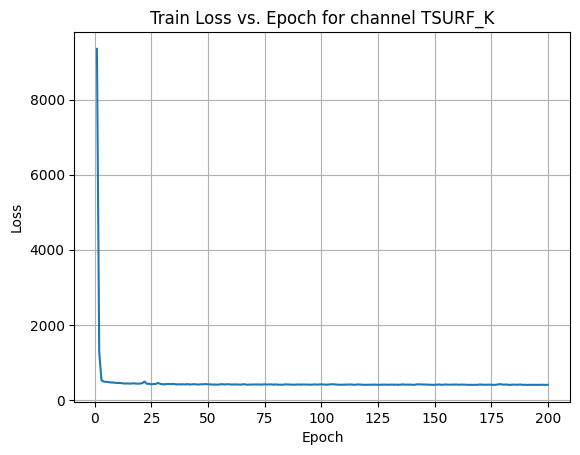

X Channel name :  SNOWEW_M
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<01:01,  3.23it/s]

Epoch [1/200] Loss: 1062.0485


 10%|█         | 21/200 [00:06<00:57,  3.13it/s]

Epoch [21/200] Loss: 425.7831


 20%|██        | 41/200 [00:12<00:50,  3.16it/s]

Epoch [41/200] Loss: 414.1087


 30%|███       | 61/200 [00:19<00:43,  3.21it/s]

Epoch [61/200] Loss: 407.9692


 40%|████      | 81/200 [00:25<00:37,  3.13it/s]

Epoch [81/200] Loss: 409.0262


 50%|█████     | 101/200 [00:31<00:29,  3.32it/s]

Epoch [101/200] Loss: 413.5665


 60%|██████    | 121/200 [00:37<00:24,  3.19it/s]

Epoch [121/200] Loss: 406.8342


 70%|███████   | 141/200 [00:44<00:18,  3.20it/s]

Epoch [141/200] Loss: 401.0203


 80%|████████  | 161/200 [00:50<00:12,  3.16it/s]

Epoch [161/200] Loss: 403.7887


 90%|█████████ | 181/200 [00:56<00:05,  3.18it/s]

Epoch [181/200] Loss: 412.0851


100%|██████████| 200/200 [01:02<00:00,  3.18it/s]


Average Test Loss: 384.9228


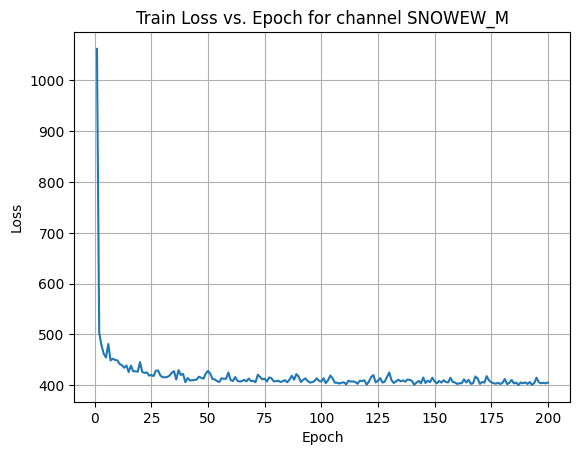

X Channel name :  SNOWAGE_HR
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<01:02,  3.19it/s]

Epoch [1/200] Loss: 1334.1772


 10%|█         | 21/200 [00:06<00:55,  3.24it/s]

Epoch [21/200] Loss: 432.3582


 20%|██        | 41/200 [00:12<00:51,  3.09it/s]

Epoch [41/200] Loss: 416.2745


 30%|███       | 61/200 [00:19<00:42,  3.27it/s]

Epoch [61/200] Loss: 412.7553


 40%|████      | 81/200 [00:25<00:36,  3.29it/s]

Epoch [81/200] Loss: 411.6587


 50%|█████     | 101/200 [00:31<00:30,  3.28it/s]

Epoch [101/200] Loss: 409.5164


 60%|██████    | 121/200 [00:37<00:25,  3.11it/s]

Epoch [121/200] Loss: 409.2917


 70%|███████   | 141/200 [00:43<00:18,  3.17it/s]

Epoch [141/200] Loss: 414.7216


 80%|████████  | 161/200 [00:50<00:12,  3.23it/s]

Epoch [161/200] Loss: 405.0483


 90%|█████████ | 181/200 [00:56<00:05,  3.18it/s]

Epoch [181/200] Loss: 404.8374


100%|██████████| 200/200 [01:02<00:00,  3.19it/s]


Average Test Loss: 366.9726


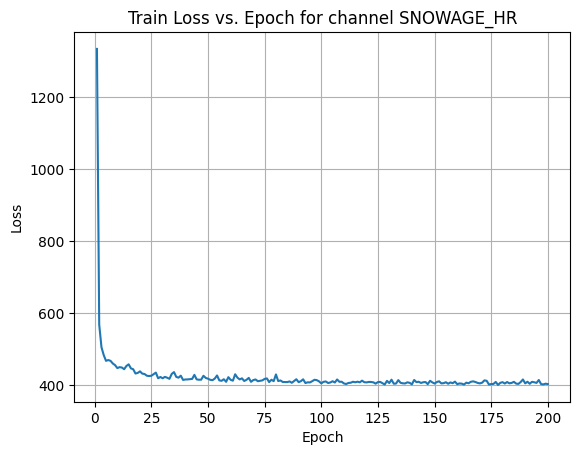

X Channel name :  PRATE_MMpH
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<01:07,  2.95it/s]

Epoch [1/200] Loss: 1228.4596


 10%|█         | 21/200 [00:06<00:56,  3.19it/s]

Epoch [21/200] Loss: 418.4353


 20%|██        | 41/200 [00:13<00:49,  3.20it/s]

Epoch [41/200] Loss: 411.4351


 30%|███       | 61/200 [00:19<00:42,  3.30it/s]

Epoch [61/200] Loss: 411.3802


 40%|████      | 81/200 [00:25<00:36,  3.27it/s]

Epoch [81/200] Loss: 408.2070


 50%|█████     | 101/200 [00:31<00:30,  3.29it/s]

Epoch [101/200] Loss: 402.7285


 60%|██████    | 121/200 [00:38<00:24,  3.26it/s]

Epoch [121/200] Loss: 405.0596


 70%|███████   | 141/200 [00:44<00:18,  3.19it/s]

Epoch [141/200] Loss: 401.6986


 80%|████████  | 161/200 [00:50<00:12,  3.22it/s]

Epoch [161/200] Loss: 401.9078


 90%|█████████ | 181/200 [00:56<00:06,  3.16it/s]

Epoch [181/200] Loss: 405.1741


100%|██████████| 200/200 [01:02<00:00,  3.19it/s]

Average Test Loss: 397.5330


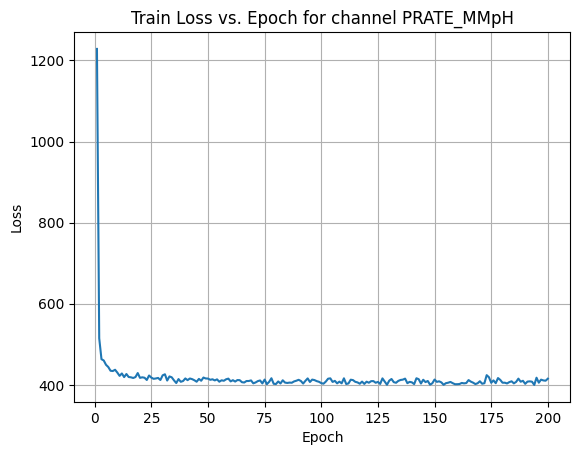

X Channel name :  CLOUD_OD
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<01:00,  3.28it/s]

Epoch [1/200] Loss: 1086.5345


 10%|█         | 21/200 [00:06<00:54,  3.29it/s]

Epoch [21/200] Loss: 115.0784


 20%|██        | 41/200 [00:12<00:48,  3.26it/s]

Epoch [41/200] Loss: 55.1418


 30%|███       | 61/200 [00:18<00:41,  3.35it/s]

Epoch [61/200] Loss: 35.0410


 40%|████      | 81/200 [00:24<00:35,  3.32it/s]

Epoch [81/200] Loss: 25.9328


 50%|█████     | 101/200 [00:31<00:30,  3.27it/s]

Epoch [101/200] Loss: 22.8977


 60%|██████    | 121/200 [00:37<00:23,  3.32it/s]

Epoch [121/200] Loss: 22.6624


 70%|███████   | 141/200 [00:43<00:18,  3.15it/s]

Epoch [141/200] Loss: 18.5878


 80%|████████  | 161/200 [00:49<00:11,  3.25it/s]

Epoch [161/200] Loss: 16.7638


 90%|█████████ | 181/200 [00:55<00:05,  3.31it/s]

Epoch [181/200] Loss: 18.7935


100%|██████████| 200/200 [01:01<00:00,  3.27it/s]

Average Test Loss: 16.7694


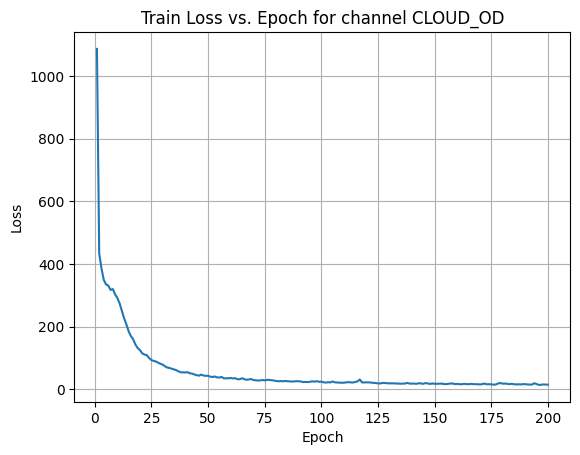

X Channel name :  U10_MpS
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<00:58,  3.40it/s]

Epoch [1/200] Loss: 1370.2549


 10%|█         | 21/200 [00:06<00:53,  3.35it/s]

Epoch [21/200] Loss: 253.0794


 20%|██        | 41/200 [00:12<00:48,  3.29it/s]

Epoch [41/200] Loss: 73.3127


 30%|███       | 61/200 [00:18<00:44,  3.12it/s]

Epoch [61/200] Loss: 34.2972


 40%|████      | 81/200 [00:24<00:37,  3.16it/s]

Epoch [81/200] Loss: 23.2712


 50%|█████     | 101/200 [00:31<00:30,  3.21it/s]

Epoch [101/200] Loss: 18.8157


 60%|██████    | 121/200 [00:37<00:25,  3.14it/s]

Epoch [121/200] Loss: 17.0560


 70%|███████   | 141/200 [00:43<00:17,  3.46it/s]

Epoch [141/200] Loss: 13.7983


 80%|████████  | 161/200 [00:49<00:12,  3.23it/s]

Epoch [161/200] Loss: 12.2436


 90%|█████████ | 181/200 [00:55<00:05,  3.21it/s]

Epoch [181/200] Loss: 11.2890


100%|██████████| 200/200 [01:01<00:00,  3.26it/s]

Average Test Loss: 16.9951


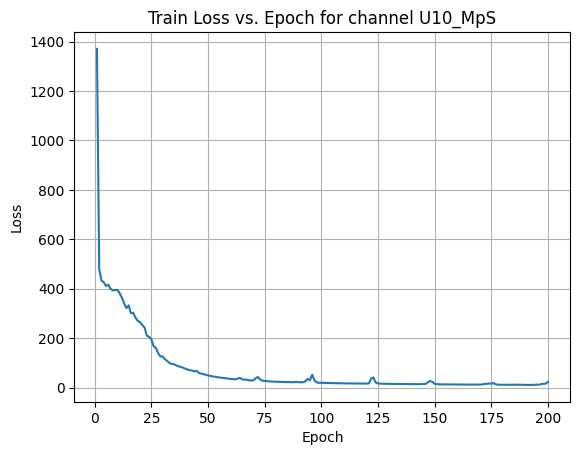

X Channel name :  V10_MpS
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<01:00,  3.28it/s]

Epoch [1/200] Loss: 1202.3667


 10%|█         | 21/200 [00:06<00:54,  3.29it/s]

Epoch [21/200] Loss: 284.9583


 20%|██        | 41/200 [00:12<00:48,  3.26it/s]

Epoch [41/200] Loss: 49.5132


 30%|███       | 61/200 [00:18<00:42,  3.29it/s]

Epoch [61/200] Loss: 23.7217


 40%|████      | 81/200 [00:24<00:37,  3.18it/s]

Epoch [81/200] Loss: 16.5870


 50%|█████     | 101/200 [00:31<00:29,  3.36it/s]

Epoch [101/200] Loss: 13.4451


 60%|██████    | 121/200 [00:39<00:33,  2.34it/s]

Epoch [121/200] Loss: 11.5799


 70%|███████   | 141/200 [00:47<00:25,  2.32it/s]

Epoch [141/200] Loss: 10.4765


 80%|████████  | 161/200 [00:55<00:15,  2.44it/s]

Epoch [161/200] Loss: 13.5249


 90%|█████████ | 181/200 [01:03<00:06,  3.06it/s]

Epoch [181/200] Loss: 9.1645


100%|██████████| 200/200 [01:10<00:00,  2.85it/s]


Average Test Loss: 8.1653


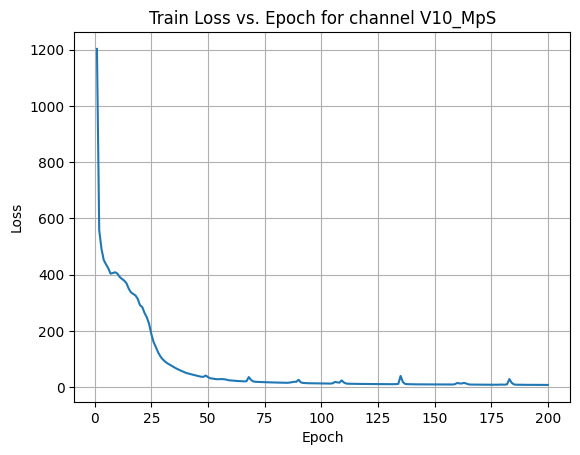

X Channel name :  T2_K
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<01:01,  3.25it/s]

Epoch [1/200] Loss: 1344.0557


 10%|█         | 21/200 [00:08<01:31,  1.95it/s]

Epoch [21/200] Loss: 410.2120


 20%|██        | 41/200 [00:15<00:48,  3.25it/s]

Epoch [41/200] Loss: 409.9936


 30%|███       | 61/200 [00:21<00:42,  3.27it/s]

Epoch [61/200] Loss: 403.0425


 40%|████      | 81/200 [00:27<00:34,  3.47it/s]

Epoch [81/200] Loss: 413.2495


 50%|█████     | 101/200 [00:33<00:32,  3.06it/s]

Epoch [101/200] Loss: 410.5454


 60%|██████    | 121/200 [00:41<00:22,  3.51it/s]

Epoch [121/200] Loss: 408.9813


 70%|███████   | 141/200 [00:46<00:16,  3.63it/s]

Epoch [141/200] Loss: 404.3268


 80%|████████  | 161/200 [00:52<00:11,  3.53it/s]

Epoch [161/200] Loss: 402.1354


 90%|█████████ | 181/200 [00:58<00:05,  3.47it/s]

Epoch [181/200] Loss: 403.1094


100%|██████████| 200/200 [01:03<00:00,  3.14it/s]


Average Test Loss: 370.9240


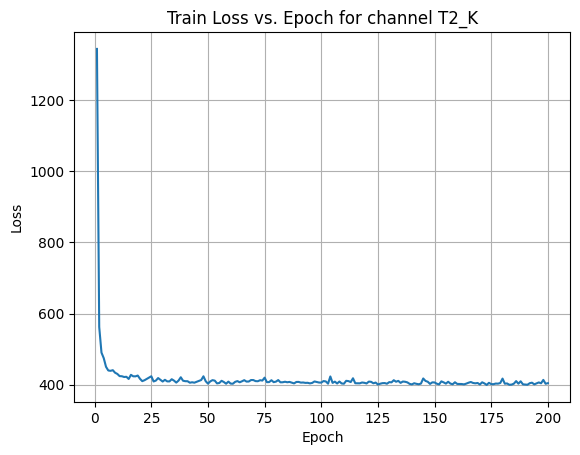

X Channel name :  SWSFC_WpM2
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<01:13,  2.70it/s]

Epoch [1/200] Loss: 1138.2640


 10%|█         | 21/200 [00:06<00:51,  3.49it/s]

Epoch [21/200] Loss: 428.3663


 20%|██        | 41/200 [00:11<00:45,  3.49it/s]

Epoch [41/200] Loss: 428.3100


 30%|███       | 61/200 [00:17<00:39,  3.49it/s]

Epoch [61/200] Loss: 411.9817


 40%|████      | 81/200 [00:23<00:34,  3.50it/s]

Epoch [81/200] Loss: 406.6649


 50%|█████     | 101/200 [00:29<00:29,  3.36it/s]

Epoch [101/200] Loss: 406.5036


 60%|██████    | 121/200 [00:35<00:22,  3.47it/s]

Epoch [121/200] Loss: 404.4717


 70%|███████   | 141/200 [00:41<00:16,  3.52it/s]

Epoch [141/200] Loss: 413.3260


 80%|████████  | 161/200 [00:46<00:10,  3.61it/s]

Epoch [161/200] Loss: 404.8024


 90%|█████████ | 181/200 [00:52<00:05,  3.50it/s]

Epoch [181/200] Loss: 408.2683


100%|██████████| 200/200 [00:58<00:00,  3.45it/s]


Average Test Loss: 375.5593


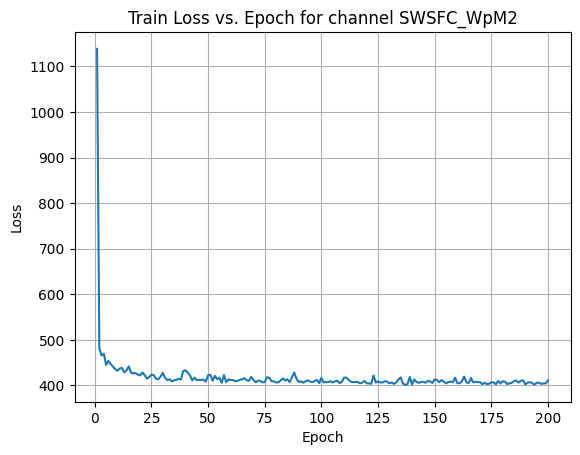

X Channel name :  SOLM_M3pM3
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<00:57,  3.47it/s]

Epoch [1/200] Loss: 1171.9761


 10%|█         | 21/200 [00:06<00:52,  3.40it/s]

Epoch [21/200] Loss: 311.1736


 20%|██        | 41/200 [00:11<00:46,  3.43it/s]

Epoch [41/200] Loss: 213.8882


 30%|███       | 61/200 [00:17<00:40,  3.43it/s]

Epoch [61/200] Loss: 86.1118


 40%|████      | 81/200 [00:23<00:35,  3.37it/s]

Epoch [81/200] Loss: 43.9884


 50%|█████     | 101/200 [00:34<00:50,  1.95it/s]

Epoch [101/200] Loss: 33.4366


 60%|██████    | 121/200 [00:48<00:21,  3.66it/s]

Epoch [121/200] Loss: 26.7442


 70%|███████   | 141/200 [00:54<00:17,  3.45it/s]

Epoch [141/200] Loss: 25.1023


 80%|████████  | 161/200 [00:59<00:12,  3.17it/s]

Epoch [161/200] Loss: 19.1235


 90%|█████████ | 181/200 [01:05<00:05,  3.38it/s]

Epoch [181/200] Loss: 16.5218


100%|██████████| 200/200 [01:12<00:00,  2.74it/s]


Average Test Loss: 17.8878


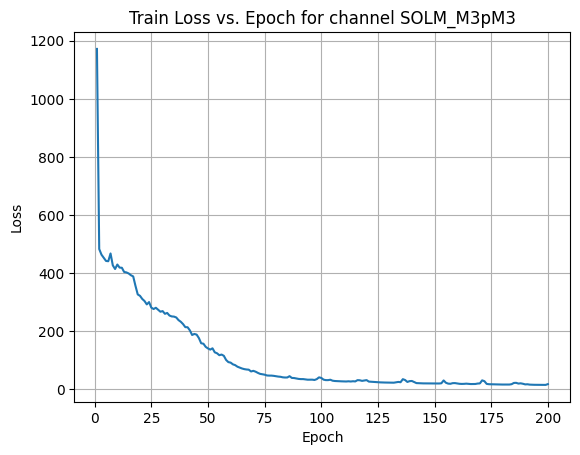

X Channel name :  CLDTOP_KM
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<00:58,  3.40it/s]

Epoch [1/200] Loss: 1209.7468


 10%|█         | 21/200 [00:06<00:51,  3.46it/s]

Epoch [21/200] Loss: 418.6483


 20%|██        | 41/200 [00:12<00:48,  3.31it/s]

Epoch [41/200] Loss: 411.9460


 30%|███       | 61/200 [00:17<00:40,  3.44it/s]

Epoch [61/200] Loss: 416.4541


 40%|████      | 81/200 [00:23<00:34,  3.48it/s]

Epoch [81/200] Loss: 410.3450


 50%|█████     | 101/200 [00:29<00:28,  3.49it/s]

Epoch [101/200] Loss: 404.6752


 60%|██████    | 121/200 [00:35<00:22,  3.50it/s]

Epoch [121/200] Loss: 411.7702


 70%|███████   | 141/200 [00:40<00:17,  3.45it/s]

Epoch [141/200] Loss: 404.7753


 80%|████████  | 161/200 [00:46<00:11,  3.43it/s]

Epoch [161/200] Loss: 410.6092


 90%|█████████ | 181/200 [00:52<00:05,  3.49it/s]

Epoch [181/200] Loss: 406.9762


100%|██████████| 200/200 [00:58<00:00,  3.43it/s]

Average Test Loss: 364.9331


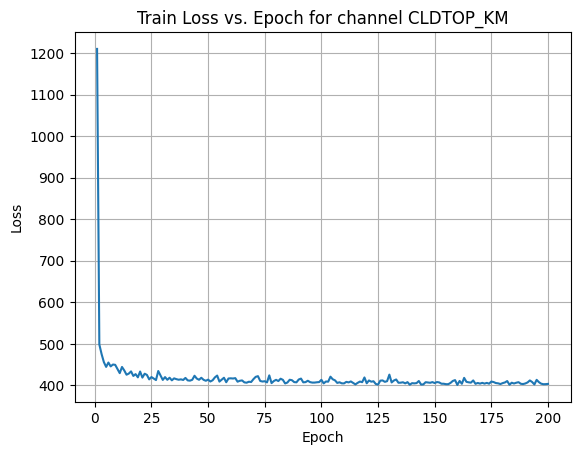

X Channel name :  CAPE
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<01:05,  3.05it/s]

Epoch [1/200] Loss: 1286.6324


 10%|█         | 21/200 [00:06<00:50,  3.56it/s]

Epoch [21/200] Loss: 416.3279


 20%|██        | 41/200 [00:11<00:45,  3.46it/s]

Epoch [41/200] Loss: 412.8959


 30%|███       | 61/200 [00:17<00:39,  3.53it/s]

Epoch [61/200] Loss: 432.9754


 40%|████      | 81/200 [00:23<00:35,  3.37it/s]

Epoch [81/200] Loss: 423.2503


 50%|█████     | 101/200 [00:29<00:26,  3.68it/s]

Epoch [101/200] Loss: 407.6195


 60%|██████    | 121/200 [00:34<00:22,  3.56it/s]

Epoch [121/200] Loss: 405.0848


 70%|███████   | 141/200 [00:40<00:16,  3.55it/s]

Epoch [141/200] Loss: 418.5362


 80%|████████  | 161/200 [00:46<00:11,  3.53it/s]

Epoch [161/200] Loss: 398.3066


 90%|█████████ | 181/200 [00:51<00:05,  3.50it/s]

Epoch [181/200] Loss: 399.7189


100%|██████████| 200/200 [00:57<00:00,  3.49it/s]


Average Test Loss: 366.6939


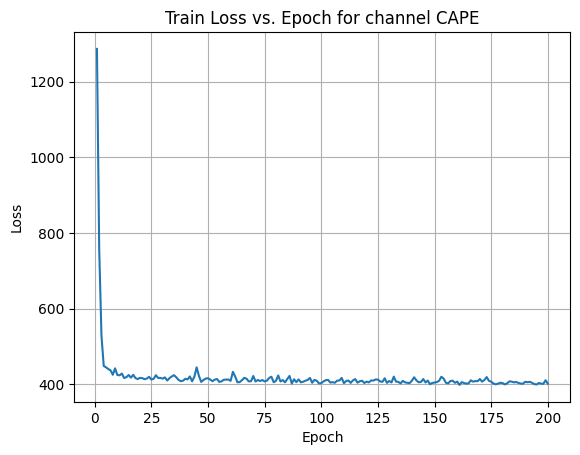

X Channel name :  PBL_WRF_M
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<00:57,  3.44it/s]

Epoch [1/200] Loss: 1160.2099


 10%|█         | 21/200 [00:06<00:52,  3.40it/s]

Epoch [21/200] Loss: 410.9463


 20%|██        | 41/200 [00:11<00:46,  3.43it/s]

Epoch [41/200] Loss: 407.0937


 30%|███       | 61/200 [00:18<00:40,  3.42it/s]

Epoch [61/200] Loss: 406.6331


 40%|████      | 81/200 [00:23<00:33,  3.57it/s]

Epoch [81/200] Loss: 405.4273


 50%|█████     | 101/200 [00:29<00:27,  3.55it/s]

Epoch [101/200] Loss: 406.6442


 60%|██████    | 121/200 [00:35<00:23,  3.32it/s]

Epoch [121/200] Loss: 405.2662


 70%|███████   | 141/200 [00:41<00:17,  3.47it/s]

Epoch [141/200] Loss: 400.4130


 80%|████████  | 161/200 [00:46<00:11,  3.43it/s]

Epoch [161/200] Loss: 403.3931


 90%|█████████ | 181/200 [00:52<00:05,  3.47it/s]

Epoch [181/200] Loss: 409.0273


100%|██████████| 200/200 [00:57<00:00,  3.45it/s]


Average Test Loss: 364.0550


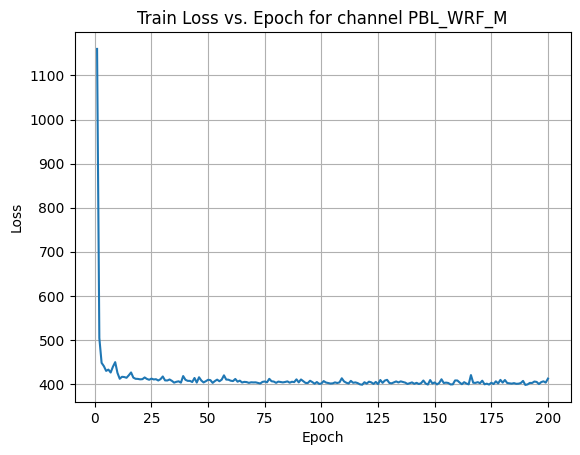

X Channel name :  PBL_YSU_M
Shapes:  (1324, 1, 80, 80) (332, 1, 80, 80) (1324, 1, 80, 80) (332, 1, 80, 80)


  0%|          | 1/200 [00:00<00:54,  3.64it/s]

Epoch [1/200] Loss: 1176.6661


 10%|█         | 21/200 [00:06<00:49,  3.63it/s]

Epoch [21/200] Loss: 410.8530


 20%|██        | 41/200 [00:12<00:47,  3.35it/s]

Epoch [41/200] Loss: 408.6113


 30%|███       | 61/200 [00:17<00:40,  3.41it/s]

Epoch [61/200] Loss: 400.7242


 40%|████      | 81/200 [00:23<00:36,  3.23it/s]

Epoch [81/200] Loss: 407.2048


 50%|█████     | 101/200 [00:30<00:30,  3.24it/s]

Epoch [101/200] Loss: 407.0074


 60%|██████    | 121/200 [00:36<00:25,  3.12it/s]

Epoch [121/200] Loss: 405.1491


 70%|███████   | 141/200 [00:42<00:18,  3.27it/s]

Epoch [141/200] Loss: 428.9850


 80%|████████  | 161/200 [00:48<00:11,  3.32it/s]

Epoch [161/200] Loss: 411.7955


 90%|█████████ | 181/200 [00:54<00:05,  3.29it/s]

Epoch [181/200] Loss: 412.6084


100%|██████████| 200/200 [01:00<00:00,  3.29it/s]

Average Test Loss: 375.2351


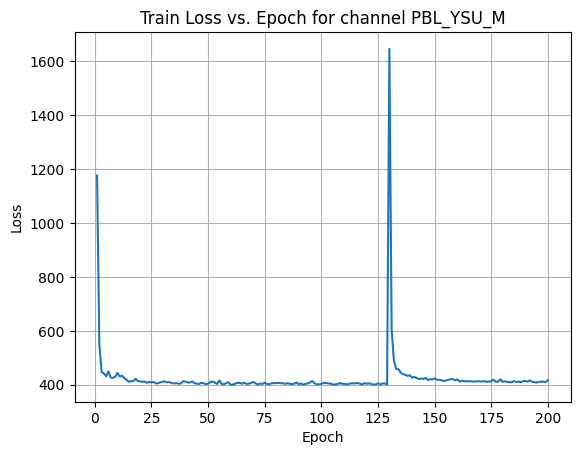

In [ ]:
test_loss_list_P_10_conv_auto_unet = [] 
y_channel = 1 # selecting P10 as output
# x_channel = 0
for x_channel in range(X.shape[1]):
    ####################### Selecting the channel #######################
    print('X Channel name : ', target_var_96_list[x_channel])
    X_train = X_train_all[:, x_channel:x_channel+1, :,:]
    X_test = X_test_all[:, x_channel:x_channel+1, :,:]
    y_train = y_train_all[:, y_channel:y_channel+1, :,:]
    y_test = y_test_all[:, y_channel:y_channel+1, :,:]
    print('Shapes: ', X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    ####################### Creating the dataset loader #######################
    train_custom_dataset = CustomDataset(X_train, y_train)
    # print(len(train_custom_dataset))
    batch_size = 32
    train_loader = data.DataLoader(train_custom_dataset, batch_size=batch_size, shuffle=True)
    # print(len(train_loader))
    
    test_custom_dataset = CustomDataset(X_test, y_test)
    # print(len(test_custom_dataset))
    batch_size = 32
    test_loader = data.DataLoader(test_custom_dataset, batch_size=batch_size, shuffle=False)
    # print(len(test_loader))
    

    #################### Training the model ####################
    model = Autoencoder_UNET(image_size = 80, num_input_channels = 1, num_output_channels=1, c_hid = 8, latent_dim = 512, activation= nn.GELU)

    model.to(device)
    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    losses = []
    # Training loop
    num_epochs = 200
    for epoch in trange(num_epochs):
        model.train()  # Set the model to training mode
        total_loss = 0.0
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()  # Zero the gradients
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Forward pass
            outputs = model(inputs)
            
            # Calculate the loss
            loss = criterion(outputs, targets)
            
            # Backpropagation
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        # Print the average loss for this epoch
        average_loss = total_loss / len(train_loader)
        losses.append(average_loss)
        if epoch % 20 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {average_loss:.4f}")
    
    ############################# testing the model #############################
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Forward pass
            outputs = model(inputs)
            # Calculate the loss
            loss = criterion(outputs, targets)
            test_loss += loss.item()

    # Print the average test loss
    average_test_loss = test_loss / len(test_loader)
    test_loss_list_P_10_conv_auto_unet.append(average_test_loss)
    print(f"Average Test Loss: {average_test_loss:.4f}")
    plt.plot(range(1, num_epochs + 1), losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train Loss vs. Epoch for channel '+target_var_96_list[x_channel])
    plt.grid(True) 
    plt.show() 

In [ ]:
test_loss_list_P_10_conv_auto_unet

[393.97390192205256,
 384.9228349165483,
 366.9725619229403,
 397.5330338911577,
 16.76939444108443,
 16.99508944424716,
 8.165278738195246,
 370.9240167791193,
 375.55933172052556,
 17.88784339211204,
 364.93308327414775,
 366.69390869140625,
 364.0550065474077,
 375.23513239080256]

In [ ]:
name_loss_pairs = list(zip(target_var_96_list, test_loss_list_P_10_conv_auto_unet))

# Sort based on loss values
sorted_name_loss_pairs = sorted(name_loss_pairs, key=lambda x: x[1])
for pair in sorted_name_loss_pairs:
    print(pair)
# print(sorted_name_loss_pairs)
# Select the lowest 3 names
lowest_3_names = [pair[0] for pair in sorted_name_loss_pairs[:3]]

print("Lowest 3 names:", lowest_3_names)

('V10_MpS', 8.165278738195246)
('CLOUD_OD', 16.76939444108443)
('U10_MpS', 16.99508944424716)
('SOLM_M3pM3', 17.88784339211204)
('PBL_WRF_M', 364.0550065474077)
('CLDTOP_KM', 364.93308327414775)
('CAPE', 366.69390869140625)
('SNOWAGE_HR', 366.9725619229403)
('T2_K', 370.9240167791193)
('PBL_YSU_M', 375.23513239080256)
('SWSFC_WpM2', 375.55933172052556)
('SNOWEW_M', 384.9228349165483)
('TSURF_K', 393.97390192205256)
('PRATE_MMpH', 397.5330338911577)
Lowest 3 names: ['V10_MpS', 'CLOUD_OD', 'U10_MpS']


## Insights

In [ ]:
# Adding values at corresponding indices
result = [(x + y)/2 for x, y in zip(test_loss_list_P_10_conv_auto_unet, test_loss_list_P_25_conv_auto_unet)]

# Creating a DataFrame
data_frame = {'Input channel': target_var_96_list, 'P10': test_loss_list_P_10_conv_auto_unet, 'P25': test_loss_list_P_25_conv_auto_unet, 'P10+P25 avg': result}
df = pd.DataFrame(data_frame)

# Sorting the DataFrame based on "List1 + List2"
df_sorted = df.sort_values(by='P10+P25 avg')

# Displaying the sorted DataFrame

df_rounded = df_sorted.round(1)
df_rounded.to_csv('/home/rishabh.mondal/climax_alternative/Climax_2/results/test_loss_list_P_10_P25_conv_auto_unet.csv', index=False)

df_rounded

,Input channel,P10,P25,P10+P25 avg
6,V10_MpS,8.2,3.5,5.8
5,U10_MpS,17.0,3.2,10.1
9,SOLM_M3pM3,17.9,5.3,11.6
4,CLOUD_OD,16.8,8.0,12.4
10,CLDTOP_KM,364.9,191.1,278.0
12,PBL_WRF_M,364.1,192.7,278.4
11,CAPE,366.7,191.7,279.2
7,T2_K,370.9,192.5,281.7
2,SNOWAGE_HR,367.0,198.3,282.6
8,SWSFC_WpM2,375.6,191.1,283.3


## Training on top 4 channel and predicting on all channel UNET

In [ ]:
# target_var_96_list =['TSURF_K',
#        'SNOWEW_M', 'SNOWAGE_HR', 'PRATE_MMpH', 'CLOUD_OD', 'U10_MpS',
#        'V10_MpS', 'T2_K', 'SWSFC_WpM2', 'SOLM_M3pM3', 'CLDTOP_KM', 'CAPE',
#        'PBL_WRF_M', 'PBL_YSU_M']  # ['U10_MpS', 'T2_K', 'V10_MpS']
target_var_96_list= ['V10_MpS','U10_MpS','SOLM_M3pM3', 'CLOUD_OD']
target_var_120_list = ['P25','P10'] 
X,y  = get_data(target_var_96_list, target_var_120_list)

from sklearn.model_selection import train_test_split
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_all.shape, X_test_all.shape, y_train_all.shape, y_test_all.shape

X shape  (1656, 4, 80, 80)
y shape (1656, 2, 80, 80)


((1324, 4, 80, 80), (332, 4, 80, 80), (1324, 2, 80, 80), (332, 2, 80, 80))

(1324, 4, 80, 80) (332, 4, 80, 80) (1324, 2, 80, 80) (332, 2, 80, 80)
Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder_UNET                         [1656, 2, 80, 80]         --
├─Encoder: 1-1                           --                        --
│    └─Sequential: 2-1                   --                        --
│    │    └─Conv2d: 3-1                  [1656, 64, 40, 40]        2,368
│    │    └─GELU: 3-2                    [1656, 64, 40, 40]        --
│    │    └─Conv2d: 3-3                  [1656, 64, 40, 40]        36,928
│    │    └─GELU: 3-4                    [1656, 64, 40, 40]        --
│    │    └─Conv2d: 3-5                  [1656, 128, 20, 20]       73,856
│    │    └─GELU: 3-6                    [1656, 128, 20, 20]       --
│    │    └─Conv2d: 3-7                  [1656, 128, 20, 20]       147,584
│    │    └─GELU: 3-8                    [1656, 128, 20, 20]       --
│    │    └─Conv2d: 3-9                  [1656, 256, 10, 10]       29

  1%|          | 1/100 [00:01<03:17,  1.99s/it]

Epoch [1/100] Loss: 519.4141


 21%|██        | 21/100 [00:36<02:15,  1.72s/it]

Epoch [21/100] Loss: 10.5276


 41%|████      | 41/100 [01:10<01:41,  1.72s/it]

Epoch [41/100] Loss: 2.6655


 61%|██████    | 61/100 [01:44<01:06,  1.72s/it]

Epoch [61/100] Loss: 5.3309


 81%|████████  | 81/100 [02:19<00:32,  1.72s/it]

Epoch [81/100] Loss: 2.3606


100%|██████████| 100/100 [02:52<00:00,  1.72s/it]


Average Test Loss: 0.9041


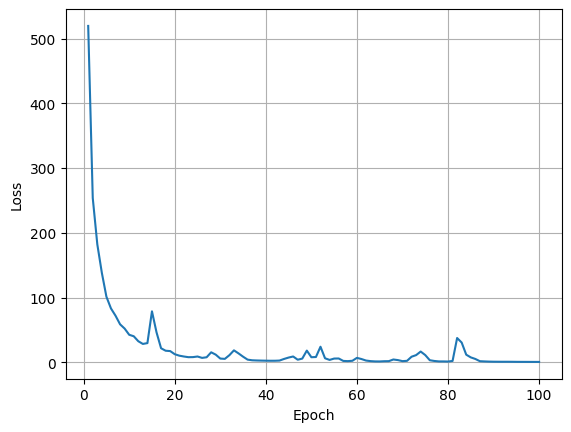

In [ ]:
print(X_train_all.shape, X_test_all.shape, y_train_all.shape, y_test_all.shape)
train_custom_dataset = CustomDataset(X_train_all, y_train_all)
# print(len(train_custom_dataset))
batch_size = 32
train_loader = data.DataLoader(train_custom_dataset, batch_size=batch_size, shuffle=True)
# print(len(train_loader))

test_custom_dataset = CustomDataset(X_test_all, y_test_all)
# print(len(test_custom_dataset))
batch_size = 32
test_loader = data.DataLoader(test_custom_dataset, batch_size=batch_size, shuffle=False)
# print(len(test_loader))


#################### Training the model ####################
model = Autoencoder_UNET(image_size = 80, num_input_channels = 4, num_output_channels=2, c_hid = 64, latent_dim = 2048, activation= nn.GELU)
model.to(device) 
from torchinfo import summary
print(summary(model, input_size=(1656, 4, 80, 80)))
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
losses = [] 
# Training loop
num_epochs = 100
for epoch in trange(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0.0
    
    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        inputs = inputs.to(device)
        targets = targets.to(device)
        # Forward pass
        outputs = model(inputs)
        
        # Calculate the loss
        loss = criterion(outputs, targets)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    # Print the average loss for this epoch
    average_loss = total_loss / len(train_loader)
    losses.append(average_loss)
    if epoch % 20 == 0: 
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {average_loss:.4f}")

############################# testing the model #############################
model.eval()  # Set the model to evaluation mode
test_loss = 0.0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, targets)

        test_loss += loss.item()

# Print the average test loss
average_test_loss = test_loss / len(test_loader)
# test_loss_list_P_25.append(average_test_loss)
print(f"Average Test Loss: {average_test_loss:.4f}")

plt.plot(range(1, num_epochs + 1), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.title('Train Loss vs. Epoch for channel '+target_var_96_list[x_channel])
plt.grid(True) 
plt.show() 

In [ ]:
torch.save(model.state_dict(), 'model/auto_conv_unet_in4_out2.pt')
model = Autoencoder_UNET(image_size = 80, num_input_channels = 4, num_output_channels=2, c_hid = 64, latent_dim = 2048, activation= nn.GELU)
model.to(device) 
model.load_state_dict(torch.load('model/auto_conv_unet_in4_out2.pt'))

<All keys matched successfully>